# Recommender Systems - Mini Challenge HS24

In this minichallenge we will explore a MovieLens dataset and implement several recommender systems and evaluation methods. Subsequently we will optimize these methods and compare the results. 

**Submission deadline:** 24.11.2024 18:00. 

## Guidelines for Implementation and Submission
- Code must be written in Python. The versions of all used packages must be given for reproducability.
- You may respond in English or German.
- We develop numerous algorithms ourselves. Unless explicitly stated otherwise, only the following libraries may be used in Python: numpy, matplotlib, seaborn, pandas. 
- Follow good coding practices and write modular, reusable code.
- The submitted solution must contain all codes and the results. No code may be outsourced.
- All pathes must be relative and just downloading your repo must be executable without modifications.
- Only fully running code is graded. The notebook must run sequential from start to end.
- If computation time is too long for productive prototyping and debugging work, it is recommended to reduce the dataset to a fraction of its original. However, final results should be calculated on the full dataset. 
- All plots must be fully labeled (title, axes, labels, colorbar, etc.) so that the plot can be easily understood.
- Each plot should be accompanied by a brief discussion, which explains the plot and captures the key insights that become visible.
- Only fully labeled plots with an accompanying discussion will be assessed.
- The last commit in your fork of the repo before the submission deadline counts as the submission.
- Points will be deducted if you write inconsise (Denial of service will be punished) or if I read the text that are not written for me but for the user of ChatGPT. 
- If you would like to submit and have the mini-challenge assessed, please send a short email to the subject expert (moritz.kirschmann@fhnw.ch) within 2 days after submission.
- Please do not delete, duplicate, or move the existing cells. This leads to problems during the correction. However, you may add as many additional cells as you like.

## Exercises

### Exercise 1 - A deep exploration of the dataset (17 points)
We will work with a subset of the MovieLens dataset. This subset is located under ``data/ml-latest-small``. Read the ``README.txt``carefully. 
Open the files. 

a) Describe the available data.

b) Find and fix bad data (e.g. duplicates, missing values, etc.).

Generate lists of

c) - Top 20 movies by average rating

d) - Top 20 movies by number of views

e) What is the range of the ratings? 

f) Which genre has be rated how many times?

g) How sparse is the User Rating Matrix?

Plot the following:

h) How many users have rated how many movies

i) Which rating is given how often on average

j) Which rating is given how often on average per genre

k) The rating distributions of 10 random movies

l) The rating distributions of 3 movies that you have watched

m) How many users give which average rating

n) How often a movie was rated as a function of average rating

o) A heatmap of the User Item Matrix

p) A heatmap of the User Item Matrix for the 100 most rated movies for the 50 users with most ratings


In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import os
import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import random
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split, GridSearchCV
from surprise import accuracy
from surprise import KNNWithMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.display import display
from io import StringIO
from sklearn.metrics import mean_squared_error

In [2]:
#Datensätze einlesen
output_dir = Path("Data\ml-latest-small")
csv_path_links = output_dir / "links.csv"
csv_path_movies = output_dir / "movies.csv"
csv_path_ratings = output_dir / "ratings.csv"
csv_path_tags = output_dir / "tags.csv"
links_raw = pd.read_csv(csv_path_links)
movies_raw = pd.read_csv(csv_path_movies)
ratings_raw = pd.read_csv(csv_path_ratings)
tags_raw = pd.read_csv(csv_path_tags)

## a) Describe the available data.
Die Daten von MovieLens, einem Filmempfehlungsdienst, beschreiben 5-Sterne-Bewertungen von Filmen. Er enthält 100’836 Bewertungen und 3’683 Tags-Anwendungen für 9’742 Filme. Diese Daten wurden von 610 Nutzern zwischen dem 29. März 1996 und dem 24. September 2018 erstellt. Der Datensatz wurde am 26. September 2018 erstellt.
Die Nutzer wurden nach dem Zufallsprinzip für die Aufnahme ausgewählt. Alle ausgewählten Nutzer hatten mindestens 20 Filme bewertet. Es sind keine demografischen Informationen enthalten. Jeder Nutzer wird durch eine ID repräsentiert, und es werden keine weiteren Informationen bereitgestellt.
Die Daten sind in den Dateien «links.csv», «movies.csv», «ratings.csv» und «tags.csv» enthalten. 
Die Daten:
•	ratings.csv: Enthält alle Bewertungen. Jede Zeile repräsentiert eine Bewertung eines Films durch einen Benutzer und hat das Format: «userId», «movieId», «rating» und «timestamp». Die Bewertungen erfolgen auf einer 5-Sterne-Skala mit Abstufungen von einem halben Stern (0,5 Sterne - 5,0 Sterne).
•	tags.csv: Enthält alle tags (Etikett). Jede Zeile repräsentiert ein tag, das von einem Benutzer auf einen Film angewendet wurde, und hat das Format: «userId», «movieId», «tag» und «timestamp». Tags sind vom Benutzer erstellte Metadaten zu Filmen, wie beispielsweise der Hauptdarsteller oder ein Wort das beschreibt um was es im Gilm geht (bsp. Wedding wenn im Film geheiratet wird).
•	movies.csv: Enthält Filminformationen. Jede Zeile repräsentiert einen Film und hat das Format: «movieId», «title» und «genres». Die Genres sind eine durch Pipes ( | ) getrennte Liste, welche genres vom Film alles abgedeckt werden.
•	links.csv: Enthält Bezeichner zur Verknüpfung mit anderen Quellen von Filmdaten. Jede Zeile repräsentiert einen Film und hat das Format: «movieId», «imdbId» (imbdId = Internet Movie Database ID) und «tmdbId» (tmdbid = The Movie Database ID). Diese IDs helfen dabei, einen Film eindeutig auf verschiedenen Plattformen zu identifizieren. Wenn man also eine bestimmte Filminformation abrufen möchte, kann man die jeweilige ID nutzen, um den Film auf einer der Plattformen zu finden.


In [3]:
#Aufgabe A
def data_describe(df, name):
    print(f"{name} Datensatz")
    print("\n Info")
    pprint.pprint(df.info())
    print("\n Head")
    pprint.pprint(df.head())
    print("\n describe")
    pprint.pprint(df.describe())

data_describe(links_raw, "links")

links Datensatz

 Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9734 entries, 0 to 9733
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9734 non-null   int64  
 1   imdbId   9734 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.3 KB
None

 Head
   movieId  imdbId   tmdbId
0        1  114709    862.0
1        2  113497   8844.0
2        3  113228  15602.0
3        4  114885  31357.0
4        5  113041  11862.0

 describe
             movieId        imdbId         tmdbId
count    9734.000000  9.734000e+03    9734.000000
mean    42215.724471  6.775551e+05   55162.123793
std     52173.928589  1.107581e+06   93653.481487
min         1.000000  4.170000e+02       2.000000
25%      3249.250000  9.518650e+04    9665.500000
50%      7300.000000  1.674155e+05   16529.000000
75%     76282.500000  8.059128e+05   44205.750000
max    193609.000000  8.391976e+06  52

In [4]:
data_describe(movies_raw, "movies")

movies Datensatz

 Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
None

 Head
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

 describe
             mo

In [5]:
data_describe(ratings_raw, "ratings")

ratings Datensatz

 Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None

 Head
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

 describe
              userId        movieId         rating     timestamp
count  100836.000000  100836.000000  100836.000000  1.008360e+05
mean      326.127564   19435.295718       3.501557  1.205946e+09
std       182.618491   35530.987199       1.042529  2.162610e+08
min         1.000000       1.000000       0.500000  8.2812

In [6]:
data_describe(tags_raw, "tags")

tags Datensatz

 Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB
None

 Head
   userId  movieId              tag   timestamp
0       2    60756            funny  1445714994
1       2    60756  Highly quotable  1445714996
2       2    60756     will ferrell  1445714992
3       2    89774     Boxing story  1445715207
4       2    89774              MMA  1445715200

 describe
            userId        movieId     timestamp
count  3683.000000    3683.000000  3.683000e+03
mean    431.149335   27252.013576  1.320032e+09
std     158.472553   43490.558803  1.721025e+08
min       2.000000       1.000000  1.137179e+09
25%     424.000000    1262.500000  

## b) Find and fix bad data (e.g. duplicates, missing values, etc.)
Beim Analysieren des Dataset, habe ich herausgefunden, dass beim Movies Datensatz nicht alle Filmtitel in der Spalte Filmtitel stehen, sondern teilweiseauch in der Spalte "movieId". Dies will ich hier beheben.

In [7]:
# Definierte Pfade der Datensätze
files = {
    "links": "Data/ml-latest-small/links.csv",
    "movies": "Data/ml-latest-small/movies.csv",
    "ratings": "Data/ml-latest-small/ratings.csv",
    "tags": "Data/ml-latest-small/tags.csv",
}

# Funktion zur Bereinigung und Standardisierung von CSV-Daten
def clean_dataframe(df):
    def clean_string(x):
        if isinstance(x, str):
            return x.strip("'\"")
        return x
    
    # Nur Objekt-Spalten bereinigen
    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].apply(clean_string)

    df = df.replace("<unset>", np.nan)

    # Versuchen, Objektspalten zu numerischen Typen zu konvertieren
    for col in df.select_dtypes(include='object').columns:
        try:
            df[col] = pd.to_numeric(df[col])
        except ValueError:
            continue

    df = df.drop_duplicates()

    return df

# Daten einlesen und bereinigen
dfs_cleaned = {}
for name, path in files.items():
    df = pd.read_csv(path)
    df_clean = clean_dataframe(df)

    duplicates_count = df.duplicated().sum()
    na_count = df_clean.isna().sum()

    print(f"{name.capitalize()} – Duplikate: {duplicates_count}, Fehlende Werte pro Spalte:\n{na_count}\n")

    dfs_cleaned[name] = df_clean

# Ausgabeordner
output_dir = "Data/filtered_data"
os.makedirs(output_dir, exist_ok=True)

# Speicherung der bereinigten Daten
for name, df in dfs_cleaned.items():
    df.to_csv(os.path.join(output_dir, f"{name}_cleaned.csv"), index=False)

print("Alle bereinigten Datensätze wurden erfolgreich gespeichert.")

Links – Duplikate: 0, Fehlende Werte pro Spalte:
movieId    0
imdbId     0
tmdbId     0
dtype: int64

Movies – Duplikate: 0, Fehlende Werte pro Spalte:
movieId    0
title      0
genres     0
dtype: int64

Ratings – Duplikate: 0, Fehlende Werte pro Spalte:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Tags – Duplikate: 0, Fehlende Werte pro Spalte:
userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

Alle bereinigten Datensätze wurden erfolgreich gespeichert.


In [8]:
#Gefilterte Datensätze wieder den Variablen zuweisen:
output_dir = Path("Data/filtered_data")
csv_path_links = output_dir / "links_cleaned.csv"
csv_path_movies = output_dir / "movies_cleaned.csv"
csv_path_ratings = output_dir / "ratings_cleaned.csv"
csv_path_tags = output_dir / "tags_cleaned.csv"
links = pd.read_csv(csv_path_links)
movies = pd.read_csv(csv_path_movies)
ratings = pd.read_csv(csv_path_ratings)
tags = pd.read_csv(csv_path_tags)

## c) Generate a lis of Top 20 movies by average rating
Plottet man die Top 20 Filme nach dem Durchschnitt der Bewertungen sind alle Filme mit einer Bewertung von 5.0 in der Liste. Das liegt daran, dass Filme mit jeweils nur einer 5.0 Bewertung in der Liste sind. Um ein repräsentativeres Ranking zu erhalten, berechne ich nun den Shrinked Average, welcher die Anzahl der Bewertungen pro Film berücksichtigt.

In [9]:
df = ratings.merge(movies, on='movieId')

top_20_rated = df.groupby('title')['rating'].mean().sort_values(ascending=False).head(20)
print(top_20_rated)

title
Tom and Jerry: A Nutcracker Tale (2007)                                                  5.0
Peaceful Warrior (2006)                                                                  5.0
Investigation Held by Kolobki (1986)                                                     5.0
Satin Rouge (2002)                                                                       5.0
Into the Woods (1991)                                                                    5.0
Into the Forest of Fireflies' Light (2011)                                               5.0
Into the Abyss (2011)                                                                    5.0
Nasu: Summer in Andalusia (2003)                                                         5.0
National Lampoon's Bag Boy (2007)                                                        5.0
Saving Face (2004)                                                                       5.0
Wings, Legs and Tails (1986)                                    

## d) Generate a list of Top 20 movies by number of views
Ich gehe hier davon aus, dass ein view einer Bewertung entspricht, da ein Film für eine Bewertung zumindest einmal gesehen werden muss.

In [10]:
top_20_viewed = df.groupby('title')['rating'].count().sort_values(ascending=False).head(20)
print(top_20_viewed)

title
Forrest Gump (1994)                                                               329
Shawshank Redemption, The (1994)                                                  317
Pulp Fiction (1994)                                                               307
Silence of the Lambs, The (1991)                                                  279
Matrix, The (1999)                                                                278
Star Wars: Episode IV - A New Hope (1977)                                         251
Jurassic Park (1993)                                                              238
Braveheart (1995)                                                                 237
Terminator 2: Judgment Day (1991)                                                 224
Schindler's List (1993)                                                           220
Fight Club (1999)                                                                 218
Toy Story (1995)                                

## e) What is the range of the ratings?

In [11]:
list_of_ratings = ratings["rating"].drop_duplicates().sort_values(ascending=False).tolist()
print(f"Die Spannweite der Bewertungen für die Filme liegt zwischen: {list_of_ratings[-1]} bis {list_of_ratings[0]}")

Die Spannweite der Bewertungen für die Filme liegt zwischen: 0.5 bis 5.0


## f) Which genre has be rated how many times?

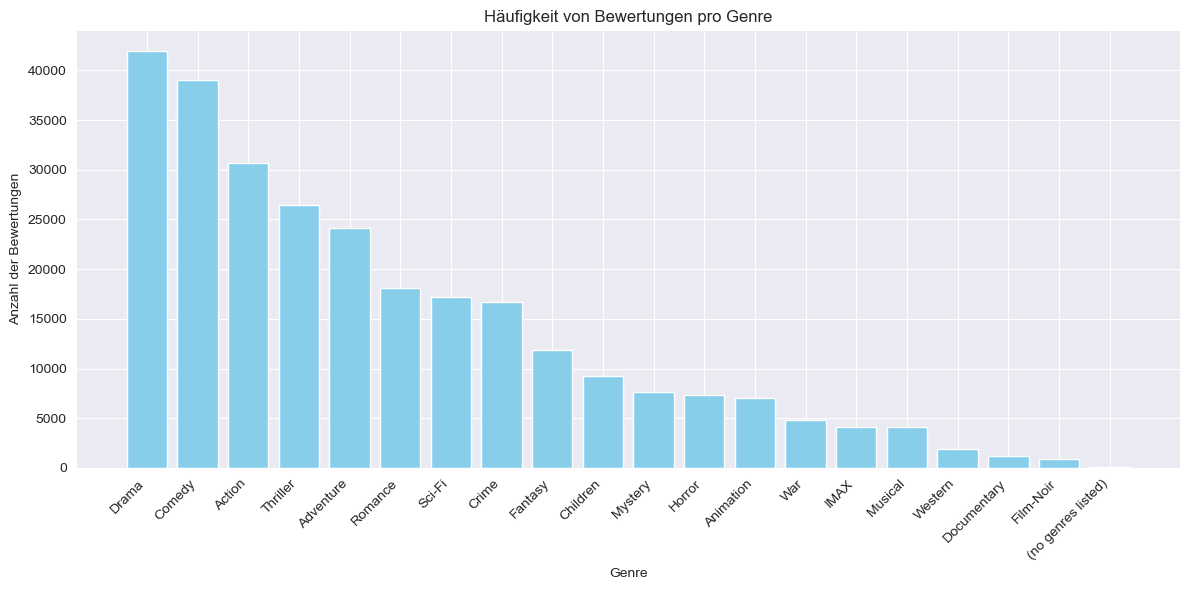

In [12]:
# Genres aus movies in ratings-Datensatz einbauen
ratings_mit_genres = ratings.merge(movies[["movieId", "genres"]], on="movieId", how="left")

# Genres aufsplitten
ratings_mit_genres_exploded = ratings_mit_genres.assign(genre=ratings_mit_genres["genres"].str.split("|")).explode("genre")

# Anzahl der Bewertungen pro Genre zählen
genre_counts = ratings_mit_genres_exploded["genre"].value_counts().reset_index()
#Titel vergeben
genre_counts.columns = ["genre", "count"]

plt.figure(figsize=(12, 6))
plt.bar(genre_counts["genre"], genre_counts["count"], color="skyblue")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Genre")
plt.ylabel("Anzahl der Bewertungen")
plt.title("Häufigkeit von Bewertungen pro Genre")
plt.tight_layout()
plt.show()

Die Genres Drama und Comedy wurden in diesem Datensatz meisten bewertet. Dies hat mich überrascht, da ich dachte, dass Action und Adventure Filme am meisten bewertet bzw. angesehen werden.

## g) How sparse is the User Rating Matrix?

In [13]:
# Anzahl der eindeutigen Benutzer und Filme
num_users = ratings["userId"].nunique()
num_movies = ratings["movieId"].nunique()

# Anzahl der vorhandenen Bewertungen
num_ratings = len(ratings)

# Gesamtanzahl der möglichen Bewertungen
total_mgl_ratings = num_users * num_movies


# Berechnung der spärlichkeit
spärlichkeit = 1 - (num_ratings / total_mgl_ratings)

print(f"Es fehlen rund {round(spärlichkeit,4) *100}% aller möglichen Bewertungen")

Es fehlen rund 98.3% aller möglichen Bewertungen


## h) How many users have rated how many movies

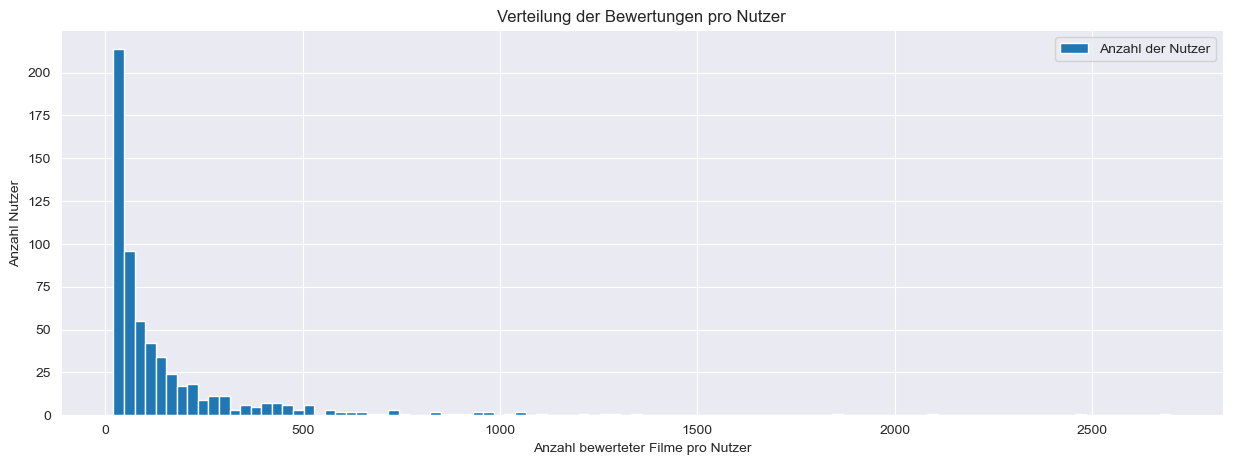

In [14]:
ratings_per_user = ratings.groupby("userId")["rating"].count().sort_values(ascending=False).reset_index()

plt.figure(figsize=(15, 5))
plt.hist(ratings_per_user["rating"], bins=100, label="Anzahl der Nutzer")
plt.xlabel("Anzahl bewerteter Filme pro Nutzer")
plt.ylabel("Anzahl Nutzer")
plt.title("Verteilung der Bewertungen pro Nutzer")
plt.legend()
plt.show()

Die meisten Benutzer haben offensichtlich kaum mehr als ca 200 Filme Bewertet, was mich nicht überrasch. Trotzdem bin ich erstaunt, wieviele Benuter doch noch mehr als 500 Filme bewertet haben. Damit hätte ich nie gerechnet.

## i) Which rating is given how often on average

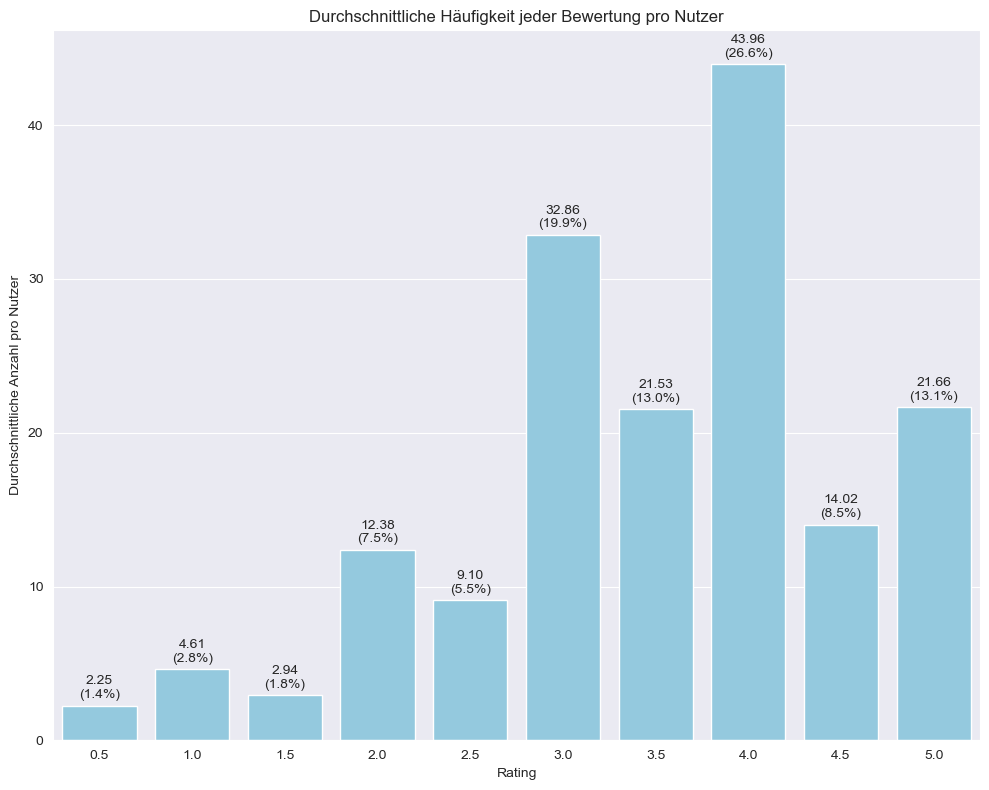

In [15]:
ratings_avg_per_user = ratings.groupby("rating")['movieId'].count() / num_users

# Prozentanteil (normiert auf alle Bewertungen eines Nutzers)
percentages = 100 * ratings_avg_per_user / ratings_avg_per_user.sum()

plt.figure(figsize=(10, 8))
sns.barplot(x=ratings_avg_per_user.index, y=ratings_avg_per_user.values, color="skyblue")

plt.xlabel("Rating")
plt.ylabel("Durchschnittliche Anzahl pro Nutzer")
plt.title("Durchschnittliche Häufigkeit jeder Bewertung pro Nutzer")

# Werte über die Balken schreiben (Zahl + Prozent)
for i, (v, pct) in enumerate(zip(ratings_avg_per_user.values, percentages.values)):
    plt.text(i, v + 0.3, f"{v:.2f}\n({pct:.1f}%)", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

Hier hätte ich tatsächlich eher mit einer Normalverteilung gerechnet. Auffällig ist, dass es doch eher viel hohe Bewertungen für Filme gab. Trotzdem ist durch diesen Plot gut ersichtlich, dass gewisse User chronisch schlechter bewerten als andere und umgekehrt.

## j) Which rating is given how often on average per genre

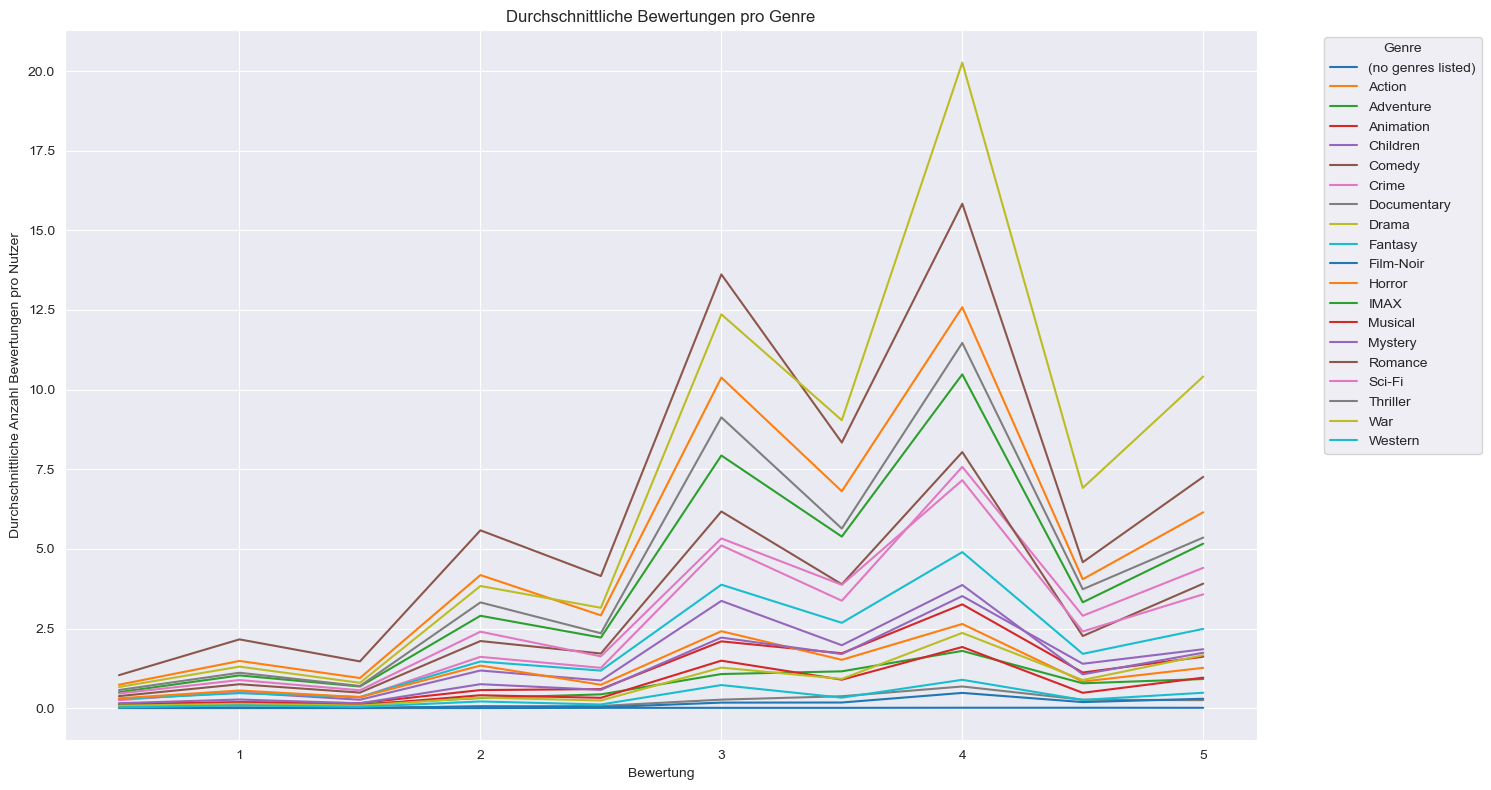

In [16]:
#code aus aufgabe f wird hier kopiert, falls man es laufen lassen will ohne aufgabe f laufen zu lassen
ratings_mit_gernes = ratings.merge(movies[["movieId", "genres"]], on="movieId", how="left")
ratings_mit_gernes_exploded = ratings_mit_gernes.assign(genre=ratings_mit_gernes["genres"].str.split("|")).explode("genre")

genre_avg_ratings = ratings_mit_gernes_exploded.groupby(["genre", "rating"])["userId"].count() / num_users

# Umwandlung für den Plot
genre_avg_ratings = genre_avg_ratings.reset_index(name="avg_rating")


plt.figure(figsize=(15, 8))

for genre in genre_avg_ratings['genre'].unique():
    genre_data = genre_avg_ratings[genre_avg_ratings['genre'] == genre]
    plt.plot(genre_data['rating'], genre_data['avg_rating'], label=genre)


plt.title('Durchschnittliche Bewertungen pro Genre')
plt.xlabel('Bewertung')
plt.ylabel('Durchschnittliche Anzahl Bewertungen pro Nutzer')
plt.legend(title="Genre", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


Dieser Plot wiederspiegelt eigentlich nur, was wir in einer Aufgabe zuvor erkennen konnten und zwar, wie gut gewisse Genres bewertet wurden. Trotzdem sind die Bewertungen relativ gleichmässig über die Genres verteilt. Natürlich gibt es immer gewisse Genres die besser sind als andere. Beispielsweise schneiden Western Filme über alles gesehen eher schlechter ab, was aber auch bereits vorher in Aufgabe 1f bereits zu sehen war.

## k) The rating distributions of 10 random movies

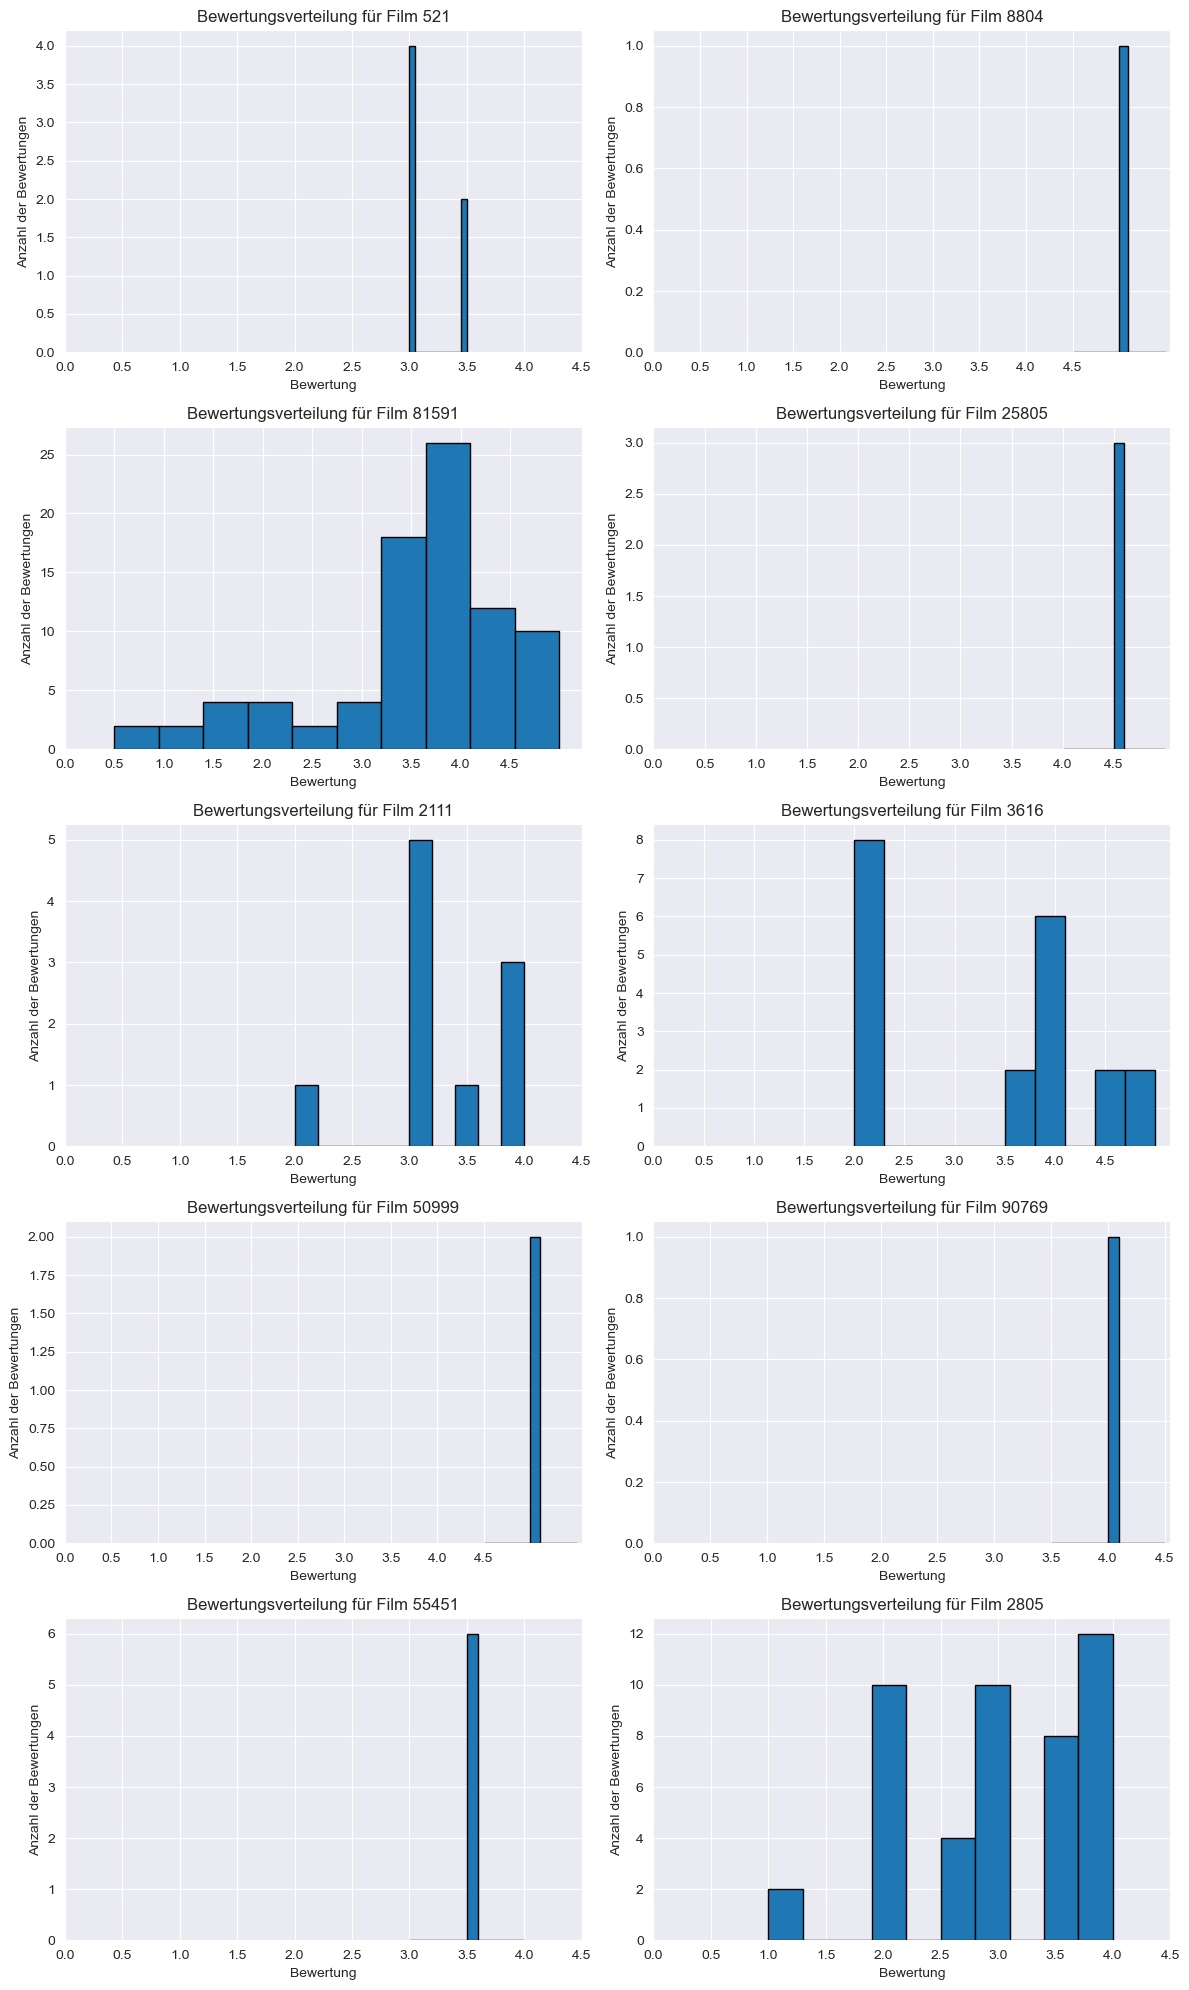

In [17]:
#code aus aufgabe f wird hier kopiert, falls man es laufen lassen will ohne aufgabe f laufen zu lassen
ratings_mit_gernes = ratings.merge(movies[["movieId", "genres"]], on="movieId", how="left")
ratings_mit_gernes_exploded = ratings_mit_gernes.assign(genre=ratings_mit_gernes["genres"].str.split("|")).explode("genre")

random_movies = random.sample(ratings_mit_gernes_exploded['movieId'].unique().tolist(), 10)

# Erstelle Plots mit mehreren Subplots
fig, axes = plt.subplots(5, 2, figsize=(12, 20))  # 5 Zeilen und 2 Spalten für 10 Filme
axes = axes.flatten()

# Erstellung für jeden zufällig ausgewählten Film ein Histogramm
for i, movie_id in enumerate(random_movies):
    movie_ratings = ratings_mit_gernes_exploded[ratings_mit_gernes_exploded['movieId'] == movie_id]['rating']
    
    # Histogramm für die Bewertung jedes Films erstellen
    axes[i].hist(movie_ratings, bins = 10, edgecolor='black')
    axes[i].set_title(f'Bewertungsverteilung für Film {movie_id}')
    axes[i].set_xlabel('Bewertung')
    axes[i].set_ylabel('Anzahl der Bewertungen')
    axes[i].set_xticks(np.arange(0, 5, 0.5))

plt.tight_layout()
plt.show()

Auffällig ist, das gewisse Filme nur eine Bewertung haben und andere massiv viel mehr. 

## l) The rating distributions of 3 movies that you have watched

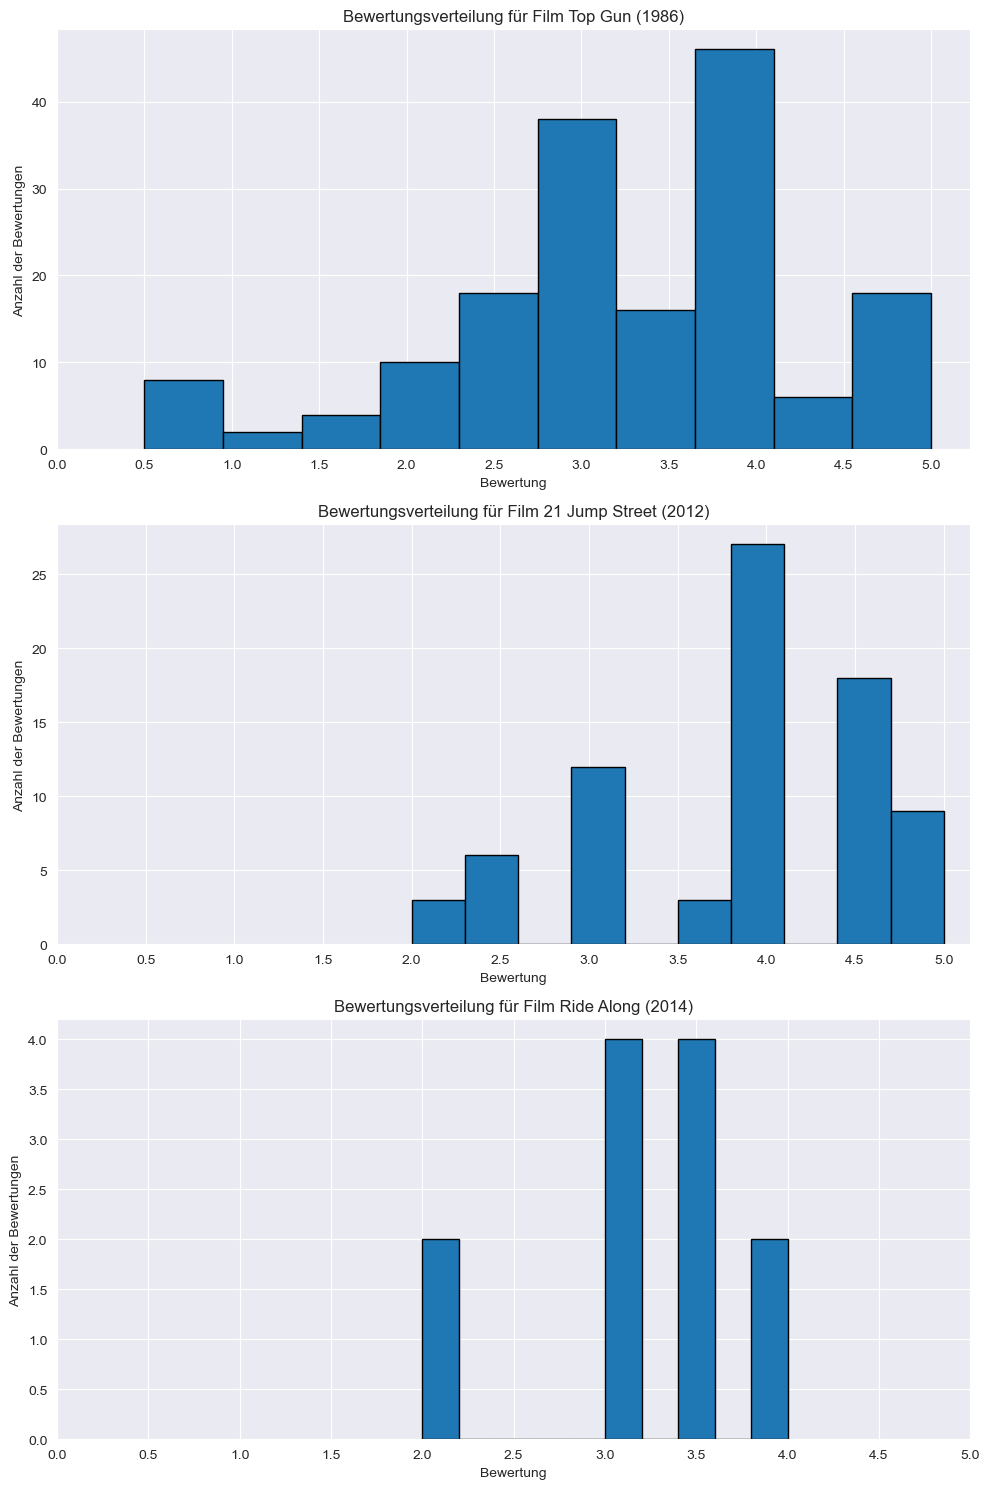

In [18]:
watched_movie_ids = [1101, 93510, 108156]  # Ersetze dies mit den echten movieIds

fig, axes = plt.subplots(3, 1, figsize=(10, 15))  # 3 Zeilen für 3 Filme
axes = axes.flatten()

# Erstelle für jeden Film ein Histogramm der Bewertungen
for i, movie_id in enumerate(watched_movie_ids):
    movie_ratings = ratings_mit_gernes_exploded[ratings_mit_gernes_exploded['movieId'] == movie_id]['rating']
    
    # Hole den Titel des Films aus dem DataFrame (erste Übereinstimmung)
    movie_title = movies.loc[movies['movieId'] == movie_id]['title'].iloc[0]
    
    axes[i].hist(movie_ratings, bins=10, edgecolor='black')
    axes[i].set_title(f'Bewertungsverteilung für Film {movie_title}')
    axes[i].set_xlabel('Bewertung')
    axes[i].set_ylabel('Anzahl der Bewertungen')
    axes[i].set_xticks(np.arange(0, 5.5, 0.5))

# Layout optimieren
plt.tight_layout()
plt.show()

Die Bewertungen dieser Filme überrachen mich prinzipiel nicht gross, ausser die Bewertung von Ride-Along. Ich fand den Film toll und hätte ihm eine 4.5 gegeben. Ebenfalls hätte ich die Bewertungen von Top-Gun etwas höher eingeschätzt als sie effektiv sind. Bei 21-Jumpstreat habe ich nichts anderes erwartet, das das eher ein Film ist der in die Bewertungskategorie Top oder Flop geht.

## m) How many users give which average rating

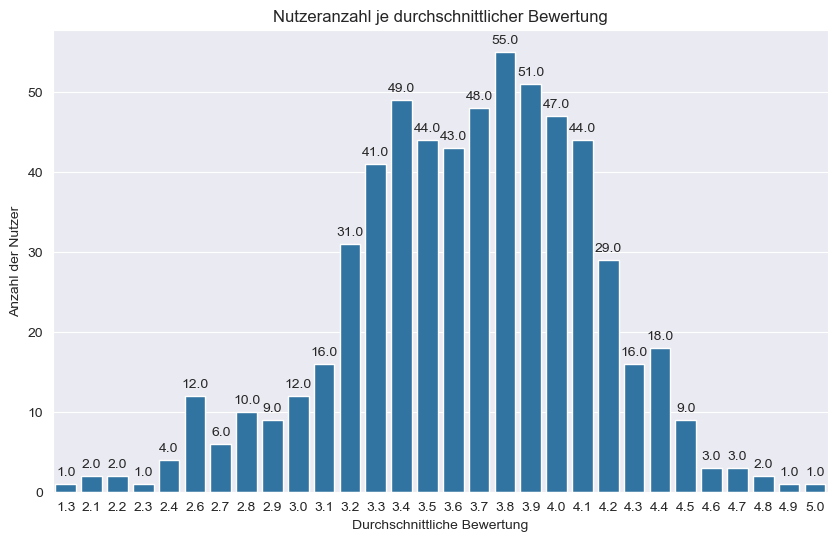

In [19]:
# Durchschnittsbewertung pro Nutzer berechnen
avg_rating_per_user = ratings.groupby("userId")["rating"].mean().reset_index()
avg_rating_per_user.columns = ["userId", "avg_rating"]

# Auf 0.5 runden für Gruppierung
avg_rating_per_user["rounded_avg"] = avg_rating_per_user["avg_rating"].round(1)

# Anzahl Nutzer je gerundetem Durchschnitt zählen
grouped = avg_rating_per_user["rounded_avg"].value_counts().sort_index().reset_index()
grouped.columns = ["avg_rating", "user_count"]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x="avg_rating", y="user_count", data=grouped)

plt.xlabel("Durchschnittliche Bewertung")
plt.ylabel("Anzahl der Nutzer")
plt.title("Nutzeranzahl je durchschnittlicher Bewertung")

# Zahlen über die Balken schreiben
for i, row in grouped.iterrows():
    plt.text(i, row["user_count"] + 1, f"{row['user_count']}", ha='center', fontsize=10)

plt.show()

Auffällig ist, dass der Grossteil der Nutzer eine durchschnittliche Bewertung im Bereich zwischen 3.3 und 4.1 vergibt, wobei der häufigste Durchschnittswert bei 3.7 liegt. Diese Form der Verteilung ähnelt einer Normalverteilung, was auf ein relativ normales Bewertungsverhalten hindeutet. Die Tatsache, dass die Kurve um diesen Mittelbereich symmetrisch abfällt, zeigt, dass es nur wenige Nutzer gibt, die im Schnitt extrem hohe (z.B. 4.7 bis 5.0) oder extrem niedrige Bewertungen (z.B. 1.0 bis 2.0) vergeben. Daraus lässt sich schliessen, dass die meisten Nutzer tendenziell weder übermässig kritisch noch ausschliesslich positiv bewerten. Um ehrlich zusein, hätte mich auch alles andere überrascht.

## n) How often a movie was rated as a function of average rating

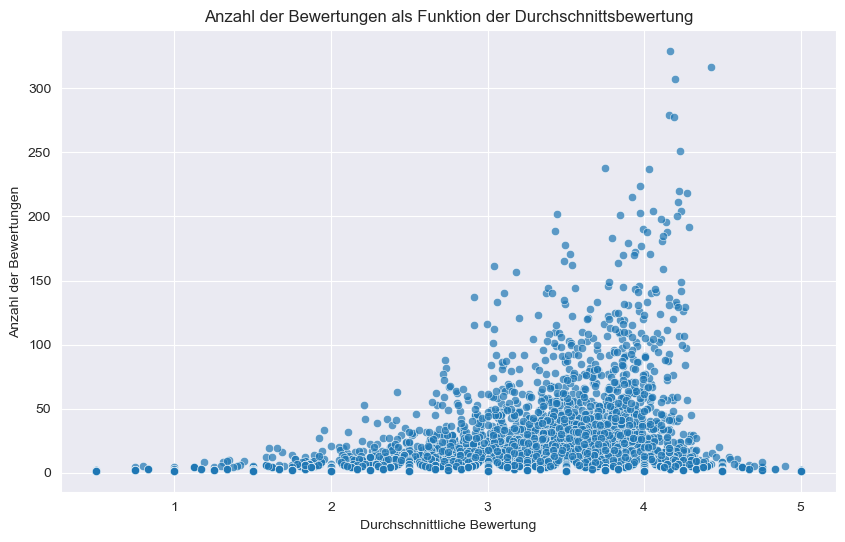

In [20]:
movie_rating_statistic = ratings.groupby("movieId").agg(
    avg_rating = ("rating", "mean"), #Durchschnittsbewertung pro Fim
    rating_count=("rating", "count")).reset_index() #Anzahl der Bewertung pro Film

plt.figure(figsize=(10,6))
sns.scatterplot(
    x=movie_rating_statistic["avg_rating"], 
    y=movie_rating_statistic["rating_count"], 
    alpha=0.7) #Transparenz

plt.xlabel("Durchschnittliche Bewertung")
plt.ylabel("Anzahl der Bewertungen")
plt.title("Anzahl der Bewertungen als Funktion der Durchschnittsbewertung")

plt.show()

Auffällig ist, dass sich die meisten Punkte im Bereich zwischen 3.0 und 4.0 auf der x-Achse befinden – das entspricht also Nutzern, die im Schnitt eher wohlwollend aber nicht übermässig positiv bewerten. Gleichzeitig zeigt sich, dass aktive Nutzer, also jene mit einer hohen Anzahl an Bewertungen (teilweise über 300), tendenziell im oberen Bereich der durchschnittlichen Bewertungen liegen, insbesondere zwischen 3.5 und 4.5. Es gibt kaum Nutzer mit sehr vielen Bewertungen und gleichzeitig einem extrem niedrigen Durchschnitt (z.B. < 2.0), was auf ein insgesamt eher positives Bewertungsverhalten der Vielbewerter hinweist.

Der untere Bereich des Plots ist dicht mit Punkten gefüllt, was zeigt, dass sehr viele Nutzer nur wenige Bewertungen abgeben – unabhängig davon, ob diese im Durchschnitt eher positiv oder negativ sind. Nutzer mit extrem niedrigen (< 2.0) oder extrem hohen Durchschnittsbewertungen (> 4.5) sind zwar vorhanden, sie geben aber insgesamt nur wenige Bewertungen ab.

## o) A heatmap of the User Item Matrix

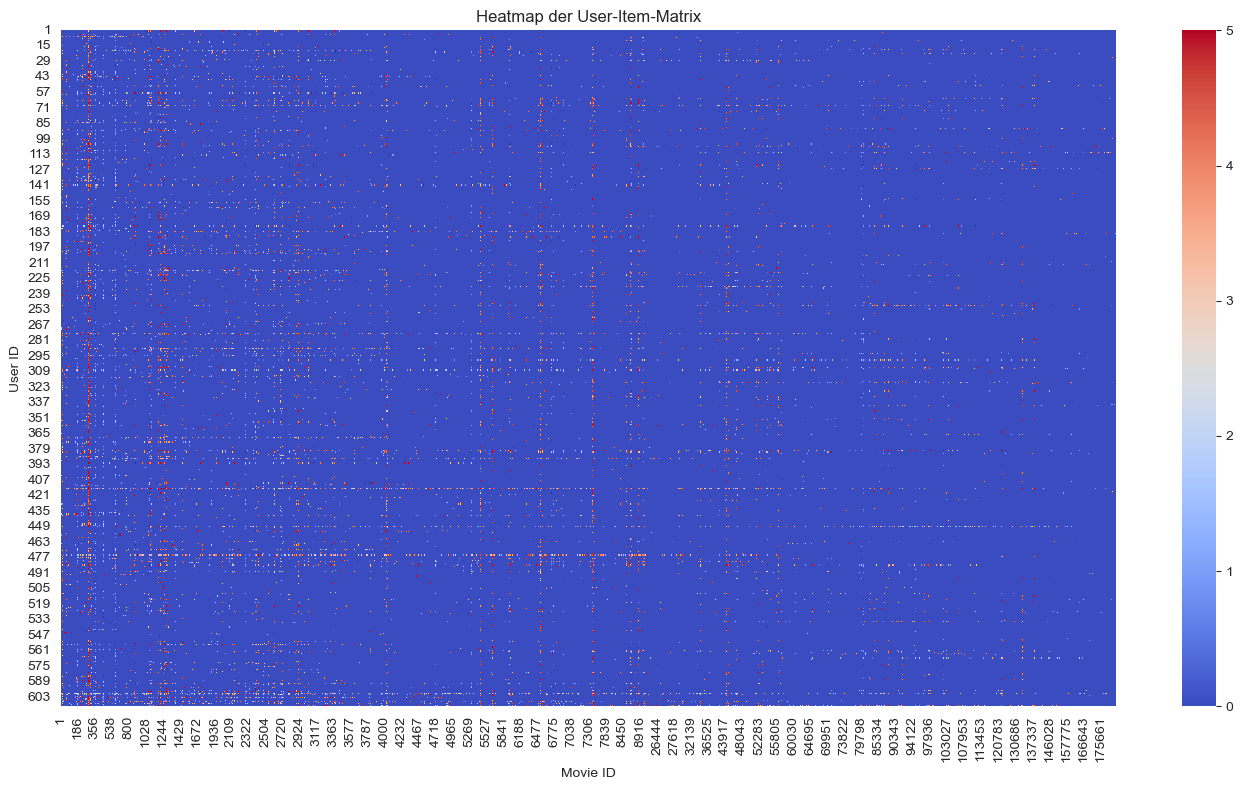

In [21]:
# User-Item-Matrix erstellen
user_item_matrix = ratings.pivot(index="userId", columns="movieId", values="rating")

# Fehlende Werte mit 0 ersetzen
user_item_matrix = user_item_matrix.fillna(0)
plt.figure(figsize=(14, 8))
sns.heatmap(user_item_matrix, cmap="coolwarm")
plt.title("Heatmap der User-Item-Matrix")
plt.xlabel('Movie ID')
plt.ylabel('User ID')
plt.tight_layout()
plt.show()

Hier wird nochmal deutlich wie sparce die MAtrix effektiv ist. Ich habe schon damit gerechnet, aber dass es gerade so extrem ist, hätte ich trotz der Aufgabe 1g nicht erwartet.

## p) A heatmap of the User Item Matrix for the 100 most rated movies for the 50 users with most ratings

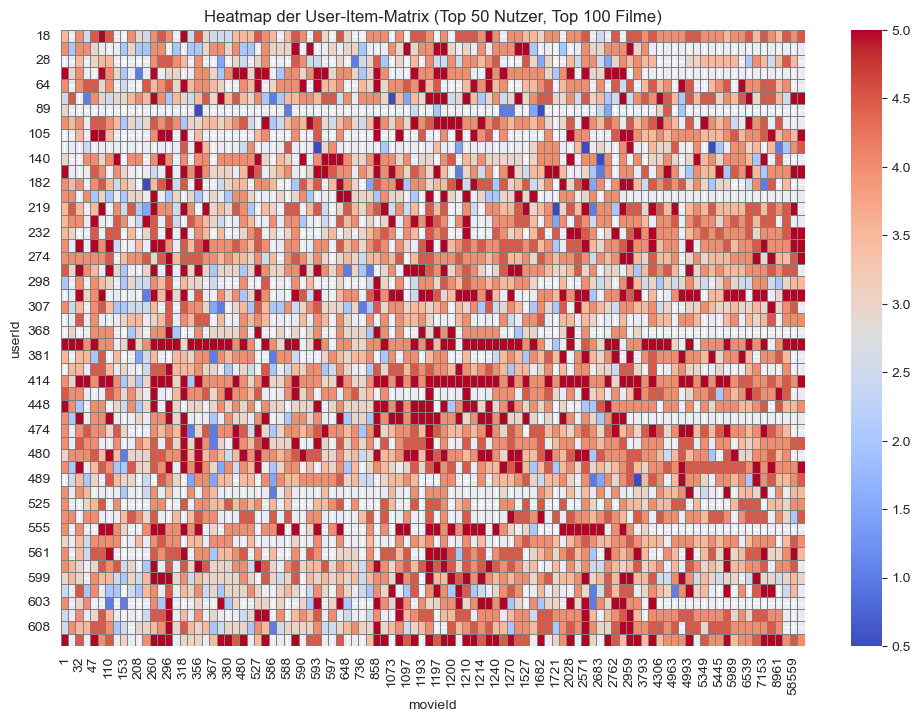

In [22]:
# 50 aktivste Nutzer (mit den meisten Bewertungen) ermitteln
top_users = ratings['userId'].value_counts().head(50).index

# 100 meistbewertete Filme ermitteln
top_movies = ratings['movieId'].value_counts().head(100).index

# User-Item-Matrix nur für diese Nutzer & Filme erstellen
filtered_ratings = ratings[(ratings['userId'].isin(top_users)) & (ratings['movieId'].isin(top_movies))]
user_item_matrix = filtered_ratings.pivot(index="userId", columns="movieId", values="rating")

plt.figure(figsize=(12, 8))
sns.heatmap(user_item_matrix, cmap="coolwarm", linewidths=0.5, linecolor="gray")
plt.yticks(rotation=0)

plt.title("Heatmap der User-Item-Matrix (Top 50 Nutzer, Top 100 Filme)")

plt.show()

Im Vergleich zur vorherigen Heatmap ist erkennbar, dass die Matrix sehr dense ist. Die Top 50 Benutzer mit den meisten Bewertungen haben oft fast alle der Top 100 meist bewerteten Filme bewertet. Grundsätzlich sind die Bewertungen meist gut bis sehr gut, es sind aber erste Muster erkennbar, dass diese Benutzer Gemeinsamkeiten haben. 

### Exercise 2 - Building a baseline RS (7 points)
In this exercise we will build a baseline RS and functions to calculate fundamental performance metrics. 

Build the following baseline RS to predict Top-N (default N=20):
1. In reference to the book *Collaborative Filtering Recommender Systems by Michael D. Ekstrand, John T. Riedl and Joseph A. Konstan* (p. 91ff) implement the baseline predictor $$ b_{u,i}= \mu +b_u +b_i $$ with the regularized user and item average offsets: $$ b_u = \frac{1}{|I_u| + \beta_u} \sum_{i \in I_u} (r_{u,i} - \mu) $$ and $$ b_i = \frac{1}{|U_i| + \beta_i} \sum_{u \in U_i} (r_{u,i} - b_u - \mu) . $$ Build a recommender system upon this baseline predictor. Set the default damping factors $\beta_u$ and $\beta_i$ both to 20.
2. Build a RS that recommends based on *random* recommendations.  

Output the recommendations for three example users (Ids 1, 3 and 7) and the default parameters. Give the titles of the recommended movies and their predicted scores not just their Ids.

### Code zur Berechnung von
  $$ b_u = \frac{1}{|I_u| + \beta_u} \sum_{i \in I_u} (r_{u,i} - \mu) $$ und $$ b_i = \frac{1}{|U_i| + \beta_i} \sum_{u \in U_i} (r_{u,i} - b_u - \mu) . $$

In [23]:
def calculate_biases(df, beta_u=20, beta_i=20, iteration=10):
    #erstellt einen Key, wenn der aufgerufene Key nicht existiert
    b_i = defaultdict(float)
    b_u = defaultdict(float)
    #Globalen Durchschnitt berechnen
    mu = df["rating"].mean()

    # Vorab gruppieren nach User und Movie
    user_groups = df.groupby("userId")
    movie_groups = df.groupby("movieId")

    for _ in range(iteration):
        # Update b_u
        for user_id, group in user_groups:
            numer = (group["rating"] - mu - group["movieId"].map(b_i)).sum()#Summe der Abweichung für den nutzer
            denom = beta_u + len(group) #Filme mit weniger bewertungen sollen damit stärker reguliert werden
            b_u[user_id] = numer / denom #berechneter user bias

        # Update b_i
        for movie_id, group in movie_groups:
            numer = (group["rating"] - mu - group["userId"].map(b_u)).sum()#Summe der Abweichung für den Film
            denom = beta_i + len(group)
            b_i[movie_id] = numer / denom #berechneter item bias

    return mu, dict(b_u), dict(b_i)

mu_baseline, b_u_baseline, b_i_baseline = calculate_biases(ratings)

In [24]:
def save_all_biases_to_csv(mu, b_u, b_i, filename='all_biases.csv'):

    # Erstelle DataFrames für die Biases
    bu_df = pd.DataFrame(list(b_u.items()), columns=['userId', 'user_bias'])
    bi_df = pd.DataFrame(list(b_i.items()), columns=['movieId', 'item_bias'])
    
    # Füge mu als Spalte hinzu
    bu_df['mu'] = mu
    bi_df['mu'] = mu
    
    # Speichere in einer Datei (optional können Sie auch separate Dateien bevorzugen)
    with open(filename, 'w') as f:
        f.write(f"Global average (mu): {mu}\n\n")
        f.write("User Biases:\n")
        bu_df.to_csv(f, index=False)
        f.write("\n\nItem Biases:\n")
        bi_df.to_csv(f, index=False)

# Aufruf:
save_all_biases_to_csv(mu_baseline, b_u_baseline, b_i_baseline)

In [25]:
def load_all_biases_from_csv(filename='all_biases.csv'):
    # Ganze Datei einlesen
    with open(filename, 'r') as f:
        lines = f.readlines()

    # 1. Globalen Durchschnitt (mu) extrahieren
    mu = float(lines[0].strip().split(":")[1])

    # 2. Finde Startindexe für die Tabellen
    user_bias_start = lines.index("User Biases:\n") + 1
    item_bias_start = lines.index("Item Biases:\n")

    # 3. Extrahiere die Textblöcke für beide DataFrames
    user_bias_lines = lines[user_bias_start:item_bias_start - 1]
    item_bias_lines = lines[item_bias_start + 1:]

    # 4. In DataFrames umwandeln
    bu_df = pd.read_csv(StringIO("".join(user_bias_lines)))
    bi_df = pd.read_csv(StringIO("".join(item_bias_lines)))

    # 5. IDs in int umwandeln
    bu_df['userId'] = bu_df['userId'].astype(int)
    bi_df['movieId'] = bi_df['movieId'].astype(int)

    # 6. Dictionarys erstellen
    b_u = dict(zip(bu_df['userId'], bu_df['user_bias']))
    b_i = dict(zip(bi_df['movieId'], bi_df['item_bias']))

    return mu, b_u, b_i
mu_baseline, b_u_baseline, b_i_baseline = load_all_biases_from_csv()

### Berechnung der Top-N Recommendations für die User 1,3,7

Basierend auf ihren Berertungen

In [26]:
#Vorhersagen für die nicht bewerteten Filme eines Users
def predict(mu, b_u, b_i, user_ID, unrated_Itmes):
    prediction = []
    for item_ID in unrated_Itmes:
        predicted_rating = mu + b_u[user_ID] + b_i[item_ID]
        prediction.append((item_ID, predicted_rating))
    prediction.sort(key=lambda x: x[1], reverse=True)
    return prediction

#Vorhersagen für Top-N Empfehlungen
def get_top_n_reco(df,mu, b_u, b_i, user_ID, N = 20):
    #Filtern nach welche Filme bereits von User bewertet wurden
    rated = df[df["userId"] == user_ID]["movieId"]
    #Liste erstellen für alle nicht bertetetn Filme
    unrated_prod = [item for item in df["movieId"].unique() if item not in rated]
    #Vorhersage berechnen wie der Nutzer den Film finden würde
    top_n_pred = predict(mu, b_u, b_i,user_ID, unrated_prod)[:N]
    print(f"\n Top {N} Empfehlungen für Benutzer {user_ID} sind:")
    for rank, (movie_id, score) in enumerate(top_n_pred, start=1):
        movie_title = movies.loc[movies['movieId'] == movie_id, 'title'].values[0]
        print(f"{rank}. {movie_title} - Vorhergesagter Wert: {score:.2f}")


get_top_n_reco(ratings,mu_baseline, b_u_baseline, b_i_baseline, 1)
get_top_n_reco(ratings,mu_baseline, b_u_baseline, b_i_baseline, 3)
get_top_n_reco(ratings,mu_baseline, b_u_baseline, b_i_baseline, 7)


 Top 20 Empfehlungen für Benutzer 1 sind:
1. Shawshank Redemption, The (1994) - Vorhergesagter Wert: 5.04
2. Fight Club (1999) - Vorhergesagter Wert: 4.91
3. Godfather, The (1972) - Vorhergesagter Wert: 4.90
4. Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) - Vorhergesagter Wert: 4.89
5. Star Wars: Episode IV - A New Hope (1977) - Vorhergesagter Wert: 4.87
6. Star Wars: Episode V - The Empire Strikes Back (1980) - Vorhergesagter Wert: 4.86
7. Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) - Vorhergesagter Wert: 4.85
8. Princess Bride, The (1987) - Vorhergesagter Wert: 4.85
9. Pulp Fiction (1994) - Vorhergesagter Wert: 4.85
10. Goodfellas (1990) - Vorhergesagter Wert: 4.84
11. Godfather: Part II, The (1974) - Vorhergesagter Wert: 4.84
12. Schindler's List (1993) - Vorhergesagter Wert: 4.84
13. Dark Knight, The (2008) - Vorhergesagter Wert: 4.84
14. Rear Window (1954) - Vorhergesagter Wert: 4.84
15. Apocalypse Now (1979) - Vor

Es fällt auf, dass meist die selben Filmen hier ausgegeben werden, sofern der User diese Filme noch nicht gesehen hat. Die Scores sind zwar unterschiedlich aber es zeigt, dass dieses RS keine diversity aufzeigt.

### Zufällige Top-N Recommendations für die User 1,3,7

In [27]:
def random_recom(df, user_ID, mu, b_u, b_i, movies, N=20):
    # Filme, die der User schon gesehen hat
    rated = df[df['userId'] == user_ID]['movieId']
    
    # Alle anderen Filme
    unrated_prod = [item for item in df["movieId"].unique() if item not in rated.values]
    
    # Zufällige Auswahl
    random_recommendations = random.sample(unrated_prod, min(N, len(unrated_prod)))
    
    print(f"\nZufällige Empfehlungen für User {user_ID} mit vorhergesagtem Score:")
    
    for rank, movie_id in enumerate(random_recommendations, start=1):
        title = movies.loc[movies['movieId'] == movie_id, 'title'].values[0]
        
        # Vorhersage berechnen, wenn User- oder Item-Bias fehlen, nutze 0
        bu = b_u.get(user_ID, 0)
        bi = b_i.get(movie_id, 0)
        pred_score = mu + bu + bi
        
        print(f"{rank}. {title} — Vorhergesagter Score: {pred_score:.2f}")
        
random_recom(ratings, user_ID=1, mu=mu_baseline, b_u=b_u_baseline, b_i=b_i_baseline, movies=movies, N=20)
random_recom(ratings, user_ID=3, mu=mu_baseline, b_u=b_u_baseline, b_i=b_i_baseline, movies=movies, N=20)
random_recom(ratings, user_ID=7, mu=mu_baseline, b_u=b_u_baseline, b_i=b_i_baseline, movies=movies, N=20)


Zufällige Empfehlungen für User 1 mit vorhergesagtem Score:
1. Some Mother's Son (1996) — Vorhergesagter Score: 4.17
2. Cassandra's Dream (2007) — Vorhergesagter Score: 4.18
3. 5 Centimeters per Second (Byôsoku 5 senchimêtoru) (2007) — Vorhergesagter Score: 4.25
4. Drop Dead Fred (1991) — Vorhergesagter Score: 4.19
5. Untitled Spider-Man Reboot (2017) — Vorhergesagter Score: 4.49
6. Return of the Pink Panther, The (1975) — Vorhergesagter Score: 4.29
7. House of the Spirits, The (1993) — Vorhergesagter Score: 4.16
8. Better Living Through Circuitry (1999) — Vorhergesagter Score: 4.12
9. Mutant Aliens (2001) — Vorhergesagter Score: 4.27
10. That Touch of Mink (1962) — Vorhergesagter Score: 4.21
11. All That Heaven Allows (1955) — Vorhergesagter Score: 4.33
12. The Boy and the Beast (2015) — Vorhergesagter Score: 4.20
13. Big Empty, The (2003) — Vorhergesagter Score: 4.18
14. Walk Hard: The Dewey Cox Story (2007) — Vorhergesagter Score: 4.18
15. Undercover Blues (1993) — Vorhergesagter S

### Exercise 3 - Evaluation methods (12 points)
Split the data into train/validation set and a separate test set. This test set shall contain the first 20% of the users and shall not be used at all before exercise 10. With the remaining 80% do the following: 
Implement a function to partition your dataset for an offline evaluation based on holding out of random users with 5x cross validation with a 80/20 train/validation split. Within the validation set implement a masking with *all but n* approach. 
See page 2942 of https://jmlr.csail.mit.edu/papers/volume10/gunawardana09a/gunawardana09a.pdf for details on this approach. 

Choose the number of masked items n reasonably and explain your considerations.

Implement functions to calculate the following metrics:
- *Mean Absolute Error (MAE)* 
- *Root Mean Square Error (RMSE)*
- *Precision@N* with default $N=15$ and relevance threshold 4.0 stars.
- *Recall@N* with default $N=15$ and relevance threshold 4.0 stars.

Explain each of these. How does the relevance threshold influence the metrics? How would you choose this parameter?

Note: For the last two metrics use the definitions from https://medium.com/@m_n_malaeb/recall-and-precision-at-k-for-recommender-systems-618483226c54 with one exception: In case of the denominator being zero, set the metric to 0. 

## Datenaufteilung 20% = Test Datensatz und 80% = Trainings und Validierungsdatensatz

In [28]:
def split_dataset(dataset, Test_procent=0.2):
    user_unique = dataset["userId"].unique()
    
    num_test_users = int(len(user_unique) * Test_procent)
    test_users = user_unique[:num_test_users]
    
    #Test DF erstellen
    df_test = dataset[dataset["userId"].isin(test_users)]
    
    #Trainings DF estellen
    df_train = dataset[~dataset["userId"].isin(test_users)]
    
    return df_train, df_test

df_train, df_test = split_dataset(ratings)

#in csv abspeichern
output_dir = Path("Data/Train_Test_Validate")
df_test.to_csv(os.path.join(output_dir, f"test_df.csv"), index=False)
df_train.to_csv(os.path.join(output_dir, f"train_df.csv"), index=False)

In [29]:
output_dir = Path("Data/Train_Test_Validate")
csv_path_train = output_dir / "train_df.csv"
csv_path_test = output_dir / "test_df.csv"
training = pd.read_csv(csv_path_train)
test = pd.read_csv(csv_path_test)

Ich habe mich entschieden, 30% der Testuser für mein test_masked_df nicht zu maskieren, weil eine vollständige Maskierung aller Bewertungen pro Nutzer dazu führen könnte, dass keine echten Präferenzen mehr zur Verfügung stehen, was die Bewertung von Empfehlungsmodellen mit Precision und Recall unmöglich machen würde.
Dabei verwende ich bewusst einen prozentualen Anteil der sichtbaren Bewertungen pro Nutzer – nicht, um einzelne Nutzer vollständig zu maskieren, sondern um bei allen Nutzern einen Teil ihrer Bewertungen als Ground Truth zurückzuhalten.

In [30]:
def mask_test_all_but_percent(test_df, user_col="userId", rating_col="rating", percent_keep=0.3, random_seed=42):
    np.random.seed(random_seed)
    masked_list = []

    for user_id in test_df[user_col].unique():
        user_data = test_df[test_df[user_col] == user_id]

        if len(user_data) > 1:  # Nur maskieren, wenn der Nutzer mehr als eine Bewertung hat
            n_keep = int(len(user_data) * percent_keep)  # Anzahl der Bewertungen, die behalten werden sollen (prozentual)
            keep = user_data.sample(n=n_keep, random_state=random_seed)  # Zufällige Auswahl der Bewertungen
            mask = user_data.drop(keep.index).copy()  # Die Bewertungen, die nicht behalten werden
            mask[rating_col] = np.nan  # Setze Rating auf NaN für die maskierten Bewertungen
            user_masked = pd.concat([keep, mask])  # Kombiniere behaltene und maskierte Bewertungen
        else:
            user_masked = user_data  # Keine Maskierung, wenn nur eine Bewertung vorhanden ist

        masked_list.append(user_masked)

    test_masked = pd.concat(masked_list).reset_index(drop=True)
    return test_masked

# Test mit einer beispielhaften DataFrame
df_test_masked = mask_test_all_but_percent(test, percent_keep=0.3)

# In CSV abspeichern
output_dir = Path("Data/Train_Test_Validate")
df_test_masked.to_csv(os.path.join(output_dir, f"test_df_masked.csv"), index=False)

In [31]:
output_dir = Path("Data/Train_Test_Validate")
csv_path_train = output_dir / "train_df.csv"
csv_path_test = output_dir / "test_df.csv"
training = pd.read_csv(csv_path_train)
test = pd.read_csv(csv_path_test)
csv_path_test_masked = output_dir / "test_df_masked.csv"
test_masked = pd.read_csv(csv_path_test_masked)

## Cross Validation
### Mein Vorgehen
Ich habe zuerst den Trainingsdatensatz nach User gruppiert um dann die wichtigsten Werte auszugeben. Beispielsweise ist so zu erkennen, dass jeder Nutzer aus dem Trainings Datensatz im Durchschnitt 167.44 Bewertungen abgegeben hat. Die half mir mein validation Wert (all-but-n) Wert zu definieren. Ich habe in der Literatur, der n Wert darf nicht in der nähe von 20 sein, da ein user lediglich 20 Filme bewertet hat. Damit ich auch dort eine zutreffende Aussage machen kann, wählte ich anstelle eines festen Wert wie n=10, einen prozentualen Wert (20%) damit ich bei niemandem alles maskiere.

In [32]:
user_counts = training.groupby('userId').size()

print(user_counts.describe())

count     488.000000
mean      167.444672
std       286.372815
min        20.000000
25%        35.000000
50%        68.500000
75%       167.250000
max      2698.000000
dtype: float64


In [33]:
def cross_validation(dataset, parts=5, keep_frac=0.2, random_state=42):
    user_unique = dataset["userId"].unique()
    user_shuffled = pd.Series(user_unique).sample(frac=1, random_state=random_state).values
    user_folds = np.array_split(user_shuffled, parts)

    train_sets = []
    validation_visible_sets = []
    validation_ground_truth_sets = []

    for fold_users in user_folds:
        is_validation = dataset["userId"].isin(fold_users)
        train_set = dataset[~is_validation].copy()
        validation_set = dataset[is_validation].copy()

        # Sichtbare Bewertungen (All-but-X%)
        validation_visible = mask_test_all_but_percent(validation_set, percent_keep=keep_frac)

        # Maskierte Bewertungen = Ground Truth
        validation_ground_truth = validation_set.merge(
            validation_visible,
            how="outer",
            on=["userId", "movieId", "rating", "timestamp"],
            indicator=True
        )
        validation_ground_truth = validation_ground_truth[
            validation_ground_truth["_merge"] == "left_only"
        ].drop(columns=["_merge"])

        train_sets.append(train_set)
        validation_visible_sets.append(validation_visible)
        validation_ground_truth_sets.append(validation_ground_truth)

    return train_sets, validation_visible_sets, validation_ground_truth_sets


In [34]:
df_train, df_val_visible, df_val_ground = cross_validation(training, parts=5, keep_frac=0.2)

output_dir = Path("Data/Train_Test_Validate")
output_dir.mkdir(parents=True, exist_ok=True)

for idx in range(5):
    df_train[idx].to_csv(output_dir / f"train_set_{idx+1}.csv", index=False)
    df_val_visible[idx].to_csv(output_dir / f"validate_masked_{idx+1}.csv", index=False)
    df_val_ground[idx].to_csv(output_dir / f"validate_groundtruth_{idx+1}.csv", index=False)

## MAE
MAE gibt an, wie viel im Durchschnitt die Vorhersagen von den tatsächlichen Bewertungen abweichen. Ein kleiner MAE bedeutet, dass das Modell sehr genau ist. Ein hoher MAE zeigt, dass das Modell systematisch ungenaue Vorhersagen liefert. Der Schwellenwert hat in der Berechnung des MAE keinen direkten Einfluss, da MAE auf allen Bewertungen basiert, nicht nur auf den relevanten.

In [35]:
# Mean Absolute Error (MAE)
def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(np.array(y_true) - np.array(y_pred)))

## RMSE
RMSE ist ähnlich wie MAE, aber anstelle der absoluten Differenz wird das Quadrat der Differenz verwendet. Das Quadrat der Differenzen betont grössere Fehler stärker und macht RMSE empfindlicher gegenüber grossen Ausreissern. Wie bei MAE hat der Relevanz-Schwellenwert keinen direkten Einfluss auf RMSE. RMSE betrachtet alle Bewertungen und misst die durchschnittliche quadratische Abweichung, sodass alle Fehler gleich gewichtet werden.

In [36]:
# Root Mean Square Error (RMSE)
def root_mean_square_error(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

## Unterschiede und Zusammenspiel

Precision und Recall sind zwei Seiten derselben Medaille und stehen oft in einem Trade-off-Verhältnis.

**Precision** fokussiert sich darauf, wie genau die Empfehlungen sind, indem sie die Qualität der Top-N Empfehlungen bewertet. Beispielsweise hat man zwei Klassen, die man auf zwei Seiten aufteilen will. Precision betrachtet nur eine Seite und berechnet die Präzision. (Eselsbrücke: Preci**SI**on looks at elements on one **SI**de). Ein Modell mit hoher Precision hat wenige falsche Positive, was bedeutet, dass die meisten empfohlenen Items tatsächlich relevant sind.

**Recall** hingegen konzentriert sich darauf, wie vollständig die Empfehlungen sind, indem sie die Fähigkeit des Modells bewertet, alle relevanten Items zu finden. Beispielsweise hat man zwei Klassen, die man auf zwei Seiten aufteilen will. Recall betrachtet alles von einer Klasse und berechnet, wie viel richtig klassifiziert wurde. (Eselsbrücke: Rec**ALL** looks at **ALL** elements). Ein Modell mit hohem Recall hat wenige falsche Negative, was bedeutet, dass die meisten relevanten Items in den Empfehlungen enthalten sind.

Ein Modell kann hohe Precision haben, aber niedrigen Recall, wenn es sehr selektiv ist und nur die offensichtlich relevanten Items empfiehlt. Umgekehrt kann ein Modell hohen Recall haben, aber niedrige Precision, wenn es viele Items empfiehlt, von denen einige irrelevant sind.

Das Ziel ist oft, ein Gleichgewicht zwischen Precision und Recall zu finden, je nach den spezifischen Anforderungen der Anwendung. In einigen Fällen kann es wichtiger sein, alle relevanten Items zu finden (hoher Recall), während in anderen Fällen die Genauigkeit der Empfehlungen (hohe Precision) wichtiger ist.

Erklärung aus: https://www.youtube.com/watch?v=qWfzIYCvBqo

## Precision@N
Precision@N misst, wie viele der Top-N empfohlenen Items tatsächlich relevant sind. Ein hoher Wert zeigt, dass die empfohlenen Items von guter Qualität sind, da sie tatsächlich den Vorlieben des Nutzers entsprechen. Ein niedriger Wert zeigt, dass die Empfehlungen viele irrelevante Items enthalten.

Formel:

Precision@N = Anzahl der relevanten Items unter den Top-N Empfehlungen / N

 Der Relevanz-Schwellenwert beeinflusst die Anzahl der relevanten Items. Ein höherer Schwellenwert bedeutet, dass nur die am besten bewerteten Items als relevant betrachtet werden, was die Precision erhöhen könnte, da nur wenige, aber hoch bewertete Items als relevant gelten. Ein niedrigerer Schwellenwert bedeutet, dass auch schwächer bewertete Items als relevant zählen, was die Precision verringern kann, da mehr irrelevante Items in die Top-N-Empfehlungen aufgenommen werden könnten.
 
Für die Wahl des Schwellenwerts kommt es für mich darauf an, wofür mein Empfehlungssystem (RSY) verwendet werden soll. Beispielsweise würde ich in medizinischen Anwendungen eher einen hohen Schwellenwert wählen, da es dort wichtig ist, so wenige falsche Positive (FP) wie möglich zu haben. Hingegen würde ich bei einem Informationstool einen niedrigen Schwellenwert wählen, da es dort wichtiger sein könnte, dass der Benutzer alle möglichen Ergebnisse finden kann und selbst abwägen kann, was er anschauen möchte.


In [37]:
# Precision@N berechnen
def precision_at_n(predictions, relevant_items, N=15, threshold=4.0):
    # Filtere relevante Items
    relevant_items = [item for item in relevant_items if item[1] >= threshold]
    
    # Berechne die Top-N Empfehlungen
    top_n_predictions = sorted(predictions, key=lambda x: x[1], reverse=True)[:N]
    
    # Berechne Precision
    relevant_in_top_n = sum(1 for item in top_n_predictions if item[0] in [x[0] for x in relevant_items])
    return relevant_in_top_n / N if N > 0 else 0

## Recall@N
Recall@N misst, wie viele der relevanten Items im Testset in den Top-N Empfehlungen enthalten sind.  Ein hoher Wert zeigt, dass das Modell viele der relevanten Items empfiehlt, auch wenn sie nicht die höchste Punktzahl haben. Ein niedriger Wert deutet darauf hin, dass viele relevante Items übersehen wurden.

Formel:

Recall@N = Anzahl der relevanten Items in den Top-N Empfehlungen / Anzahl der relevanten Items im Testset

Der Schwellenwert beeinflusst die Anzahl der relevanten Items, die als Ziel für die Empfehlungen gelten. Ein niedrigerer Schwellenwert führt zu mehr relevanten Items und kann den Recall erhöhen, da es einfacher ist, mehr relevante Items in den Top-N-Empfehlungen zu finden. Ein höherer Schwellenwert führt zu weniger relevanten Items und kann den Recall verringern, da weniger Items als relevant betrachtet werden.

Für die Wahl des Schwellenwerts kommt es darauf an, wofür mein Empfehlungssystem (RSY) verwendet werden soll. Ein niedriger Schwellenwert ist sinnvoll, wenn es besonders wichtig ist, möglichst alle relevanten Items zu identifizieren, auch wenn dies bedeutet, dass einige irrelevante Items ebenfalls erfasst werden. Dies ist beispielsweise in der medizinischen Diagnostik entscheidend, um sicherzustellen, dass keine relevanten Krankheitsfälle übersehen werden. Ebenso ist ein hoher Recall bei Such- und Rettungsaktionen wichtig, um alle möglichen Hinweise zu berücksichtigen. In der Betrugserkennung und bei Spam-Filtern hilft ein hoher Recall, alle potenziell betrügerischen Transaktionen bzw. Spam-Nachrichten zu identifizieren. Insgesamt sollte der Schwellenwert so gewählt werden, dass er die spezifischen Anforderungen und Ziele der Anwendung optimal unterstützt.

In [38]:
# Recall@N berechnen
def recall_at_n(predictions, relevant_items, N=15, threshold=4.0):
    # Filtere relevante Items
    relevant_items = [item for item in relevant_items if item[1] >= threshold]
    
    # Berechne die Top-N Empfehlungen
    top_n_predictions = sorted(predictions, key=lambda x: x[1], reverse=True)[:N]
    
    # Berechne Recall
    relevant_in_top_n = sum(1 for item in top_n_predictions if item[0] in [x[0] for x in relevant_items])
    return relevant_in_top_n / len(relevant_items) if len(relevant_items) > 0 else 0

# Code der Precision und recal zusammen berechnet für Aufgabe 4 und 8

In [39]:
def precision_recall_at_n(predicted_list, true_list, N=15, threshold=4.0):
    precisions = []
    recalls = []

    for uid in predicted_list:
        if uid not in true_list:
            continue

        preds = predicted_list[uid]
        truths = true_list[uid]

        # Relevante Items im Ground Truth
        true_relevant = set(iid for iid, rating in truths if rating >= threshold)
        if not true_relevant:
            continue

        # Top-N vorhergesagte Items
        top_n = sorted(preds, key=lambda x: x[1], reverse=True)[:N]
        recommended = set(iid for iid, rating in top_n if rating >= threshold)

        # Schnittmenge
        rel_and_rec = recommended & true_relevant

        precision = len(rel_and_rec) / len(recommended) if recommended else 0
        recall = len(rel_and_rec) / len(true_relevant)

        precisions.append(precision)
        recalls.append(recall)

    return np.mean(precisions), np.mean(recalls)

## Train_Validate Daten Einlesen

In [40]:
output_dir = Path("Data/Train_Test_validate")
# Trainingssets
train_set_1 = pd.read_csv(output_dir / "train_set_1.csv")
train_set_2 = pd.read_csv(output_dir / "train_set_2.csv")
train_set_3 = pd.read_csv(output_dir / "train_set_3.csv")
train_set_4 = pd.read_csv(output_dir / "train_set_4.csv")
train_set_5 = pd.read_csv(output_dir / "train_set_5.csv")

# Validierungssätze (sichtbare Ratings, All-but-X%)
validate_masked_1 = pd.read_csv(output_dir / "validate_masked_1.csv")
validate_masked_2 = pd.read_csv(output_dir / "validate_masked_2.csv")
validate_masked_3 = pd.read_csv(output_dir / "validate_masked_3.csv")
validate_masked_4 = pd.read_csv(output_dir / "validate_masked_4.csv")
validate_masked_5 = pd.read_csv(output_dir / "validate_masked_5.csv")

# Ground Truths (maskierte Bewertungen, zum Auswerten)
validate_groundtruth_1 = pd.read_csv(output_dir / "validate_groundtruth_1.csv")
validate_groundtruth_2 = pd.read_csv(output_dir / "validate_groundtruth_2.csv")
validate_groundtruth_3 = pd.read_csv(output_dir / "validate_groundtruth_3.csv")
validate_groundtruth_4 = pd.read_csv(output_dir / "validate_groundtruth_4.csv")
validate_groundtruth_5 = pd.read_csv(output_dir / "validate_groundtruth_5.csv")

### Exercise 4 - Optimize hyperparameters of baseline RS (6 points)
Optimize the hyperparameters $\beta_u$ and $\beta_i$ for the baseline RS from exercise 2 based on the RMSE metric. To save computation time find a reasonable maximum value for the betas. Explain your approach and your solution.
Plot the MAE, RMSE, Precision@N, Recall@N as functions of the betas.

Which metric would you use for hyperparameter tuning? Explain your decision.

## Mein Ansatz
Ich gehe hier wiefolgt vor:

Ich nehme eine Liste von Werte für meine Hyperparameter Betas. Anschliessend iteriere ich über jeden einzelnen Wert und berechne aus dem Bias den MAE, RMSE, Prcision@N und Recall@N. Dabei fand ich den besten Wert, wenn man nur den RMSE Wert anschaut, bei $b_u$ = 1 und $b_i$ = 1 mit einem RMSE Wert von 0.9561.

## Was würde ich nehmen um den Hyperparameter zu tunen?
Ich würde, wie auch in der Aufgabe vorgesehen, RMSE (Root Mean Squared Error) für das Hyperparameter-Tuning verwenden, jedoch würde ich zusätzlich noch die Werte Precision@N und Recall@N verwenden. Diese beiden Metriken bieten wertvolle Informationen zur Performance des Empfehlungssystems, da sie die Qualität der Empfehlungen im Hinblick auf die tatsächlich relevanten Items für die Nutzer widerspiegeln.

Durch die Kombination von RMSE, Precision@N und Recall@N könnte man ein ausgewogenes Tuning durchführen, das sowohl die Vorhersagegenauigkeit als auch die Relevanz der Empfehlungen optimiert. Das könnte auch dazu führen, dass ein Modell gefunden werden kann, das in der Praxis eine bessere Nutzererfahrung bietet, da es nicht nur die Bewertungshäufigkeit berücksichtigt, sondern auch die tatsächliche Relevanz der Vorschläge für den jeweiligen Nutzer.

Würde ich also diese Metriken Benutzen, wäre der beste Wert für $b_u$ = 20 und $b_i$ = 1 mit den Werten:
- RMSE=0.9567
- Precision@15=0.7328
- Recall@15=0.2169

In [41]:
#Anpassung, da ich true und prediction am besten direkt hier berechne deshalb compute_rmse
def compute_rmse(mu, b_u, b_i, test_df):
    preds = []   # Liste zur Speicherung der vorhergesagten Bewertungen
    actuals = [] # Liste zur Speicherung der tatsächlichen Bewertungen
    
    # Iteration über alle Zeilen des Test-Datensatzes
    for _, row in test_df.iterrows():
        # Extrahiere Nutzer-ID, Film-ID und tatsächliche Bewertung aus der aktuellen Zeile
        u, i, true_rating = row["userId"], row["movieId"], row["rating"]
        
        # Berechne die vorhergesagte Bewertung:
        # globale Durchschnittsbewertung + Nutzer-Bias + Item-Bias
        # Falls kein Bias vorhanden ist, verwende 0 als Standardwert
        pred_rating = mu + b_u.get(u, 0) + b_i.get(i, 0)
        
        # Speichere die Vorhersage und die tatsächliche Bewertung
        preds.append(pred_rating)
        actuals.append(true_rating)
    
    # Berechne und gib die RMSE zwischen den tatsächlichen und vorhergesagten Bewertungen zurück
    return np.sqrt(mean_squared_error(actuals, preds))

β_u: 1, β_i: 1, RMSE: 0.9561, MAE: 0.7399, Precision@N: 0.7310, Recall@N: 0.2016
β_u: 1, β_i: 5, RMSE: 0.9619, MAE: 0.7442, Precision@N: 0.7429, Recall@N: 0.1838
β_u: 1, β_i: 10, RMSE: 0.9698, MAE: 0.7523, Precision@N: 0.7385, Recall@N: 0.1580
β_u: 1, β_i: 20, RMSE: 0.9804, MAE: 0.7642, Precision@N: 0.7297, Recall@N: 0.1224
β_u: 5, β_i: 1, RMSE: 0.9562, MAE: 0.7395, Precision@N: 0.7333, Recall@N: 0.2091
β_u: 5, β_i: 5, RMSE: 0.9620, MAE: 0.7439, Precision@N: 0.7401, Recall@N: 0.1892
β_u: 5, β_i: 10, RMSE: 0.9698, MAE: 0.7520, Precision@N: 0.7411, Recall@N: 0.1631
β_u: 5, β_i: 20, RMSE: 0.9803, MAE: 0.7639, Precision@N: 0.7302, Recall@N: 0.1256
β_u: 10, β_i: 1, RMSE: 0.9564, MAE: 0.7392, Precision@N: 0.7304, Recall@N: 0.2131
β_u: 10, β_i: 5, RMSE: 0.9621, MAE: 0.7437, Precision@N: 0.7409, Recall@N: 0.1935
β_u: 10, β_i: 10, RMSE: 0.9698, MAE: 0.7517, Precision@N: 0.7423, Recall@N: 0.1671
β_u: 10, β_i: 20, RMSE: 0.9802, MAE: 0.7636, Precision@N: 0.7317, Recall@N: 0.1300
β_u: 20, β_i: 1, R

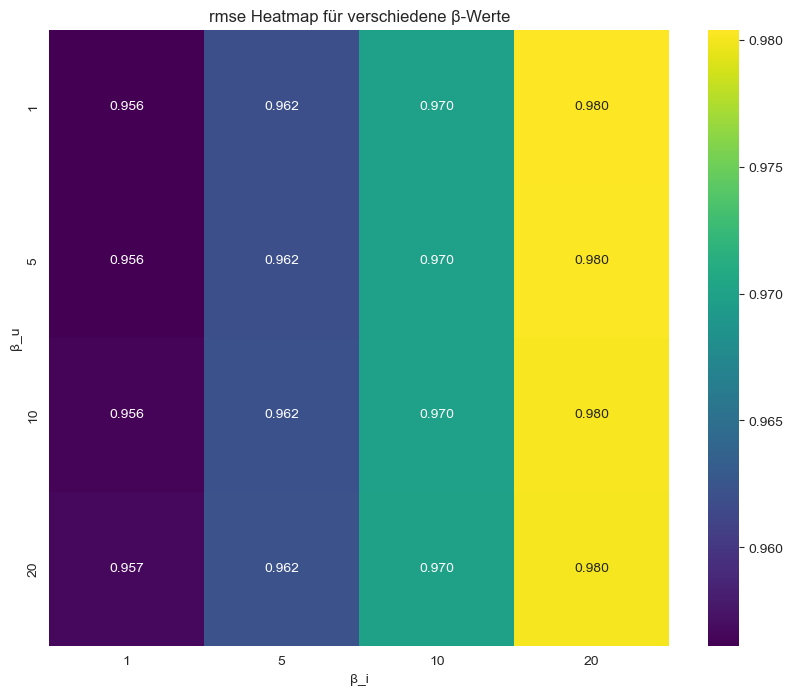

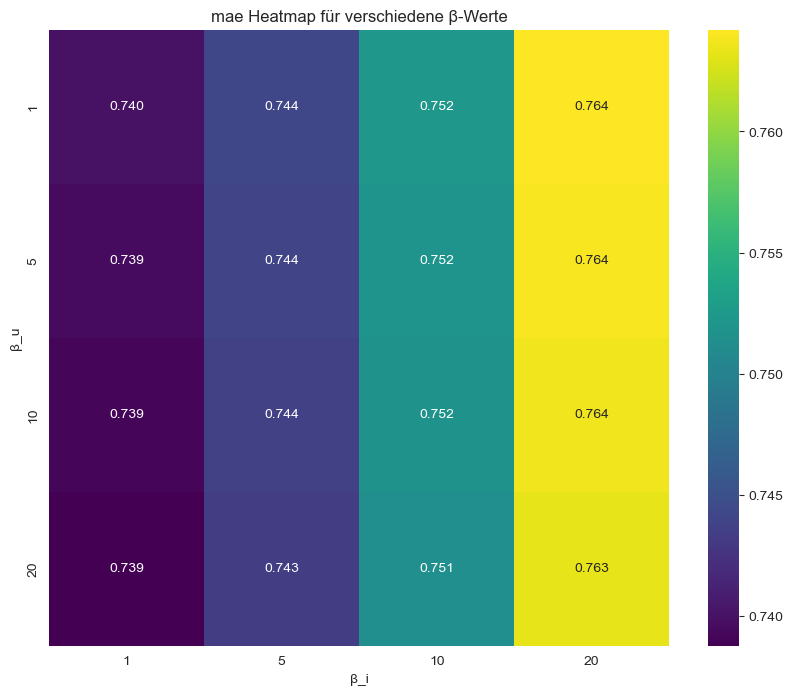

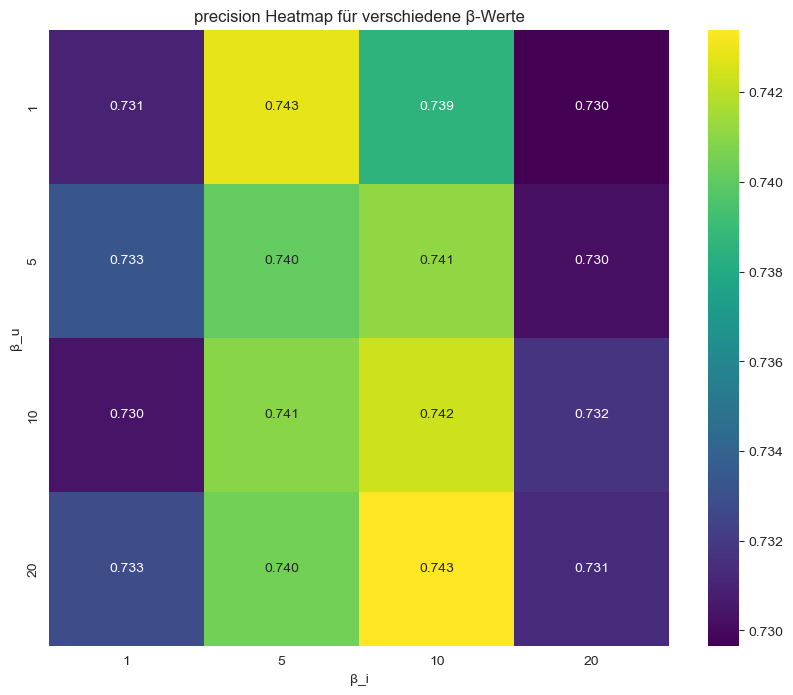

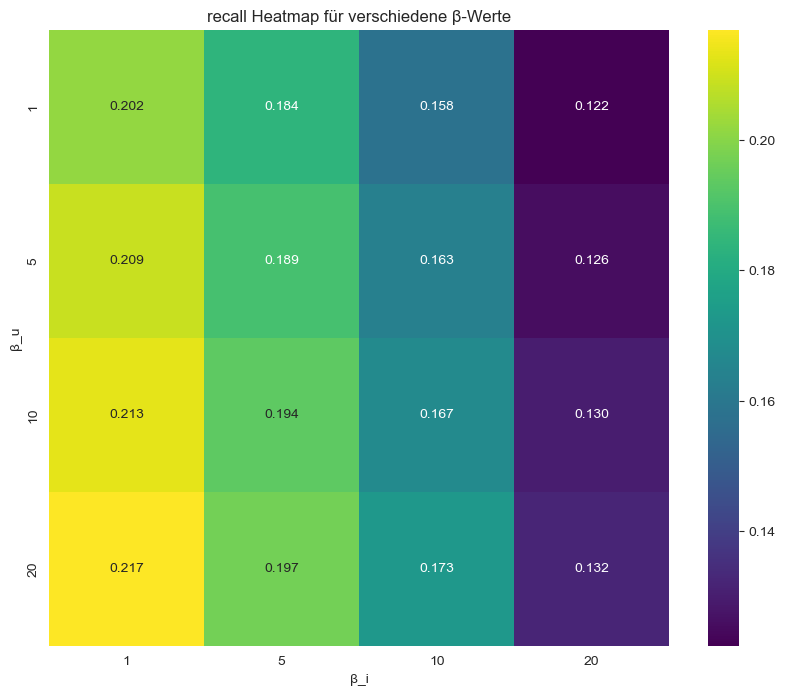

In [42]:
# Parameter und Ergebnis-Speicher
beta_values = [1, 5, 10, 20]
rmse_list, mae_values, precision_values, recall_values = [], [], [], []

train_sets = [pd.read_csv(output_dir / f"train_set_{i}.csv") for i in range(1, 6)]
validate_masked_sets = [pd.read_csv(output_dir / f"validate_masked_{i}.csv") for i in range(1, 6)]
validate_groundtruth_sets = [pd.read_csv(output_dir / f"validate_groundtruth_{i}.csv") for i in range(1, 6)]

#Hauptschleife über alle Betas & Folds
for beta_u in beta_values:
    for beta_i in beta_values:
        all_rmse, all_mae, all_prec, all_rec = [], [], [], []

        for fold in range(5):
            train_set = train_sets[fold]
            val_masked = validate_masked_sets[fold]
            val_groundtruth = validate_groundtruth_sets[fold]
            
            # Bias-Modell trainieren mit aktuellen β-Werten
            mu, b_u, b_i = calculate_biases(train_set, beta_u=beta_u, beta_i=beta_i, iteration=3)

           # Bewertungsvorhersagen auf Basis des Ground Truth
            predictions = [mu + b_u.get(u, 0) + b_i.get(i, 0)
                           for u, i in zip(val_groundtruth["userId"], val_groundtruth["movieId"])]
            true_ratings = val_groundtruth["rating"].values
            
            #RMSE, MAE
            rmse = compute_rmse(mu, b_u, b_i, val_groundtruth)
            mae = mean_absolute_error(true_ratings, predictions)
            
            # Vorbereiten der Struktur für Precision@N und Recall@N
            user_preds = defaultdict(list)
            user_truths = defaultdict(list)

            for u, i, true_r, pred_r in zip(val_groundtruth["userId"], val_groundtruth["movieId"], val_groundtruth["rating"], predictions):
                user_preds[u].append((i, pred_r)) #vorhersagen ratings pro nutzer
                user_truths[u].append((i, true_r)) #tatsächliche ratings pro nutzer
            
            # Precision@N und Recall@N berechnen
            precision, recall = precision_recall_at_n(user_preds, user_truths, N=15, threshold=4.0)

            all_rmse.append(rmse)
            all_mae.append(mae)
            all_prec.append(precision)
            all_rec.append(recall)
        
        # Durchschnittswerte über alle Folds speichern
        rmse_list.append((beta_u, beta_i, np.mean(all_rmse)))
        mae_values.append((beta_u, beta_i, np.mean(all_mae)))
        precision_values.append((beta_u, beta_i, np.mean(all_prec)))
        recall_values.append((beta_u, beta_i, np.mean(all_rec)))

        print(f"β_u: {beta_u}, β_i: {beta_i}, RMSE: {np.mean(all_rmse):.4f}, MAE: {np.mean(all_mae):.4f}, "
              f"Precision@N: {np.mean(all_prec):.4f}, Recall@N: {np.mean(all_rec):.4f}")

#Heatmaps erzeugen
def plot_heatmap(df, metric_name, cmap="viridis"):
    pivot = df.pivot(index="beta_u", columns="beta_i", values=metric_name)
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot, annot=True, fmt=".3f", cmap=cmap)
    plt.title(f"{metric_name} Heatmap für verschiedene β-Werte")
    plt.xlabel("β_i")
    plt.ylabel("β_u")
    plt.show()

df_results = pd.DataFrame(rmse_list, columns=["beta_u", "beta_i", "rmse"])
df_mae = pd.DataFrame(mae_values, columns=["beta_u", "beta_i", "mae"])
df_precision = pd.DataFrame(precision_values, columns=["beta_u", "beta_i", "precision"])
df_recall = pd.DataFrame(recall_values, columns=["beta_u", "beta_i", "recall"])

plot_heatmap(df_results, "rmse")
plot_heatmap(df_mae, "mae")
plot_heatmap(df_precision, "precision")
plot_heatmap(df_recall, "recall")

### Exercise 5 - Collaborative filtering; item-based and user-based (12 points)
In this exersise we will build several different collaborative-filtering RS based on nearest neighbour technique, both in terms of item and user. 

Implement:
1. a RS based on the $K$ most similar items (K nearest neighbours). Similarity shall be calculated based on *cosine similarity*. 
2. a RS based on the $K$ most similar items (K nearest neighbours). Similarity shall be calculated based on *Pearson Correlation Coefficienct*. 
3. a RS based on the $K$ most similar users (K nearest neighbours). Similarity shall be calculated based on *cosine similarity*. 
4. a RS based on the $K$ most similar users (K nearest neighbours). Similarity shall be calculated based on *Pearson Correlation Coefficienct*. 

Each should have a default $K$ of 30.

Explain how you handle NaN values in the user rating matrix when computing similarities? What other preparations are useful such as normalization and mean centering?

Describe the two similarity metrics.

Show the top 20 recommended items for user ids 3, 5 and 7.

# Anmerkung
Ich bin nicht sicher wie Repräsentativ das ganze ist, wenn ich es mit den Usern 3,5 und 7 mache, wenn diese im Test Data sind. deshalb habe ich um die aufgabe zu erfüllen dies mit den Usern 3,5,7 gemacht aber auch zusätzlich mit Usern die bereits im Trainingsdatensatz vorhanden waren um bessere ergebnisse zu erzielen.

# Umgang mit NaN-Werten

Ich ersetze die NaN-Werte in der Cosine Similarity (für sowohl Items als auch Users) mit 0, und zwar erst nachdem ich den Mittelwert pro Item bzw. User abgezogen habe. Dies stellt sicher, dass die Cosine Similarity-Funktion von scikit-learn korrekt berechnet werden kann, da diese Bibliothek keine NaN-Werte unterstützt. Bei der Pearson Similarity ersetze ich die NaN-Werte ebenfalls mit 0, allerdings nachdem ich die URM (User-Rating-Matrix) zentriert habe. Der Ersatz von NaN durch 0 ist eine pragmatische Lösung, da fehlende Bewertungen als „nicht vorhanden“ betrachtet werden, ohne den Berechnungsprozess zu stören.

In der Funktion predict_ratings_item_based und predict_ratings_user_based hingegen vermeide ich NaN-Werte direkt, indem ich alle NaN-Werte vorher mit dropna() entferne. Dadurch wird vermieden, dass fehlende Bewertungen den Vorhersageprozess beeinflussen, und es ist keine Notwendigkeit, NaN-Werte nachträglich zu ersetzen.

In [43]:
def create_urm(data, index="userId", colums="movieId", values="rating"):
    urm = data.pivot(index=index, columns=colums, values=values)
    return urm

urm = create_urm(train_set_1)

## Cosine Similarity

Die Cosine Similarity misst die Ähnlichkeit zwischen zwei Items, indem sie den Winkel zwischen ihren Bewertungsvektoren betrachtet. Je kleiner der Winkel, desto ähnlicher sind die Items im Bewertungsschema der Nutzer.

Um Verzerrungen durch unterschiedliche Bewertungsskalen zu vermeiden – z.B. wenn einige Nutzer generell strenger oder grosszügiger bewerten – wird häufig ein Mean-Centering durchgeführt: Dabei wird von jeder Bewertung der Durchschnittswert des jeweiligen Items (oder Nutzers) abgezogen.

Dadurch vergleicht die Cosine Similarity nicht die absoluten Werte, sondern die Abweichungen vom Mittelwert, also das tatsächliche Bewertungsmuster. Das macht die Ähnlichkeitsberechnung robuster und aussagekräftiger.



In [44]:


def cosine_similarity_items(matrix):
    # Mean-Centering pro Item
    item_means = matrix.mean(axis=0) #axis = 0 bedeutet den Mittelwert pro Spalte zu berechnen
    matrix_centered = matrix.sub(item_means, axis=1) # subtrahiert spaltenweise (axis = 1) den jeweiligen Mittelwert des Items ab

    return pd.DataFrame(
        cosine_similarity(np.nan_to_num(matrix_centered.T)),
        index=matrix.columns,
        columns=matrix.columns
    )

def cosine_similarity_users(matrix):
    # Mean-Centering pro User
    user_means = matrix.mean(axis=1) #axis = 1 bedeutet den Mittelwert pro Zeile zu berechnen
    matrix_centered = matrix.sub(user_means, axis=0) # subtrahiert zeilenweise (axis = 0) den jeweiligen Mittelwert des Users ab

    return pd.DataFrame(
        cosine_similarity(np.nan_to_num(matrix_centered)),
        index=matrix.index,
        columns=matrix.index
    )

## Pearson Similarity
Die Pearson Similarity misst die lineare Korrelation zwischen zwei Items oder Nutzern, basierend auf deren gemeinsamen Bewertungen. Sie betrachtet dabei nicht nur die Richtung der Bewertungen, sondern auch, ob hohe Bewertungen bei einem Item (bzw. Nutzer) mit hohen Bewertungen beim anderen einhergehen – unabhängig vom absoluten Bewertungsniveau.

Um individuelle Bewertungstendenzen auszugleichen, wird vor der Berechnung der Pearson Similarity ein Mean-Centering durchgeführt: Bei der Item-basierten Variante wird von jeder Bewertung der Mittelwert des jeweiligen Items abgezogen; bei der nutzerbasierten Variante erfolgt die Zentrierung zeilenweise, also pro Nutzer. So werden systematisch grosszügige oder strenge Bewertungsschemata normalisiert.

Anschliessend wird die Korrelation zwischen den zentrierten Vektoren berechnet. Da in der Praxis häufig nicht alle Nutzer alle Items bewerten, entstehen Lücken im Rating-Matrix – diese werden durch gezieltes Beibehalten oder Ersetzen von fehlenden Werten (NaN) berücksichtigt: Bei Items ignoriert pd.corr() diese NaN-Werte automatisch während der Korrelation; bei Nutzern hingegen werden sie nach dem Zentrieren direkt mit 0 ersetzt. Das sorgt für eine robuste Berechnung, selbst bei spärlich besetzten Daten.

In [45]:
def pearson_similarity_items(matrix):
    # Mittelwert zentrieren je Item (Spalte)
    item_means = matrix.mean(axis=0)  # Mittelwert pro Item (Spalte) <-------------- von 1 auf 0 geändert
    matrix_centered = matrix.sub(item_means, axis=1)  # Subtrahiere Mittelwert von jedem Item (Spalte)<-------------- von 0 auf 1 geändert
    
    # Berechne die Pearson-Ähnlichkeit zwischen den Items
    pearson_sim_matrix = matrix_centered.corr(method='pearson').fillna(0)

    return pearson_sim_matrix



def pearson_similarity_users(matrix):
    # Mittelwert zentrieren je User (Zeile)
    centered = matrix.sub(matrix.mean(axis=1), axis=0).fillna(0)# subtrahiert zeilenweise den jeweiligen Mittelwert pro Zeile des Items ab und ersetzt anschliessend alle NA Werte mit 0
    # Jetzt Zeilen miteinander korrelieren (User-User-Similarity) und anschliessend die NA-Werte mit 0 ersetzen
    similarity = centered.T.corr().fillna(0)
    return similarity

## Prediction Item-Based

In [46]:
def predict_ratings_item_based(user_id, item_similarity, urm_, k=30):
    user_ratings = urm_.loc[user_id]
    user_rated_items = user_ratings.dropna().index
    
    all_items = urm_.columns
    predictions = {}

    for target_item in all_items:
        if target_item in user_rated_items:
            continue  # Keine Vorhersage für bereits bewertete Items

        # Ähnlichkeiten zum Ziel-Item für alle vom User bewerteten Items
        sims = item_similarity.loc[target_item, user_rated_items]

        # Bewertungen des Users zu diesen Items
        ratings = user_ratings.loc[user_rated_items]

        # Top-k ähnlichste Items auswählen (nach Betrag der Ähnlichkeit sortieren)
        top_k = sims.abs().sort_values(ascending=False).head(k).index
        top_sims = sims.loc[top_k]
        top_ratings = ratings.loc[top_k]

        numerator = (top_sims * top_ratings).sum()
        denominator = top_sims.abs().sum()

        if denominator != 0:
            predictions[target_item] = numerator / denominator
        else:
            predictions[target_item] = np.nan  # oder z. B. globaler Mittelwert als Fallback

    # Rückgabe als Serie sortiert
    return pd.Series(predictions).dropna().sort_values(ascending=False)

### Top n item similatrity

In [47]:

def print_top_n_item_similarity(user_ids, urm_, method, movies_df=None, n=20, k=30):
    if method == "cosine":
        item_sim_matrix = cosine_similarity_items(urm_)
    elif method == "pearson":
        item_sim_matrix = pearson_similarity_items(urm_)
    else:
        print(f"Invalid method: {method}. Only 'cosine' or 'pearson' are allowed.")
        return
        
    use_titles = movies_df is not None and "movieId" in movies_df.columns and "title" in movies_df.columns
        
    if use_titles:
        movies_itembased = movies_df.set_index("movieId")

    for uid in user_ids:
        if uid in urm_.index:
            recs = predict_ratings_item_based(uid, item_sim_matrix, urm_, k)
            top_n = recs.head(n)
        else:
            global_avg_ratings = urm_.mean(axis=0)
            top_n = global_avg_ratings.sort_values(ascending=False).head(n)
            
        top_n.index = top_n.index.astype(int)
        if use_titles:
            valid_ids = top_n.index.intersection(movies_itembased.index)
            movie_titles = movies_itembased.loc[valid_ids, "title"]
            
            results = pd.DataFrame({
                "Predicted Rating": top_n.loc[valid_ids].values,
                "Movie Title": movie_titles.values
            })
            
            print(f"\nTop {n} recommendations for User {uid} (Item-Based, {method}):")
            print(results.set_index("Movie Title"))
        else:
            results = pd.DataFrame({
                "Movie ID": top_n.index,
                "Predicted Rating": top_n.values
            })
            
            print(f"\nTop {n} recommendations for User {uid} (Item-Based, {method}, only Movie IDs):")
            print(results.set_index("Movie ID"))


In [48]:
print_top_n_item_similarity(user_ids = [3,5,7], urm_ = urm, method = "cosine",movies_df=movies)


Top 20 recommendations for User 3 (Item-Based, cosine):
                                                    Predicted Rating
Movie Title                                                         
Blow-Out (La grande bouffe) (1973)                               5.0
Duel in the Sun (1946)                                           5.0
Endless Summer, The (1966)                                       5.0
The Blue Planet (2001)                                           5.0
Woman Is a Woman, A (femme est une femme, Une) ...               5.0
Beautiful Thing (1996)                                           5.0
Into the Woods (1991)                                            5.0
Enter the Void (2009)                                            5.0
Dragons: Gift of the Night Fury (2011)                           5.0
Last Hurrah for Chivalry (Hao xia) (1979)                        5.0
Girl on the Bridge, The (Fille sur le pont, La)...               5.0
Safety Last! (1923)                           

In [49]:
print_top_n_item_similarity(user_ids = [131,140,155], urm_ = urm, method = "cosine",movies_df=movies)


Top 20 recommendations for User 131 (Item-Based, cosine):
                                                    Predicted Rating
Movie Title                                                         
Exorcist II: The Heretic (1977)                             3.870138
Adventures of Pinocchio, The (1996)                         3.823000
Birdcage, The (1996)                                        3.816997
Focus (2015)                                                3.799834
The Conjuring 2 (2016)                                      3.744337
Fletch (1985)                                               3.655502
Vertigo (1958)                                              3.644542
Sisters (2015)                                              3.636094
Good, the Bad and the Ugly, The (Buono, il brut...          3.620499
Predestination (2014)                                       3.615880
Twelve Monkeys (a.k.a. 12 Monkeys) (1995)                   3.615602
Midnight Run (1988)                         

In [50]:
print_top_n_item_similarity(user_ids = [3,5,7], urm_ = urm, method = "pearson", movies_df=movies)


Top 20 recommendations for User 3 (Item-Based, pearson):
                                                    Predicted Rating
Movie Title                                                         
Blow-Out (La grande bouffe) (1973)                               5.0
Duel in the Sun (1946)                                           5.0
Endless Summer, The (1966)                                       5.0
The Blue Planet (2001)                                           5.0
Woman Is a Woman, A (femme est une femme, Une) ...               5.0
Beautiful Thing (1996)                                           5.0
Into the Woods (1991)                                            5.0
Enter the Void (2009)                                            5.0
Dragons: Gift of the Night Fury (2011)                           5.0
Last Hurrah for Chivalry (Hao xia) (1979)                        5.0
Girl on the Bridge, The (Fille sur le pont, La)...               5.0
Safety Last! (1923)                          

In [51]:
print_top_n_item_similarity(user_ids = [131,140,155], urm_ = urm, method = "pearson", movies_df=movies)


Top 20 recommendations for User 131 (Item-Based, pearson):
                                                    Predicted Rating
Movie Title                                                         
Stir Crazy (1980)                                           4.500000
Mission: Impossible - Fallout (2018)                        4.000000
Simple Twist of Fate, A (1994)                              4.000000
Reefer Madness: The Movie Musical (2005)                    4.000000
Colonel Chabert, Le (1994)                                  4.000000
This Is 40 (2012)                                           4.000000
Wolf Children (Okami kodomo no ame to yuki) (2012)          4.000000
Mute Witness (1994)                                         4.000000
Akira Kurosawa's Dreams (Dreams) (1990)                     4.000000
Adventures of Pinocchio, The (1996)                         4.000000
Deathtrap (1982)                                            4.000000
Vanya on 42nd Street (1994)                

## Prediction user-based

In [52]:
def predict_ratings_user_based_(user_id, similarity_matrix, rating_matrix, k=30):
    #User selbst wurd entfertn da er nicht mit dsich verglichen werden soll
    sim_users = similarity_matrix[user_id].drop(user_id).dropna()
    #Welche top-k User sind mit Ursprung user Ähnlich
    top_k_users = sim_users.sort_values(ascending=False).head(k)
    
    # Mittels gewichtung wird der Ähnlcihste user gesucht
    weighted_sum = (rating_matrix.loc[top_k_users.index].T * top_k_users).T.sum()
    sim_sum = top_k_users.abs().sum()
    
    user_mean = rating_matrix.loc[user_id].mean()
    predicted_ratings = user_mean + (weighted_sum / sim_sum) #Addiert den in der Similarity abgezogenen Mittelwert wieder drauf

    return predicted_ratings

In [53]:
def print_top_n_user_similarity(user_ids: list, urm_,method, movies_df = None, n=20, k=30):
    if method == "cosine":
        user_sim_matrix = cosine_similarity_users(urm_)
    elif method == "pearson":
        user_sim_matrix = pearson_similarity_users(urm_)
    else:
        print(f"Die Methode ist nicht vorhanden – bitte 'cosine' oder 'pearson' verwenden (nicht '{method}').")
        return

    use_titles = movies_df is not None and "movieId" in movies_df.columns and "title" in movies_df.columns
    if use_titles:
        movies_user = movies_df.set_index("movieId")

    for uid in user_ids:
        if uid in urm_.index:
            recs = predict_ratings_user_based_(uid, user_sim_matrix, urm_, k)
            top_n = recs.sort_values(ascending=False).head(n)
        else:
            global_avg_ratings = urm_.mean(axis=0)
            top_n = global_avg_ratings.sort_values(ascending=False).head(n)

        top_n.index = top_n.index.astype(int)

        if use_titles:
            valid_ids = top_n.index[top_n.index.isin(movies_user.index)]
            movie_titles = movies_user.loc[valid_ids, "title"]
            results = pd.DataFrame({
                "Predicted Rating": top_n.loc[valid_ids].values,
                "Movie Title": movie_titles.values
            })
            print(f"\nTop {n} Empfehlungen für User {uid} (User-Based, {method}):")
            print(results.set_index("Movie Title"))
        else:
            results = pd.DataFrame({
                "Movie ID": top_n.index,
                "Predicted Rating": top_n.values
            })
            print(f"\nTop {n} Empfehlungen für User {uid} (User-Based, {method}, nur Movie IDs):")
            print(results.set_index("Movie ID"))

## Cosine

In [54]:
print_top_n_user_similarity(user_ids = [3,5,7], urm_ = urm, method = "cosine", movies_df=movies)


Top 20 Empfehlungen für User 3 (User-Based, cosine):
                                                    Predicted Rating
Movie Title                                                         
Blow-Out (La grande bouffe) (1973)                               5.0
Duel in the Sun (1946)                                           5.0
Endless Summer, The (1966)                                       5.0
The Blue Planet (2001)                                           5.0
Woman Is a Woman, A (femme est une femme, Une) ...               5.0
Beautiful Thing (1996)                                           5.0
Into the Woods (1991)                                            5.0
Enter the Void (2009)                                            5.0
Dragons: Gift of the Night Fury (2011)                           5.0
Last Hurrah for Chivalry (Hao xia) (1979)                        5.0
Girl on the Bridge, The (Fille sur le pont, La)...               5.0
Safety Last! (1923)                              

In [55]:
print_top_n_user_similarity(user_ids = [131,140,155], urm_ = urm, method = "cosine", movies_df=movies)


Top 20 Empfehlungen für User 131 (User-Based, cosine):
                                                    Predicted Rating
Movie Title                                                         
Pulp Fiction (1994)                                         7.182571
Shawshank Redemption, The (1994)                            7.049568
Godfather, The (1972)                                       6.595469
Silence of the Lambs, The (1991)                            6.497607
Taxi Driver (1976)                                          6.016356
Usual Suspects, The (1995)                                  5.997953
Fargo (1996)                                                5.896658
Fight Club (1999)                                           5.766669
Goodfellas (1990)                                           5.585128
Schindler's List (1993)                                     5.483413
Seven (a.k.a. Se7en) (1995)                                 5.474955
Reservoir Dogs (1992)                          

## Pearson

In [56]:
print_top_n_user_similarity(user_ids = [3,5,7], urm_ = urm, method = "pearson", movies_df = movies)


Top 20 Empfehlungen für User 3 (User-Based, pearson):
                                                    Predicted Rating
Movie Title                                                         
Blow-Out (La grande bouffe) (1973)                               5.0
Duel in the Sun (1946)                                           5.0
Endless Summer, The (1966)                                       5.0
The Blue Planet (2001)                                           5.0
Woman Is a Woman, A (femme est une femme, Une) ...               5.0
Beautiful Thing (1996)                                           5.0
Into the Woods (1991)                                            5.0
Enter the Void (2009)                                            5.0
Dragons: Gift of the Night Fury (2011)                           5.0
Last Hurrah for Chivalry (Hao xia) (1979)                        5.0
Girl on the Bridge, The (Fille sur le pont, La)...               5.0
Safety Last! (1923)                             

In [57]:
print_top_n_user_similarity(user_ids = [131,140,155], urm_ = urm, method = "pearson", movies_df = movies)


Top 20 Empfehlungen für User 131 (User-Based, pearson):
                                                    Predicted Rating
Movie Title                                                         
Pulp Fiction (1994)                                         7.182571
Shawshank Redemption, The (1994)                            7.049568
Godfather, The (1972)                                       6.595469
Silence of the Lambs, The (1991)                            6.497607
Taxi Driver (1976)                                          6.016356
Usual Suspects, The (1995)                                  5.997953
Fargo (1996)                                                5.896658
Fight Club (1999)                                           5.766669
Goodfellas (1990)                                           5.585128
Schindler's List (1993)                                     5.483413
Seven (a.k.a. Se7en) (1995)                                 5.474955
Reservoir Dogs (1992)                         

# Hier weiter irgendwas stimmt nicht ich erhalte nur Werte für User
### Exercise 6 - Optimize hyperparameter $K$ (6 points)
Optimize the hyperparameter $K$ for all RS from the prior exercise optimizing for minimal RMSE. 
For each RS plot RMSE, Precision@N and Recall@N as a function of $K$. 

Compare the results of these four RS on the 3 example users. Do the results match your expectation? Describe.

# Anmerkung
Ich bin nicht sicher wie Repräsentativ das ganze ist, wenn ich es mit den Usern 3,5 und 7 mache, wenn diese im Test Data sind. deshalb habe ich um die aufgabe zu erfüllen dies mit den Usern 3,5,7 gemacht aber auch zusätzlich mit Usern die bereits im Trainingsdatensatz vorhanden waren um bessere ergebnisse zu erzielen.


## Meine Erwartungen
Die Restultate spiegeln nur zum teil meine Erwartungen wieder. Ich erwartete eienrseits ein tieferes RMSE und bessere Werte bei Precision und Recall. Vorallem im bereich der Item Basierten RS. Ich nehme an, dass das daher kommt, dass im Datensatz, den ich zum testen verwendet habe, zuwenig Daten sind und es daher keine genug hohen Werte gab.

In [58]:
def evaluate_rs_methods(user_ids, urm, true_ratings_df, ks=range(1, 51), N=15):
    # Dictionary zur Speicherung der Ergebnisse pro Methode
    results = {
        "user_cosine": [],
        "user_pearson": [],
        "item_cosine": [],
        "item_pearson": []
    }
    # Mapping von Methodenname zu entsprechender Similarity-Funktion
    methods = {
        "user_cosine": cosine_similarity_users,
        "user_pearson": pearson_similarity_users,
        "item_cosine": cosine_similarity_items,
        "item_pearson": pearson_similarity_items
    }
    
     # Iteration über alle Recommender-Methoden
    for method_name, sim_func in methods.items():
        # Prüfen, ob es sich um ein user-basiertes Modell handelt
        is_user_based = "user" in method_name
        # Berechne Similarity-Matrix
        sim_matrix = sim_func(urm)

        # Iteration über alle K-Werte (Anzahl der Nachbarn)
        for k in ks:
            all_preds = []  # Vorhergesagte Ratings
            all_truths = []  # Wahre Ratings
            precs = []  # Precision-Werte pro User
            recs = []   # Recall-Werte pro User

            for uid in user_ids:
                # Nur User verwenden, die in der URM enthalten sind
                if uid not in urm.index:
                    continue

                if is_user_based:
                    preds = predict_ratings_user_based_(uid, sim_matrix, urm, k)
                else:
                    preds = predict_ratings_item_based(uid, sim_matrix, urm, k)

                # Nur bekannte Bewertungen vergleichen
                true_ratings = true_ratings_df[true_ratings_df["userId"] == uid].dropna()
                # Vorhersagen mit tatsächlichen Bewertungen vergleichen
                for _, row in true_ratings.iterrows():
                    movie_id = row["movieId"]
                    if movie_id in preds.index:
                        all_preds.append(preds[movie_id])
                        all_truths.append(row["rating"])

                # Precision@N und Recall@N
                rec_list = list(preds.items())# (movieId, predicted_rating)
                truth_list = list(true_ratings[["movieId", "rating"]].itertuples(index=False, name=None))
                precs.append(precision_at_n(rec_list, truth_list, N=N))
                recs.append(recall_at_n(rec_list, truth_list, N=N))
                
            # RMSE und Durchschnittswerte berechnen (falls es Vergleichsdaten gibt)
            mae = mean_absolute_error(all_truths, all_preds) if all_truths else None
            rmse = root_mean_square_error(all_truths, all_preds) if all_truths else None
            avg_prec = np.nanmean(precs)
            avg_rec = np.nanmean(recs)
            # Speichere Ergebnisse (K, RMSE, Precision@N, Recall@N)
            results[method_name].append((k, mae, rmse, avg_prec, avg_rec))

    return results


In [59]:
def plot_metrics(results, N):
    for method, data in results.items():
        ks, mae, rmses, precs, recs = zip(*data)

        plt.figure(figsize=(15, 4))
        plt.suptitle(f"Evaluation für {method}")

        
        plt.subplot(1, 3, 1)
        plt.plot(ks, rmses, marker='o')
        plt.title("RMSE")
        plt.xlabel("K")
        plt.ylabel("RMSE")
        plt.ylim(bottom=0)

        plt.subplot(1, 3, 2)
        plt.plot(ks, precs, marker='o')
        plt.title(f"Precision@{N}")
        plt.xlabel("K")
        plt.ylabel("Precision")
        plt.ylim(bottom=0)

        plt.subplot(1, 3, 3)
        plt.plot(ks, recs, marker='o')
        plt.title(f"Recall@{N}")
        plt.xlabel("K")
        plt.ylabel("Recall")
        plt.ylim(bottom=0)

        plt.tight_layout()
        plt.show()

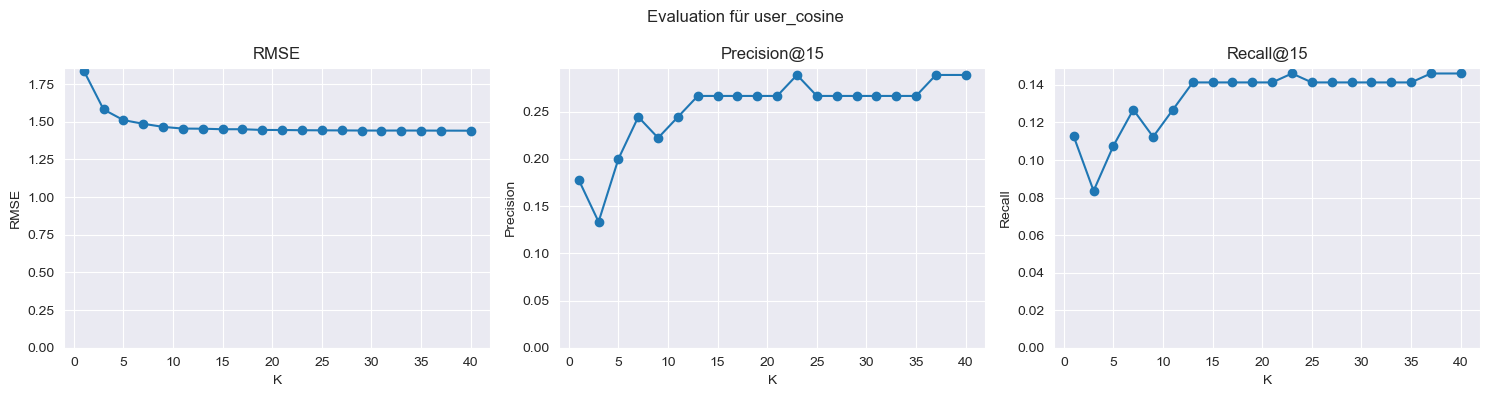

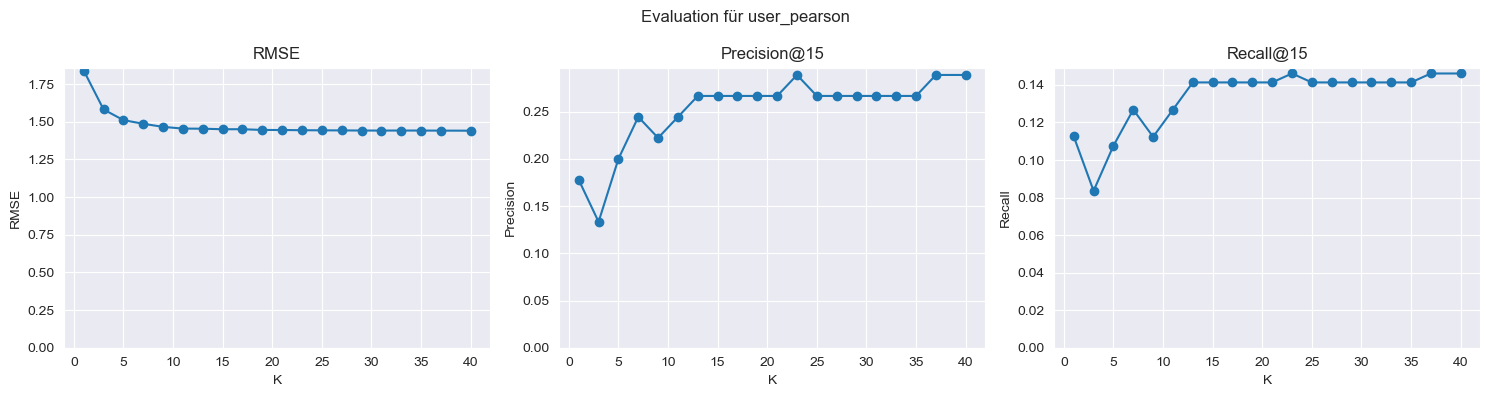

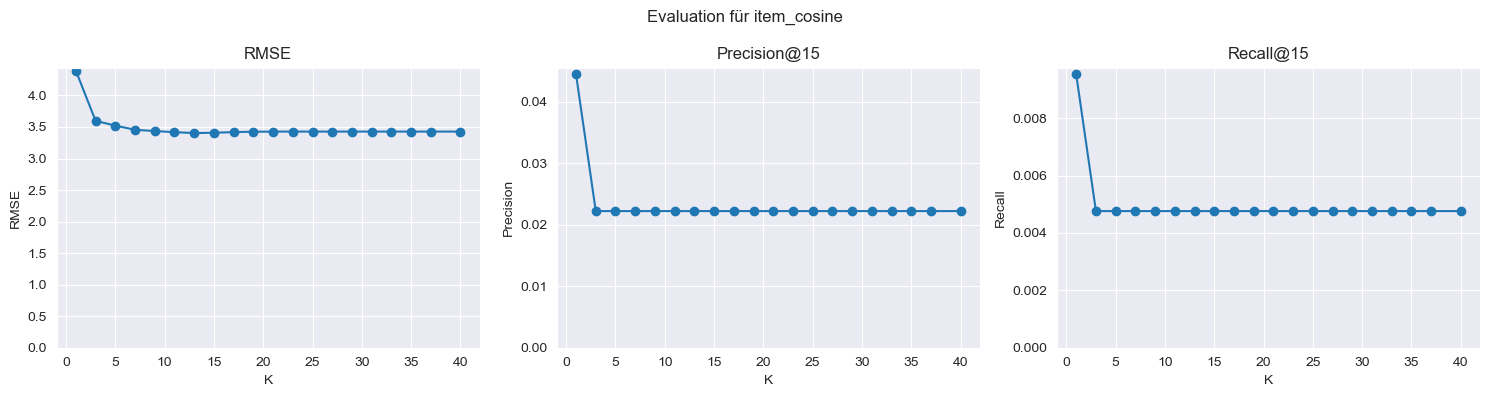

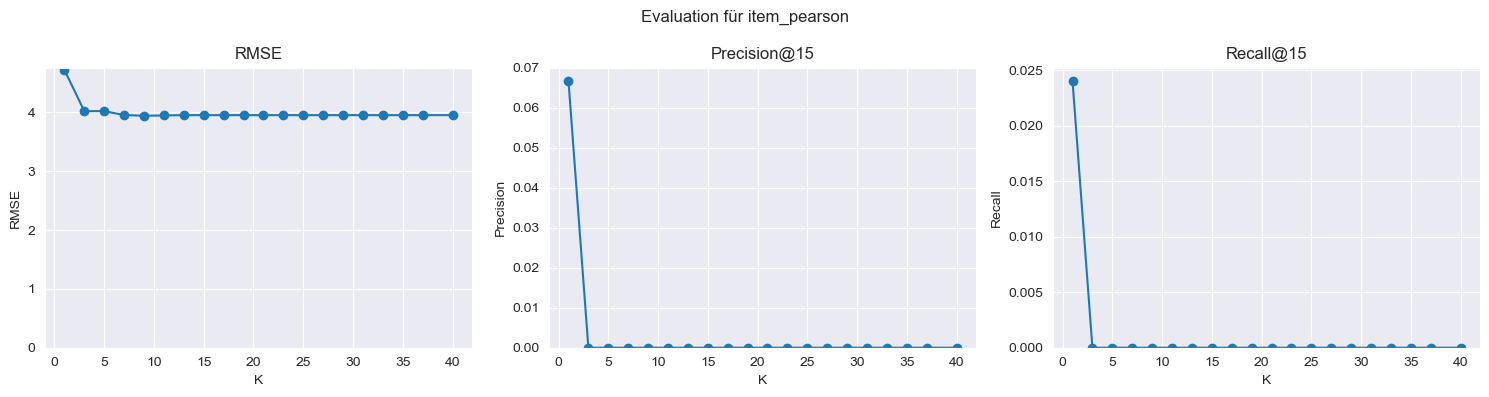

In [60]:
user_ids = [3,5,7]
urm_validate = create_urm(test_masked)
results = evaluate_rs_methods(user_ids, urm_validate, test, ks=np.linspace(1, 40, 20, dtype=int), N=15)
plot_metrics(results, N=15)

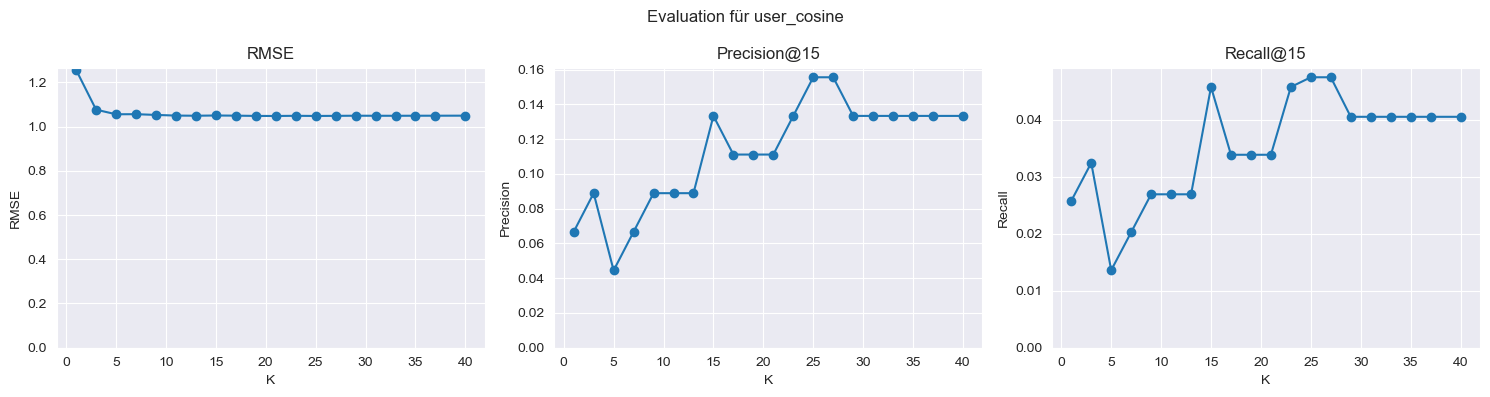

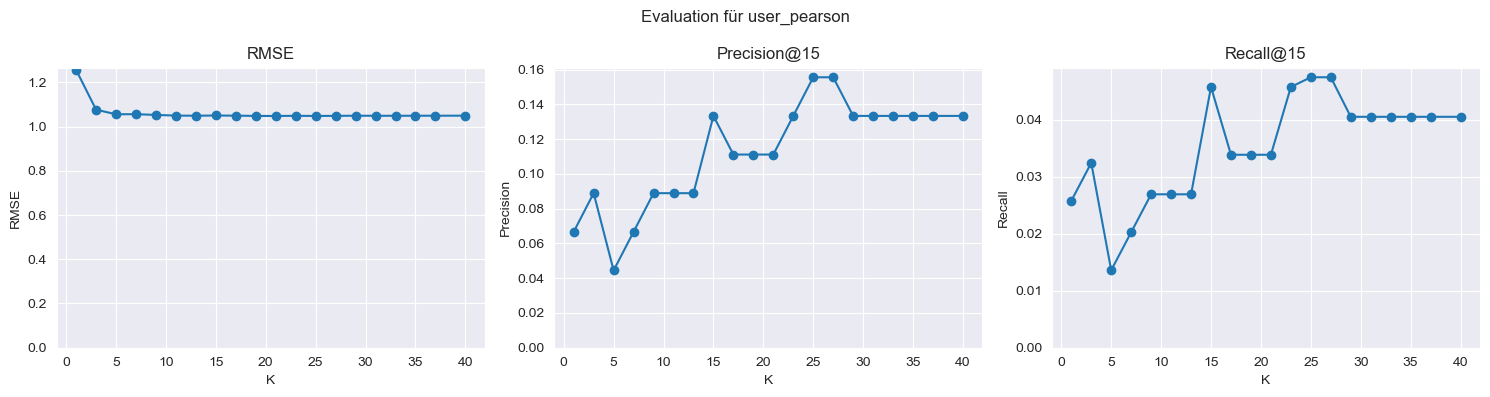

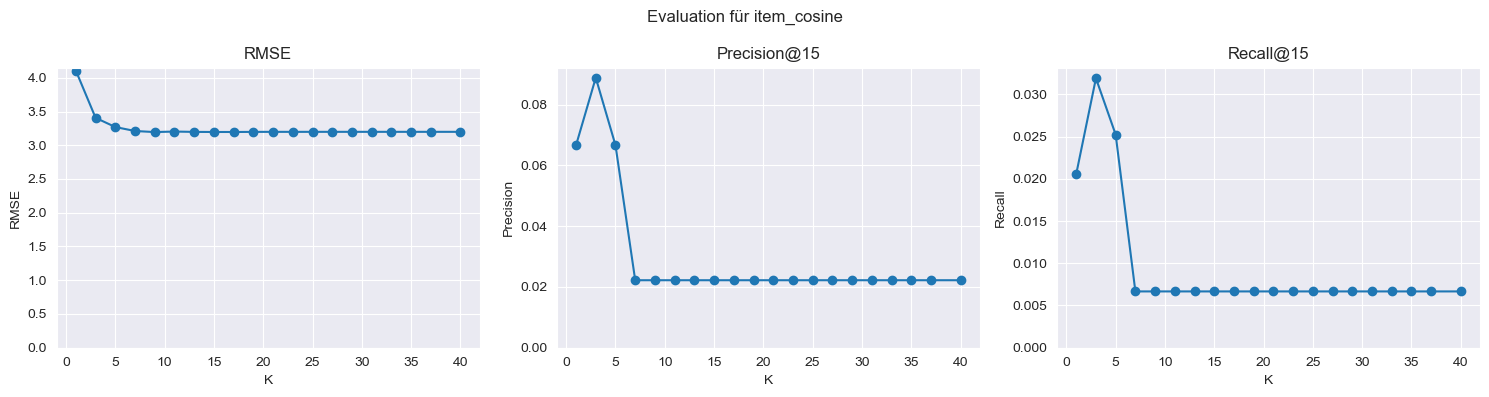

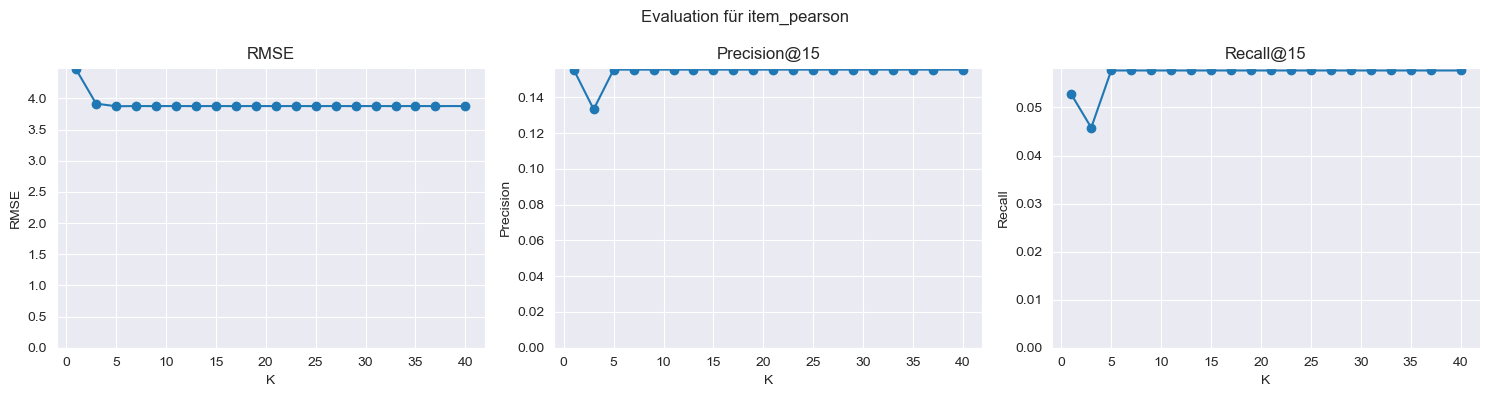

In [61]:
user_ids = [132,141,153]
urm_validate = create_urm(validate_masked_1)
results = evaluate_rs_methods(user_ids, urm_validate, validate_groundtruth_1, ks=np.linspace(1, 40, 20, dtype=int), N=15)
plot_metrics(results, N=15)

### Exercise 7 - Model-based RS: SVD (10 points)
In this exercise we will use the unsupervised method *singular value decomposition (SVD)* from the python package *surprise* (https://surpriselib.com, documentation https://surprise.readthedocs.io/en/stable/matrix_factorization.html). SVD can compress much of the information of a matrix in few components.  

a)Run the SVD RS and show the results on the three example users from exercise 2. Explain how this algorithm works.

Note: A very good general introduction to SVD is this youtube video series starting with https://www.youtube.com/watch?v=gXbThCXjZFM&t=337s . See *Collaborative filtering recommender systems* by Ekstrand et al. *Mining of massive datasets* by Leskovec, Kapitel 11 (2020) and, *Recommender systems: The textbook*, by Aggarwal, chapter 3

b) We explore now what latent factors SVD has learned. Generate three sorted lists: Sort the items by their biggest, second biggest and third biggest singlular value component. For each list print the top and bottom 20 items. What do you observe?

## Singular Value Decomposition (SVD)
Singular Value Decompistion (SVD) ist eine Methode zur Dimensionsreduktion von Daten. SVD nimmt hochdimensionale Daten und reduziert diese auf seine wichtigsten Features und Korrelationen. Ihre Anwendung findet sie unter anderem bei der Lösung von Gleichungssystemen, Bildkompression, Principal Component Analysis (PCA) und eben auch bei Recommender Systemen.

Die Grundidee von SVD ist es, eine  $m \times n$ Matrix $A$ in das Produkt dreier Matrizen zu zerlegen:

$$ A = U \Sigma V^T $$

Hierbei sind:
- $U$ eine $m \times m$ orthogonale Matrix, deren Spalten die linken Singulärvektoren von $A$ sind
- $\Sigma$ eine $m \times n$ Diagonalmatrix, deren Diagonalelemente in abnehmender Reihenfolge die Singulärwerte von $A$ sind. Diese können nur positive Werte annehmen.
- $V^T$ die transponierte Form einer $n \times n$ orthogonalen Matrix, deren Zeilen die rechten Singulärvektoren von $A$ sind

Bezogen auf Recommender Systeme wird SVD verwendet um die User-Item Matrix in diese drei Matrizen zu zerlegen. Die Matrix $U$ repräsentiert dann die User, die Matrix $V$ die Items. Diese Matrizen werden auch Latente Repräsentatioen genannt und enthalten die versteckten Merkmale der User und Items. Die Diagonalmatrix $\Sigma$ enthält die Gewichtungen dieser Merkmale.

Nachdem diese Matrizen erzeugt wurden, können die latenten Repräsentationen von Benutzern und Items in $U$ und $V^T$ genutzt werden, um Empfehlungen zu erstellen. Beispielsweise können ähnliche Benutzer oder Items durch Messen der Ähnlichkeit ihrer latenten Repräsentationen identifiziert werden. Ebenfalls kann vorhergesagt werden, wie ein Benutzer ein noch nicht bewertetes Item einschätzen würde, indem das Skalarprodukt der latenten Repräsentation des Benutzers in $U$ mit der des Items in $V^T$ gebildet wird.

Die Anzahl der Singulärwerte, die verwendet werden, um die User-Item-Matrix zu rekonstruieren, wird als Hyperparameter $k$ bezeichnet. Je grösser $k$ ist, desto genauer wird die Matrix rekonstruiert, jedoch steigt auch die Gefahr von Overfitting. Die Wahl von $k$ ist also ein wichtiger Aspekt bei der Anwendung von SVD.

SVD hat den Vorteil, dass es einfach zu interpretieren ist, auf jeder Matrix angewendet werden kann und gut auf grössere Datenmengen skaliert.

#### a)

In [62]:
# Daten vorbereiten
def prepare_data(df):
    reader = Reader(rating_scale=(0.5, 5))
    data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)
    trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
    return trainset, testset

# SVD Modell trainieren
def train_svd(trainset):
    svd = SVD(n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02)
    svd.fit(trainset)
    return svd

# Vorhersagen für einen Benutzer machen
def get_svd_recommendations(svd, df, user_id, movies, n=20):
    # Filme, die der Benutzer bereits bewertet hat
    rated_movies = df[df['userId'] == user_id]['movieId'].unique()
    
    # Alle Filme, die der Benutzer nicht bewertet hat
    all_movies = df['movieId'].unique()
    unrated_movies = [movie for movie in all_movies if movie not in rated_movies]
    
    # Vorhersagen machen
    predictions = []
    for movie_id in unrated_movies:
        pred = svd.predict(user_id, movie_id)
        predictions.append((movie_id, pred.est))
    
    # Nach höchster Bewertung sortieren
    predictions.sort(key=lambda x: x[1], reverse=True)
    
    # Top-N Empfehlungen ausgeben
    print(f"\nTop {n} SVD-Empfehlungen für Benutzer {user_id}:")
    for i, (movie_id, rating) in enumerate(predictions[:n], 1):
        movie_title = movies.loc[movies['movieId'] == movie_id, 'title'].values[0]
        print(f"{i}. {movie_title} - Vorhergesagte Bewertung: {rating:.2f}")

# Annahme: ratings und movies DataFrames sind bereits geladen
trainset, testset = prepare_data(training)
svd = train_svd(trainset)


example_users = [132,141,153]  # Beispiel-User-IDs anpassen

for user in example_users:
    get_svd_recommendations(svd, training, user, movies)


Top 20 SVD-Empfehlungen für Benutzer 132:
1. Raging Bull (1980) - Vorhergesagte Bewertung: 3.72
2. Apocalypse Now (1979) - Vorhergesagte Bewertung: 3.71
3. Grand Day Out with Wallace and Gromit, A (1989) - Vorhergesagte Bewertung: 3.70
4. Dawn of the Dead (1978) - Vorhergesagte Bewertung: 3.67
5. Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) - Vorhergesagte Bewertung: 3.67
6. Goodfellas (1990) - Vorhergesagte Bewertung: 3.67
7. Great Dictator, The (1940) - Vorhergesagte Bewertung: 3.66
8. Boot, Das (Boat, The) (1981) - Vorhergesagte Bewertung: 3.66
9. Lawrence of Arabia (1962) - Vorhergesagte Bewertung: 3.66
10. Streetcar Named Desire, A (1951) - Vorhergesagte Bewertung: 3.60
11. Citizen Kane (1941) - Vorhergesagte Bewertung: 3.60
12. On the Waterfront (1954) - Vorhergesagte Bewertung: 3.59
13. Last Detail, The (1973) - Vorhergesagte Bewertung: 3.57
14. Nausicaä of the Valley of the Wind (Kaze no tani no Naushika) (1984) - Vorhergesagte Bewertung: 3.57
15

Die Empfehlungen scheinen hier individueller zu sein, da die Benutzer unterschiedlichere Empfehlungen bekommen. Ausserdem gibt es nicht so viele hohe Sterne Bewertungen und auf den ersten Blick scheinen es auch eher bekanntere Filme zu sein, welche empfohlen werden.

### b)

In [63]:
# Berechne die Durchschnittsbewertungen je Film
avg_ratings = training.groupby("movieId")["rating"].mean().reset_index()
avg_ratings.columns = ["movieId", "avg_rating"]

# Zugriff auf die Item-Faktoren (q_i) im trainierten Modell
item_factors = svd.qi  # shape: (n_items, n_factors)
item_inner_ids = list(range(len(item_factors)))  # surprise-interne IDs
item_raw_ids = [svd.trainset.to_raw_iid(iid) for iid in item_inner_ids]  # movieId (als Strings!)

# Erstelle DataFrame mit Faktoren
item_df = pd.DataFrame(item_factors, columns=[f"f{i+1}" for i in range(item_factors.shape[1])])
item_df["movieId"] = item_raw_ids
item_df["movieId"] = item_df["movieId"].astype(int)  # Für Merge nötig

# Füge Titel, Genre und Durchschnittsbewertung hinzu
item_df = item_df.merge(movies[["movieId", "title", "genres"]], on="movieId", how="left")
item_df = item_df.merge(avg_ratings, on="movieId", how="left")

# Für die ersten 3 latenten Faktoren: sortiere Items nach deren Einfluss
for i in range(3):
    col = f"f{i+1}"
    sorted_items = item_df.sort_values(by=col, ascending=False)

    # Top 20
    top_20 = sorted_items.head(20)[["title", "avg_rating", "genres"]].copy()
    top_20["avg_rating"] = top_20["avg_rating"].round(2)
    top_20.columns = [f"Titel (Top 20 Filme nach Faktor {i+1}) ", "Durchschnittsbewertung", "Genre"]
    display(top_20)

    # Bottom 20
    bottom_20 = sorted_items.tail(20)[["title", "avg_rating", "genres"]].copy()
    bottom_20["avg_rating"] = bottom_20["avg_rating"].round(2)
    bottom_20.columns = [f"Titel (Bottom 20 Filme nach Faktor {i+1})", "Durchschnittsbewertung", "Genre"]
    display(bottom_20)

,Titel (Top 20 Filme nach Faktor 1),Durchschnittsbewertung,Genre
350,Invasion of the Body Snatchers (1956),3.77,Horror|Sci-Fi|Thriller
3794,Divine Secrets of the Ya-Ya Sisterhood (2002),3.12,Comedy|Drama
5631,"Ladies Man, The (2000)",1.58,Comedy
6467,"Crimson Rivers, The (Rivières pourpres, Les) (...",3.38,Crime|Drama|Mystery|Thriller
4887,Traitor (2008),3.50,Crime|Drama|Thriller
4968,Reality (2014),4.00,Comedy
97,Willy Wonka & the Chocolate Factory (1971),3.87,Children|Comedy|Fantasy|Musical
4452,Body Double (1984),2.50,Mystery|Thriller
606,M*A*S*H (a.k.a. MASH) (1970),3.96,Comedy|Drama|War
5754,RKO 281 (1999),3.50,Drama


,Titel (Bottom 20 Filme nach Faktor 1),Durchschnittsbewertung,Genre
3103,Little Dieter Needs to Fly (1997),5.00,Documentary
717,The Revenant (2015),4.14,Adventure|Drama
2569,Himizu (2011),3.50,Children|Crime|Drama
117,"Usual Suspects, The (1995)",4.21,Crime|Mystery|Thriller
4403,Pulse (2006),1.75,Action|Drama|Fantasy|Horror|Mystery|Sci-Fi|Thr...
7644,Random Harvest (1942),4.00,Drama|Romance
594,Volcano (1997),2.04,Action|Drama|Thriller
8116,"Ogre, The (Unhold, Der) (1996)",4.00,Drama
8087,"One-Armed Swordsman, The (Dubei dao) (1967)",3.00,Action|Drama
5718,Theremin: An Electronic Odyssey (1993),4.00,Documentary


,Titel (Top 20 Filme nach Faktor 2),Durchschnittsbewertung,Genre
4027,White Sands (1992),3.00,Drama|Thriller
3570,"Last Mimzy, The (2007)",3.00,Adventure|Children|Sci-Fi
6611,Sands of Iwo Jima (1949),2.50,Action|Drama|Romance|War
2192,"Brothers Grimm, The (2005)",2.53,Comedy|Fantasy|Horror|Thriller
3503,Love & Mercy (2014),4.00,Drama
3622,"Secret Lives of Dentists, The (2002)",4.00,Drama
983,Transformers: Revenge of the Fallen (2009),2.37,Action|Adventure|Sci-Fi|IMAX
5603,Dead Silence (2007),3.25,Horror|Mystery|Thriller
5491,"Duchess, The (2008)",3.67,Drama|Romance
8296,Exposed (2016),1.50,Drama


,Titel (Bottom 20 Filme nach Faktor 2),Durchschnittsbewertung,Genre
22,Scream (1996),3.21,Comedy|Horror|Mystery|Thriller
4011,Wolf (1994),3.00,Drama|Horror|Romance|Thriller
5587,Aces: Iron Eagle III (1992),2.00,Action
917,Hidalgo (2004),3.32,Adventure|Drama
7343,Shot Caller (2017),3.50,Action|Crime|Drama|Thriller
7517,Safe Haven (2013),4.00,Drama|Mystery|Romance
188,There's Something About Mary (1998),3.63,Comedy|Romance
4506,Christine (1983),2.95,Horror
2924,"ABCs of Death, The (2012)",3.50,Horror
5104,Ruby Sparks (2012),3.50,Comedy|Fantasy|Romance


,Titel (Top 20 Filme nach Faktor 3),Durchschnittsbewertung,Genre
1001,Far and Away (1992),2.93,Adventure|Drama|Romance
3555,Fitzcarraldo (1982),3.38,Adventure|Drama
3051,"Next Three Days, The (2010)",3.75,Crime|Drama|Romance|Thriller
6531,Jason Bourne (2016),2.69,Action
5598,Stranger Than Paradise (1984),3.92,Comedy|Drama
1057,Blade Runner (1982),4.08,Action|Sci-Fi|Thriller
2343,"Toxic Avenger, Part II, The (1989)",3.00,Comedy|Horror
6724,Houseboat (1958),2.00,Comedy|Romance
2060,Thunderbirds (2004),2.75,Action|Adventure|Fantasy|Sci-Fi
5584,Mickey's The Prince and the Pauper (1990),2.00,Animation|Children


,Titel (Bottom 20 Filme nach Faktor 3),Durchschnittsbewertung,Genre
3967,"Allnighter, The (1987)",1.00,Comedy|Romance
8254,Boy Meets Girl (1984),3.00,Drama
3047,Henry: Portrait of a Serial Killer (1986),3.92,Crime|Horror|Thriller
854,Rise of the Planet of the Apes (2011),3.41,Action|Drama|Sci-Fi|Thriller
4565,Half Nelson (2006),3.67,Drama
255,Austin Powers: The Spy Who Shagged Me (1999),3.23,Action|Adventure|Comedy
2086,She's Out of My League (2010),2.92,Comedy
6591,Old Dogs (2009),0.50,Comedy
59,Iron Man (2008),3.92,Action|Adventure|Sci-Fi
4922,Flash Gordon (1980),3.29,Action|Adventure|Sci-Fi


Anhand er Ausgaben kann ich persönlich kein wirkliches Muster erkennen, dafür kenne ich zuwenig Filme. Aber ich vermute anhand der Genres dass in Faktor 3 eher Action gegen Comedy/Drama verglichen wird. Beim Faktor 2 erkenne ich lediglich, dass in beiden Listen viel das Genres Comedy vertreten ist. Aber bei Faktor 1 erkenne ich überhaupt nichts.

Laut meiner Recherche, sollten die 3 Faktoren folgendes machen:
- Der **erste Faktor** spiegelt die dominanten, allgemeinen Vorlieben der Nutzer wider. Dieser Faktor erfasst die grösste Varianz in den Bewertungen und könnte populäre oder Mainstream-Filme widerspiegeln, die von vielen Nutzern hoch bewertet werden. Filme, die in diesem Faktor hohe Werte haben, sind typischerweise beliebt und werden von einer breiten Zuschauergruppe geschätzt.
- Der **zweite Faktor** hingegen erfasst spezifischere Vorlieben der Nutzer, wie bestimmte Genres oder Filmstile. Hierbei geht es weniger um populäre Filme im Allgemeinen, sondern um Präferenzen, die mit bestimmten Genres.Dieser Faktor könnte eine Sub-Präferenz darstellen, die in den Bewertungen der Nutzer zum Tragen kommt, und ermöglicht es dem Modell, Filme zu empfehlen, die zu den bevorzugten Genres eines Nutzers passen.
- Der **dritte Faktor** beschreibt eine noch spezifischere Dimension der Nutzerpräferenzen. Dieser Faktor erfasst eher Nischeninteressen oder weniger offensichtliche Filmmerkmale. Es geht hierbei oft um besondere kulturelle Merkmale, künstlerische Filme oder weniger Mainstream-Inhalte, die von einer spezifischen Nutzergruppe geschätzt werden. Filme, die in diesem Faktor hoch bewertet werden, könnten beispielsweise künstlerisch anspruchsvolle oder philosophische Werke sein, die nur von einer kleineren Zielgruppe bevorzugt werden.

### Exercise 8 - Optimize hyperparameter $k$ or `n_factors` (4 points)
Optimize the hyperparameter, representing the number of greatest SVD components used for the truncated reconstruction of the user item matrix, to minimize RMSE.
Plot RMSE, Precision@N and Recall@N as a function of this hyperparameter. Finally output all performance metrics from exercise 3 for the optimal $k$ value.

n_factors=1 | RMSE=0.8705 | Precision@10=0.5663 | Recall@10=0.3021
n_factors=2 | RMSE=0.8707 | Precision@10=0.5690 | Recall@10=0.3038
n_factors=3 | RMSE=0.8700 | Precision@10=0.5703 | Recall@10=0.2997
n_factors=4 | RMSE=0.8703 | Precision@10=0.5668 | Recall@10=0.2986
n_factors=5 | RMSE=0.8703 | Precision@10=0.5681 | Recall@10=0.3024
n_factors=6 | RMSE=0.8717 | Precision@10=0.5625 | Recall@10=0.3001
n_factors=7 | RMSE=0.8706 | Precision@10=0.5736 | Recall@10=0.3026
n_factors=8 | RMSE=0.8700 | Precision@10=0.5660 | Recall@10=0.3002
n_factors=9 | RMSE=0.8704 | Precision@10=0.5705 | Recall@10=0.3033
n_factors=10 | RMSE=0.8697 | Precision@10=0.5706 | Recall@10=0.3004
n_factors=11 | RMSE=0.8700 | Precision@10=0.5723 | Recall@10=0.2998
n_factors=12 | RMSE=0.8717 | Precision@10=0.5707 | Recall@10=0.2973
n_factors=13 | RMSE=0.8709 | Precision@10=0.5727 | Recall@10=0.3003
n_factors=14 | RMSE=0.8704 | Precision@10=0.5743 | Recall@10=0.3013
n_factors=15 | RMSE=0.8715 | Precision@10=0.5704 | Recall

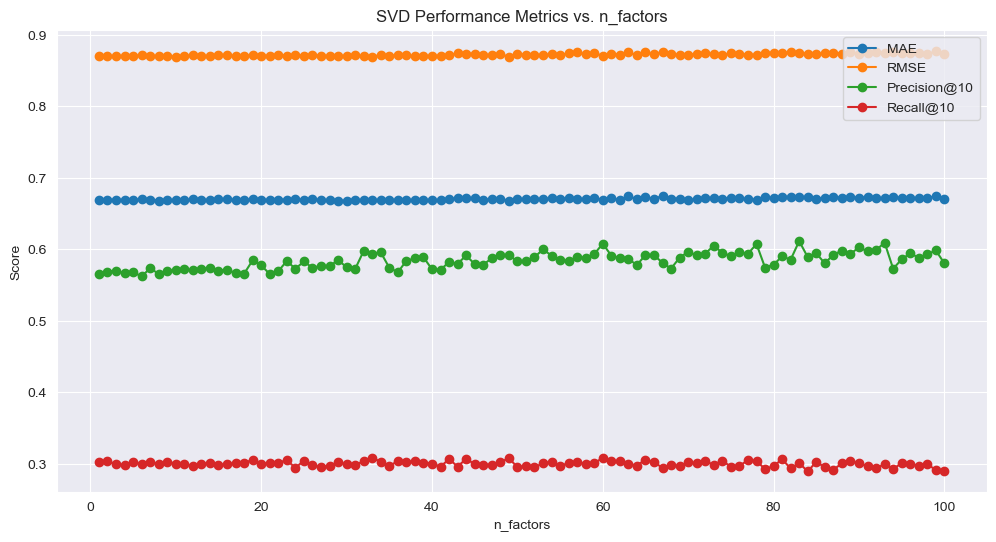

(0.6687184163832104, 0.8696052612494679, 0.5941064386784638, 0.308661155296434)

In [64]:
# Precision@N und Recall@N berechnen
def get_top_n(predictions, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n


def optimize_n_factors(ratings, n_factors_list, k=10, printen = "ja", plotten = "ja"):
    trainset, testset = prepare_data(ratings)
    
    mae_list = []
    rmse_list = []
    precision_list = []
    recall_list = []

    for n_factors in n_factors_list:
        svd = SVD(n_factors=n_factors, n_epochs=20, lr_all=0.005, reg_all=0.02)
        svd.fit(trainset)
        predictions = svd.test(testset)

        # MAE und RMSE
        mae = accuracy.mae(predictions, verbose=False)
        rmse = accuracy.rmse(predictions, verbose=False)

        # Precision/Recall Vorbereitung
        user_preds = defaultdict(list)
        user_truths = defaultdict(list)

        for pred in predictions:
            user_preds[pred.uid].append((pred.iid, pred.est))
            user_truths[pred.uid].append((pred.iid, pred.r_ui))

        precision, recall = precision_recall_at_n(user_preds, user_truths, N=k, threshold=4.0)
        
        mae_list.append(mae)
        rmse_list.append(rmse)
        precision_list.append(precision)
        recall_list.append(recall)
        
        if printen == "ja":
            print(f"n_factors={n_factors} | RMSE={rmse:.4f} | Precision@{k}={precision:.4f} | Recall@{k}={recall:.4f}")
    
    # Bestes Ergebnis
    best_idx = np.argmin(rmse_list)
    best_n_factors = n_factors_list[best_idx]
    print(f"\nOptimaler n_factors: {best_n_factors}")
    print(f"Beste MAE: {mae_list[best_idx]:.4f}")
    print(f"Beste RMSE: {rmse_list[best_idx]:.4f}")
    print(f"Precision@{k}: {precision_list[best_idx]:.4f}")
    print(f"Recall@{k}: {recall_list[best_idx]:.4f}")
    
         # Plotten
    if plotten == "ja":
        plt.figure(figsize=(12, 6))
        plt.plot(n_factors_list, mae_list, label="MAE", marker='o')
        plt.plot(n_factors_list, rmse_list, label="RMSE", marker='o')
        plt.plot(n_factors_list, precision_list, label=f"Precision@{k}", marker='o')
        plt.plot(n_factors_list, recall_list, label=f"Recall@{k}", marker='o')
        plt.xlabel("n_factors")
        plt.ylabel("Score")
        plt.title("SVD Performance Metrics vs. n_factors")
        plt.legend()
        plt.grid(True)
        plt.show()

    
    return mae_list[best_idx], rmse_list[best_idx], precision_list[best_idx], recall_list[best_idx]

# Beispiel-Aufruf:
n_factors_range = np.linspace(1, 100, 100, dtype=int)
optimize_n_factors(training, n_factors_range, k=10)

### Exercise 9 - Everything goes (30 points)
In this exercise you can explore different methods of RS. You are not limited what methods you apply. You can try to improve the methods from the earlier exercises by modifiying them or generating ensemble or hybrid RS. Also you could train deep neural networks, use NLP methods, use the available links to imdb available in the dataset to further enrich the dataset or find an obscure method by someone else on Github. 
Document what your inspirations and sources are and describe the method conceptually. 

**Build and optimize in total *three* different methods. The last one has the additional requirement that it should increase the diversity of the recommendations in order to minimize filter bubbles.**

**Important: If you use the work of someone else you must be able to explain the method conceptually during the defense MSP.** 

Output the performance metrics of exercise 3. 

# Hybrides k-NN-Recommendersystem

Ich wollte ein Recommender-System entwickeln, das nicht nur auf den Bewertungen der Nutzer basiert, sondern zusätzlich auch die Genres berücksichtigt, die der Nutzer bewertet hat. Dies ist ein hybrides Modell, das Collaborative Filtering (k-NN mit Mittelwerten) mit Content-based Filtering kombiniert.

Im traditionellen k-NN-Recommender-System wird die Ähnlichkeit zwischen Nutzern ausschliesslich auf Basis der Bewertungen berechnet. Ich habe jedoch die Hypothese, dass es wahrscheinlicher ist, dass ein Nutzer seinen bevorzugten Genres treu bleibt, die er gut bewertet hat. Zum Beispiel wäre es wenig sinnvoll, einem Nutzer, der vor allem Dramen mag, einen Horrorfilm vorzuschlagen, nur weil ein anderer Nutzer ähnliche Bewertungen für beide Genre-Kategorien abgegeben hat.

Aus diesem Grund fügt mein hybrides Modell eine zusätzliche Komponente hinzu: die Genrepräferenzen. Wenn ein Nutzer in einem bestimmten Genre wie „Drama“ tendenziell hohe Bewertungen abgibt, wird diese Präferenz in die Ähnlichkeitsberechnung einbezogen. Die Empfehlung basiert also nicht nur auf den gemeinsamen Bewertungen von ähnlichen Nutzern, sondern auch auf den ähnlichen Genre-Vorlieben, was die Genauigkeit und Relevanz der Empfehlungen verbessert.

Die Hauptfunktionen des Systems beinhalten:

- Berechnung der Genrepräferenzen für jeden Nutzer auf Basis seiner Bewertungen. Dies ermöglicht es, die Vorlieben jedes Nutzers für bestimmte Filmgenres zu ermitteln.

- Hybride Ähnlichkeitsberechnung, die die Bewertungsähnlichkeit sowie die Genreähnlichkeit zwischen Nutzern berücksichtigt. Durch die Gewichtung der beiden Ähnlichkeiten kann das Modell zwischen den beiden Aspekten balancieren (z. B. Bewertungen vs. Genres).

- KNNWithMeans (k-Nearest Neighbors), das für die Berechnung der Ähnlichkeiten verwendet wird, wobei das Gewicht für Genrepräferenzen konfigurierbar ist (z.B. genre_weight=0.3).

In [65]:
def calculate_user_genre_prefs_(df, movies):
    #Jedes Genre erhält hier eine eigene Spalte und wird mit 1 oder 0 befüllt, je nachdem ob es für den Film vorhanden ist oder nicht.
    genre_columns = movies['genres'].str.get_dummies('|')
    movie_genres = pd.concat([movies['movieId'], genre_columns], axis=1)
    #Ratings und Movies zusammenführen in ein Dataframe
    df_with_genres = df.merge(movie_genres, on='movieId')
    
    #leeres Dict anlegen um danach die durchschnittlichen Bewertungen der Genre zu speichern
    user_genre_prefs = defaultdict(dict)
    for user_id, group in df_with_genres.groupby('userId'):
        #über jedes Genres iterieren
        for genre in genre_columns.columns:
            #Abfrage ob der nutzer dieses Genre bereits bewertet hat
            if genre in group.columns:
                #alle Bewertungen für deses genre filtern
                genre_ratings = group[group[genre] == 1]['rating']
                #Wenn Bewertung vorhanden, Mittlewert berechnen
                if len(genre_ratings) > 0:
                    user_genre_prefs[user_id][genre] = genre_ratings.mean()
    return user_genre_prefs

def mean_absolute_error_knn(predictions):
    true_ratings = [pred.r_ui for pred in predictions]
    estimated_ratings = [pred.est for pred in predictions]
    return np.mean(np.abs(np.array(true_ratings) - np.array(estimated_ratings)))

def root_mean_square_error_knn(predictions):
    true_ratings = [pred.r_ui for pred in predictions]
    estimated_ratings = [pred.est for pred in predictions]
    return np.sqrt(np.mean((np.array(true_ratings) - np.array(estimated_ratings))**2))

def get_top_n(predictions, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

def precision_recall_at_n_knn(predictions, threshold=4.0, n=15):
    top_n = get_top_n(predictions, n=n)
    true_relevant = defaultdict(set)
    for uid, iid, true_r, _, _ in predictions:
        if true_r >= threshold:
            true_relevant[uid].add(iid)

    precisions, recalls = [], []
    for uid, user_ratings in top_n.items():
        recommended = set(iid for (iid, est) in user_ratings if est >= threshold)
        relevant = true_relevant.get(uid, set())
        precisions.append(len(recommended & relevant) / len(recommended) if recommended else 0)
        recalls.append(len(recommended & relevant) / len(relevant) if relevant else 0)

    return np.mean(precisions), np.mean(recalls)

def prepare_data_knn_with_genres_(df, movies):
    reader = Reader(rating_scale=(0.5, 5))
    data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)
    data.genre_prefs = calculate_user_genre_prefs_(df, movies)
    return data, *train_test_split(data, test_size=0.2, random_state=42)

def train_knn_optimized_with_genres_(data):
    param_grid = {
        'k': list(np.linspace(1, 50, 10, dtype=int)),# k-Werte von 1 bis 50
        'sim_options': {
            'name': ['cosine'],
            'user_based': [True],
            'min_support': [3] # Mindestens 3 gemeinsame Bewertungen
        }
    }
    gs = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse'], cv=5, refit=True)
    gs.fit(data)
    print(f"Beste Parameter: k={gs.best_params['rmse']['k']}")
    return gs.best_estimator['rmse']

# ------------------------------------------------
# 4. Empfehlungen generieren mit Genre-Boost
# ------------------------------------------------
def get_knn_recommendations_with_genre_boost_(model, df, user_id, movies, genre_prefs, n=20, genre_weight=0.3):
    #Alle Filme die der nutzer noch nicht bewertet hat bestimmen
    rated_movies = df[df['userId'] == user_id]['movieId'].unique()
    all_movies = df['movieId'].unique()
    unrated_movies = [movie for movie in all_movies if movie not in rated_movies]

    recommendations = []
    
    for movie_id in unrated_movies:
        #Bewertung schätzen
        est_rating = model.predict(user_id, movie_id).est
        movie_info = movies[movies['movieId'] == movie_id].iloc[0]
        movie_genres = movie_info['genres'].split('|')

        genre_scores = [genre_prefs.get(user_id, {}).get(genre, None) for genre in movie_genres]
        genre_scores = [score for score in genre_scores if score is not None]

        if genre_scores:
            genre_avg = np.mean(genre_scores)
            genre_boost = (genre_avg - 3.0) / 2.0  # Skaliert auf ~[-1, 1]
        else:
            genre_boost = 0
        # Finalen Score berechnen (Kombination aus Modellbewertung und Genre-Boost)
        final_score = (1 - genre_weight) * est_rating + genre_weight * (est_rating + genre_boost)
        recommendations.append((movie_id, final_score))

    recommendations.sort(key=lambda x: x[1], reverse=True)

    top_recommendations = []
    for i, (movie_id, rating) in enumerate(recommendations[:n], 1):
        movie_info = movies[movies['movieId'] == movie_id].iloc[0]
        title = movie_info['title']
        genres = movie_info['genres']
        top_recommendations.append(f"{i}. {title} ({genres}) - Score: {rating}")
    
    return top_recommendations

In [66]:
data, trainset, testset = prepare_data_knn_with_genres_(training, movies)

# k-NN Modell trainieren
model = train_knn_optimized_with_genres_(data)
model.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing th

In [67]:
# Vorhersagen generieren
predictions = model.test(testset)

# Fehlermasse berechnen
mae = mean_absolute_error_knn(predictions)
rmse = root_mean_square_error_knn(predictions)
precision, recall = precision_recall_at_n_knn(predictions, threshold=4.0, n=15)

print("\nMetriken mit Genre-Integration:")
print(f"MAE: {mae:.4f} | RMSE: {rmse:.4f}")
print(f"Precision@15: {precision:.4f} | Recall@15: {recall:.4f}")

# Genre-Präferenzen berechnen
genre_prefs = calculate_user_genre_prefs_(training, movies)


Metriken mit Genre-Integration:
MAE: 0.6954 | RMSE: 0.9107
Precision@15: 0.5503 | Recall@15: 0.3660


In [68]:
example_users = [132,141,153]
for user in example_users:
    print(f"\n Empfehlungen für User {user}:\n" + "-"*40)
    recommendations = get_knn_recommendations_with_genre_boost_(
    model=model,
    df=training,
    user_id=user,
    movies=movies,
    genre_prefs=genre_prefs,
    n=20,                  # Anzahl empfohlener Filme
    genre_weight=0.4       # Einfluss der Genre-Vorliebe (0.0 = ignoriert, 1.0 = nur Genre)
)
    # Empfehlungen ausgeben
    for rec in recommendations:
        print(rec)



 Empfehlungen für User 132:
----------------------------------------
1. Come and See (Idi i smotri) (1985) (Drama|War) - Score: 5.054923325262308
2. Beloved (1998) (Drama) - Score: 5.038418079096045
3. Panic (2000) (Drama) - Score: 5.038418079096045
4. Holy Mountain, The (Montaña sagrada, La) (1973) (Drama) - Score: 5.038418079096045
5. Villain (1971) (Crime|Drama|Thriller) - Score: 5.038287651749839
6. Frank (2014) (Comedy|Drama|Mystery) - Score: 5.020156453715776
7. Bossa Nova (2000) (Comedy|Drama|Romance) - Score: 5.015302652546185
8. Match Factory Girl, The (Tulitikkutehtaan tyttö) (1990) (Comedy|Drama) - Score: 5.010234680573664
9. Jetée, La (1962) (Romance|Sci-Fi) - Score: 5.000524176294395
10. Paterson ((no genres listed)) - Score: 5.0
11. Seve (2014) (Documentary|Drama) - Score: 4.994209039548022
12. The Big Bus (1976) (Action|Comedy) - Score: 4.9829899267399265
13. Wonder (2017) (Drama) - Score: 4.889338835028613
14. Neon Genesis Evangelion: Death & Rebirth (Shin seiki Evange

# Content-based (TF-IDF + Cosine)

Weil ich im movies Datensatz keine ausführlichen Inhaltsbeschreibungen wie beispielsweise eine overview-Spalte hatte, habe ich aus dem Titel und den Genres eine neue Spalte namens content erstellt. Diese Spalte habe ich verwendet, um eine Textrepräsentation jedes Films zu erzeugen – also im Prinzip ein einfacher beschreibender Text pro Film, bestehend aus Titel und Genren.

Anschliesend habe ich das sogenannte TF-IDF-Verfahren (Term Frequency–Inverse Document Frequency) angewendet. Dieses Verfahren hilft mir dabei, die Relevanz von Wörtern im Kontext aller Filmtexte zu bestimmen. Ich habe dazu den "TfidfVectorizer" von "scikit-learn" verwendet, wobei ich englische Stoppwörter ignoriert habe, damit Wörter wie „the“, „and“ oder „of“ keinen Einfluss auf die Ähnlichkeitsbewertung haben. Aus der so berechneten TF-IDF-Matrix habe ich dann mithilfe der Cosine Similarity ermittelt, wie ähnlich sich die Filme untereinander sind – basierend auf ihren Textinhalten.

Danach habe ich eine Funktion geschrieben, die für einen bestimmten Nutzer, eine definierte Anzahl, Empfehlungen generiert. Zuerst filtere ich die Filme heraus, die dieser Nutzer bereits bewertet hat. Für jeden dieser bewerteten Filme ermittle ich dann ähnliche Filme aus der Cosine-Similarity-Matrix - also Filme, die laut Inhalt dem bewerteten Film ähnlich sind. Ich achte darauf, dass der aktuell betrachtete Film selbst sowie bereits bewertete Filme nicht erneut empfohlen werden.

Für die gefundenen ähnlichen Filme schätze ich dann eine Bewertung, die der Nutzer ihnen wahrscheinlich geben würde. Dazu berechne ich einen gewichteten Durchschnitt der Bewertungen, die der Nutzer bereits abgegeben hat – gewichtet nach der Ähnlichkeit zwischen dem ähnlichen Film und den bereits bewerteten Filmen. Je stärker ein Film einem bereits positiv bewerteten ähnelt, desto mehr Einfluss hat diese Bewertung auf die Vorhersage.

Zum Schluss fasse ich alle gefundenen Empfehlungen in einem DataFrame zusammen, entferne doppelte Filme (falls mehrere ähnliche Treffer auf denselben Film führen), sortiere sie nach der vorhergesagten Bewertung und gebe die Top-N Empfehlungen zurück.

In [69]:

# Vorberechnungen
movies['content'] = movies['title'].fillna('') + ' ' + movies['genres'].fillna('')
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(movies['content'])
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
movie_id_to_idx = {movie_id: idx for idx, movie_id in enumerate(movies['movieId'])}

def content_based_recommendations(ratings, movies, user_id):
    # User-Daten vorberechnen
    user_ratings = ratings[ratings['userId'] == user_id]
    rated_movie_ids = user_ratings['movieId'].tolist()
    
    # Indizes der bewerteten Filme (mit Fehlerbehandlung)
    rated_indices = [movie_id_to_idx[m_id] for m_id in rated_movie_ids if m_id in movie_id_to_idx]
    if not rated_indices:
        return pd.DataFrame()  # Keine Bewertungen gefunden
    
    # Matrix-Operationen für Vorhersagen
    sim_matrix = cosine_sim[rated_indices]
    ratings_vector = user_ratings['rating'].values
    
    weighted_ratings = np.dot(ratings_vector, sim_matrix)
    similarity_sums = np.sum(sim_matrix, axis=0)
    
    predicted_ratings = np.divide(weighted_ratings, similarity_sums,
                                out=np.zeros_like(weighted_ratings),
                                where=similarity_sums!=0)
    
    # Ergebnisse sammeln
    movie_indices = np.argsort(-predicted_ratings)  # Buffer für Duplikate
    recommendations = []
    seen_movies = set(rated_movie_ids)
    
    for idx in movie_indices:
        movie_id = movies.iloc[idx]['movieId']
        if movie_id not in seen_movies:
            recommendations.append({
                'movieId': movie_id,
                'title': movies.iloc[idx]['title'],
                'genres': movies.iloc[idx]['genres'],
                'predicted_rating': predicted_ratings[idx]
            })
            seen_movies.add(movie_id)
            
                
    return pd.DataFrame(recommendations)

def get_top_n_recommendations_for_users(ratings, movies, user_ids, n=10):
    all_recommendations = []
    
    # Für jeden User die Empfehlungen berechnen
    for user_id in user_ids:
        print(f"Berechne Empfehlungen für User {user_id}...")
        
        # Empfehlungen für diesen User holen
        recommendations = content_based_recommendations(ratings, movies, user_id)
        
        if not recommendations.empty:
            # Sortiere nach predicted_rating und nimm die Top-N
            recommendations = recommendations.sort_values(by='predicted_rating', ascending=False).head(n)
            all_recommendations.append((user_id, recommendations))
        else:
            print(f"Keine Bewertungen für User {user_id}")
    
    return all_recommendations

In [70]:
# Beispiel-User-IDs
example_users = [124, 130, 139]

# Top-N Empfehlungen für mehrere Benutzer holen
recommendations_for_users = get_top_n_recommendations_for_users(ratings=training, 
                                                               movies=movies, 
                                                               user_ids=example_users, 
                                                               n=20)

# Empfehlungen für jeden Benutzer ausgeben
for user_id, recommendations in recommendations_for_users:
    print(f"\nEmpfohlene Filme für User {user_id}:")
    for idx, row in recommendations.iterrows():
        print(f"{row['title']}, Genres: {row['genres']}, Vorhergesagte Bewertung: {row['predicted_rating']:.2f}")



Berechne Empfehlungen für User 124...
Berechne Empfehlungen für User 130...
Berechne Empfehlungen für User 139...

Empfohlene Filme für User 124:
A Midsummer Night's Dream (2016), Genres: (no genres listed), Vorhergesagte Bewertung: 5.00
When the Levees Broke: A Requiem in Four Acts (2006), Genres: Documentary, Vorhergesagte Bewertung: 5.00
Requiem for the American Dream (2015), Genres: Documentary, Vorhergesagte Bewertung: 4.90
As I Was Moving Ahead Occasionally I Saw Brief Glimpses of Beauty (2000), Genres: Documentary, Vorhergesagte Bewertung: 4.89
Trevor Noah: African American (2013), Genres: (no genres listed), Vorhergesagte Bewertung: 4.76
American Hardcore (2006), Genres: Documentary, Vorhergesagte Bewertung: 4.76
When We Were Kings (1996), Genres: Documentary, Vorhergesagte Bewertung: 4.75
Haunted World of Edward D. Wood Jr., The (1996), Genres: Documentary, Vorhergesagte Bewertung: 4.75
Hype! (1996), Genres: Documentary, Vorhergesagte Bewertung: 4.75
The Natural Love (1996), G

# Hybrid mit MMR
Für mein Filmempfehlungssystem wollte ich nicht nur passende, sondern auch abwechslungsreiche Vorschläge machen. Deshalb habe ich einen Hybrid-Ansatz entwickelt, der content-basierte Filterung mit dem MMR-Algorithmus (Maximal Marginal Relevance) kombiniert.

Zuerst musste ich, wie zuvor beim "Content-Based (TF-IDF + Cosine) ansatz, eine brauchbare Textgrundlage schaffen und ich erstellte eine weitere Spalte mit dem Titel Content. 

Diese Texte habe ich dann ebenfalls mit TF-IDF vektorisiert, die englischen Stoppwörter entfernt. Heraus kam eine Ähnlichkeitsmatrix, die mir zeigt, wie verwandt die Filme inhaltlich sind.

Das Besondere an meinem Ansatz ist die MMR-Komponente. Zuerst lasse ich mir beispielsweise 50 Filme vorschlagen, die dem Nutzer gefallen könnten - basierend auf seinen bisherigen Bewertungen. Aber statt einfach die Top 10 mit der höchsten vorhergesagten Bewertung zu nehmen, durchläuft diese Liste den MMR-Algorithmus.

Hier kommt der entscheidende Trick: Für jeden Film berechne ich nicht nur, wie gut er zum Nutzerprofil passt (Relevanz), sondern auch wie ähnlich er den bereits ausgewählten Filmen ist. Durch den Lambda-Parameter kann ich steuern, wie stark die Vielfalt gewichtet wird. Bei λ=0.7 lege ich etwas mehr Wert auf Relevanz, aber sorge trotzdem für Abwechslung.

Praktisch bedeutet das: Wenn ein Nutzer viele Sci-Fi-Filme mag, bekommt er nicht nur weitere Sci-Fi-Empfehlungen, sondern vielleicht auch einen thematisch verwandten Thriller oder ein Drama (Kann auch mit ähnlichen Schauspielern erweitert werden). So wird die Vorschlagsliste interessanter, ohne an Personalisierung zu verlieren.

Der Code implementiert dies durch eine schrittweise Auswahl. In jeder Runde wird der Film mit dem besten MMR-Score (Relevanz minus Ähnlichkeit zu bereits Gewählten) zur endgültigen Empfehlungsliste hinzugefügt. Das Ergebnis sind Top-N Filme, die sowohl zum Geschmack des Nutzers passen als auch untereinander vielfältig sind.

Was ich besonders gut finde: Das System vermeidet so diese typischen Filterblasen, wo man nur noch Variationen des Gleichen vorgeschlagen bekommt. Stattdessen entdeckt man auch mal was Neues, das trotzdem zum eigenen Geschmack passt.

In [71]:
# Step 1: Content-Spalte aus Titel + Genres erstellen
movies['content'] = movies['title'].fillna('') + ' ' + movies['genres'].fillna('')

# Step 2: TF-IDF Vektorisierung
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(movies['content'])

def select_top_n(candidate_movie_ids, relevance_scores, tfidf_subset, top_n, lambda_param):
    selected = []
    candidate_idxs = list(range(len(candidate_movie_ids)))

    while len(selected) < top_n and candidate_idxs:
        mmr_scores = []
        for idx in candidate_idxs:
            relevance = relevance_scores[idx]
            if selected:
                selected_vecs = tfidf_subset[selected]
                sim_to_selected = cosine_similarity(tfidf_subset[idx], selected_vecs).max()
            else:
                sim_to_selected = 0

            mmr_score = lambda_param * relevance - (1 - lambda_param) * sim_to_selected
            mmr_scores.append((idx, mmr_score))

        # Wähle den Kandidaten mit dem höchsten MMR-Score
        best_idx, _ = max(mmr_scores, key=lambda x: x[1])
        selected.append(best_idx)
        candidate_idxs.remove(best_idx)

    # Rückgabe: ausgewählte Filme
    return [candidate_movie_ids[i] for i in selected]


def calculate_mmr_scores(urm, movies, user_id, tfidf_matrix, lambda_param=0.7, max_recommendations=None):
    if user_id not in urm.index:
        return [], []  # Keine Empfehlungen möglich

    all_movie_ids = urm.columns.tolist()
    user_ratings = urm.loc[user_id].dropna()

    rated_movie_ids = set(user_ratings.index)
    candidate_movie_ids = [mid for mid in all_movie_ids if mid not in rated_movie_ids]

    if max_recommendations:
        candidate_movie_ids = candidate_movie_ids[:max_recommendations]

    candidate_indices = movies[movies['movieId'].isin(candidate_movie_ids)].index
    tfidf_subset = tfidf_matrix[candidate_indices]

    relevance_scores = [svd.predict(user_id, mid).est for mid in candidate_movie_ids]

    return candidate_movie_ids, relevance_scores, tfidf_subset


def get_top_n_recommendations(candidate_movie_ids, relevance_scores, tfidf_subset, top_n, lambda_param):
    selected_indices = select_top_n(candidate_movie_ids, relevance_scores, tfidf_subset, top_n, lambda_param)
    # Gib zusätzlich die zugehörigen vorhergesagten Bewertungen aus
    selected_scores = [relevance_scores[candidate_movie_ids.index(mid)] for mid in selected_indices]
    return list(zip(selected_indices, selected_scores))


In [72]:
example_users = [124, 130, 139]

urm_train_set_1 = create_urm(train_set_1)

for user_id in example_users:
    print(f"\nHybrid-Empfehlungen mit MMR für User {user_id}:")

    # Berechne MMR Scores
    candidate_movie_ids, relevance_scores, tfidf_subset = calculate_mmr_scores(
        urm=urm_train_set_1,
        movies=movies,
        user_id=user_id,
        tfidf_matrix=tfidf_matrix,
        lambda_param=0.7,
        max_recommendations=None
    )

    # Hole die Top-N Empfehlungen
    top_n_recs = get_top_n_recommendations(
        candidate_movie_ids=candidate_movie_ids,
        relevance_scores=relevance_scores,
        tfidf_subset=tfidf_subset,
        top_n=20,
        lambda_param=0.7
    )

    # Ausgabe der Top-N Empfehlungen
    for idx, (movie_id, predicted_rating) in enumerate(top_n_recs):
        movie_info = movies[movies['movieId'] == movie_id].iloc[0]
        print(f"{idx + 1}. {movie_info['title']},  Genres: {movie_info['genres']}, Vorhersage {predicted_rating}")



Hybrid-Empfehlungen mit MMR für User 124:
1. Rear Window (1954),  Genres: Mystery|Thriller, Vorhersage 4.809639874296408
2. Goodfellas (1990),  Genres: Crime|Drama, Vorhersage 4.713714291431542
3. Fight Club (1999),  Genres: Action|Crime|Drama|Thriller, Vorhersage 4.701273707251877
4. Life Is Beautiful (La Vita è bella) (1997),  Genres: Comedy|Drama|Romance|War, Vorhersage 4.659721915596773
5. Godfather: Part II, The (1974),  Genres: Crime|Drama, Vorhersage 4.689105545913286
6. Raging Bull (1980),  Genres: Drama, Vorhersage 4.633802658259191
7. Lawrence of Arabia (1962),  Genres: Adventure|Drama|War, Vorhersage 4.620457074148381
8. Casablanca (1942),  Genres: Drama|Romance, Vorhersage 4.564788796292642
9. Philadelphia Story, The (1940),  Genres: Comedy|Drama|Romance, Vorhersage 4.568609602740086
10. Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964),  Genres: Comedy|War, Vorhersage 4.558952896506465
11. Amadeus (1984),  Genres: Drama, Vorhersage 4.547820600299

### Exercise 10 - Compare all RS that you build in this challenge (8 points)
a) Compile a table with the performance metrics of exercise 3 for all RS from this MC (Make sure to include the baseline RS and random RS) on the test set defined in exercise 3. Also generate comparative plots. Discuss.

b) Why is it important to keep a test set seperate till the end of a benchmark?

Baseline RS

In [73]:
predictions = []
actuals = []
user_preds = defaultdict(list)
user_truths = defaultdict(list)

mu_neu, b_u_neu, b_i_neu = calculate_biases(test_masked, 20,1,10)

for _, row in test.iterrows():
    u, i, true_rating = row["userId"], row["movieId"], row["rating"]
    
    # Skip masked entries (NaN ratings)
    if pd.isna(true_rating):
        continue
        
    # Calculate predicted rating
    pred_rating = mu_neu + b_u_neu.get(u, 0) + b_i_neu.get(i, 0)
    
    predictions.append(pred_rating)
    actuals.append(true_rating)
    
    # For Precision/Recall calculations
    user_preds[u].append((i, pred_rating))
    user_truths[u].append((i, true_rating))

# Calculate metrics
mae_baseline = mean_absolute_error(actuals, predictions)
rmse_baseline = root_mean_square_error(actuals, predictions)
precision_baseline, recall_baseline = precision_recall_at_n(user_preds, user_truths, N=15, threshold=4.0)

print(f"Test Set Results with βu={20}, βi={1}:")
print(f"MAE: {mae_baseline:.4f}")
print(f"RMSE: {rmse_baseline:.4f}")
print(f"Precision@15: {precision_baseline:.4f}")
print(f"Recall@15: {recall_baseline:.4f}")

Test Set Results with βu=20, βi=1:
MAE: 0.7379
RMSE: 0.9377
Precision@15: 0.5889
Recall@15: 0.0366


Collaborative Filtering

In [74]:
def evaluate_rs_methods(user_ids, urm, true_ratings_df, ks=range(1, 51), N=15, methods_to_use=None):
    # Alle verfügbaren Methoden mit zugehöriger Similarity-Funktion
    all_methods = {
        "user_cosine": cosine_similarity_users,
        "user_pearson": pearson_similarity_users,
        "item_cosine": cosine_similarity_items,
        "item_pearson": pearson_similarity_items
    }

    # Falls kein Filter gesetzt wurde: alle Methoden verwenden
    if methods_to_use is None:
        methods_to_use = list(all_methods.keys())

    # Dictionary zur Speicherung der Ergebnisse nur für ausgewählte Methoden
    results = {method: [] for method in methods_to_use}

    for method_name in methods_to_use:
        sim_func = all_methods[method_name]
        is_user_based = "user" in method_name
        sim_matrix = sim_func(urm)

        for k in ks:
            all_preds = []
            all_truths = []
            precs = []
            recs = []

            for uid in user_ids:
                if uid not in urm.index:
                    continue

                if is_user_based:
                    preds = predict_ratings_user_based_(uid, sim_matrix, urm, k)
                else:
                    preds = predict_ratings_item_based(uid, sim_matrix, urm, k)

                true_ratings = true_ratings_df[true_ratings_df["userId"] == uid].dropna()

                for _, row in true_ratings.iterrows():
                    movie_id = row["movieId"]
                    if movie_id in preds.index:
                        all_preds.append(preds[movie_id])
                        all_truths.append(row["rating"])

                rec_list = list(preds.items())
                truth_list = list(true_ratings[["movieId", "rating"]].itertuples(index=False, name=None))
                precs.append(precision_at_n(rec_list, truth_list, N=N))
                recs.append(recall_at_n(rec_list, truth_list, N=N))

            mae = mean_absolute_error(all_truths, all_preds) if all_truths else None
            rmse = root_mean_square_error(all_truths, all_preds) if all_truths else None
            avg_prec = np.nanmean(precs)
            avg_rec = np.nanmean(recs)

            results[method_name].append((k, mae, rmse, avg_prec, avg_rec))

    return results

def get_best_result(results_dict, metric="Precision"):
    summary = []
    for method, values in results_dict.items():
        if metric == "Precision":
            best = max(values, key=lambda x: x[3])  # Precision is index 2
        elif metric == "Recall":
            best = max(values, key=lambda x: x[4])  # Recall is index 3
        elif metric == "RMSE":
            best = min(values, key=lambda x: x[2] if x[2] is not None else float("inf"))
        elif metric == "MAE":
            best = min(values, key=lambda x: x[2] if x[2] is not None else float("inf"))
        else:
            raise ValueError("Unsupported metric")
        
        summary.append({
            "Method": method,
            "Best_K": best[0],
            "MAE": best[1],
            "RMSE": best[2],
            f"Precision@15": best[3],
            f"Recall@15": best[4]
        })
    return pd.DataFrame(summary)

Ich nehme hier bewusst nicht den ganzen Datensatz, sondern nur die ersten 20, da ich probleme habe eine solch lange Zeit zu warten bis es die metriken für alle 610 User berechnet hat

In [75]:
# Funktion zur Extraktion der Metriken
def get_metric_value(df, method_name, metric_col):
    try:
        return df[df['Method'] == method_name][metric_col].values[0]
    except IndexError:
        print(f"Methode '{method_name}' nicht gefunden. Verfügbare Methoden: {df['Method'].unique()}")
        return None

In [76]:
user_ids = test["userId"].unique()[:20]
urm_validate = create_urm(test_masked)
results_us_cos = evaluate_rs_methods(user_ids, urm_validate, test, ks=[21], N=15, methods_to_use=["user_cosine"])

# DataFrames für jede Metrik erstellen
mae_df = get_best_result(results_us_cos, metric="MAE")
rmse_df = get_best_result(results_us_cos, metric="RMSE")
precision_df = get_best_result(results_us_cos, metric="Precision")
recall_df = get_best_result(results_us_cos, metric="Recall")

mae_us_cos = get_metric_value(mae_df, 'user_cosine', 'MAE')
rmse_us_cos = get_metric_value(rmse_df, 'user_cosine', 'RMSE')
precision_us_cos = get_metric_value(precision_df, 'user_cosine', 'Precision@15')
recall_us_cos = get_metric_value(recall_df, 'user_cosine', 'Recall@15')

print("\nUser-based (Cosine):")
print(f"  MAE: {mae_us_cos:.4f} | RMSE: {rmse_us_cos:.4f} | Precision@15: {precision_us_cos:.4f} | Recall@15: {recall_us_cos:.4f}")


User-based (Cosine):
  MAE: 0.7725 | RMSE: 1.0020 | Precision@15: 0.3500 | Recall@15: 0.1022


In [77]:
results_us_pear = evaluate_rs_methods(user_ids, urm_validate, test, ks=[21], N=15, methods_to_use=["user_pearson"])

# DataFrames für jede Metrik erstellen
mae_df = get_best_result(results_us_pear, metric="MAE")
rmse_df = get_best_result(results_us_pear, metric="RMSE")
precision_df = get_best_result(results_us_pear, metric="Precision")
recall_df = get_best_result(results_us_pear, metric="Recall")

mae_us_pear = get_metric_value(mae_df, 'user_pearson', 'MAE')
rmse_us_pear = get_metric_value(rmse_df, 'user_pearson', 'RMSE')
precision_us_pear = get_metric_value(precision_df, 'user_pearson', 'Precision@15')
recall_us_pear = get_metric_value(recall_df, 'user_pearson', 'Recall@15')

print("\nUser-based (Pearson):")
print(f"  MAE: {mae_us_pear:.4f} | RMSE: {rmse_us_pear:.4f} | Precision@15: {precision_us_pear:.4f} | Recall@15: {recall_us_pear:.4f}")


User-based (Pearson):
  MAE: 0.7725 | RMSE: 1.0020 | Precision@15: 0.3500 | Recall@15: 0.1022


In [78]:
results_it_cos = evaluate_rs_methods(user_ids, urm_validate, test, ks=[9], N=15, methods_to_use=["item_cosine"])

# DataFrames für jede Metrik erstellen
mae_df = get_best_result(results_it_cos, metric="MAE")
rmse_df = get_best_result(results_it_cos, metric="RMSE")
precision_df = get_best_result(results_it_cos, metric="Precision")
recall_df = get_best_result(results_it_cos, metric="Recall")

mae_it_cos = get_metric_value(mae_df, 'item_cosine', 'MAE')
rmse_it_cos = get_metric_value(rmse_df, 'item_cosine', 'RMSE')
precision_it_cos = get_metric_value(precision_df, 'item_cosine', 'Precision@15')
recall_it_cos = get_metric_value(recall_df, 'item_cosine', 'Recall@15')

print("\nItem-based (Cosine):")
print(f"  MAE: {mae_it_cos:.4f} | RMSE: {rmse_it_cos:.4f} | Precision@15: {precision_it_cos:.4f} | Recall@15: {recall_it_cos:.4f}")


Item-based (Cosine):
  MAE: 2.8001 | RMSE: 3.4181 | Precision@15: 0.0367 | Recall@15: 0.0071


In [79]:
results_it_pear = evaluate_rs_methods(user_ids, urm_validate, test, ks=[5], N=15, methods_to_use=["item_pearson"])

# DataFrames für jede Metrik erstellen
mae_df = get_best_result(results_it_pear, metric="MAE")
rmse_df = get_best_result(results_it_pear, metric="RMSE")
precision_df = get_best_result(results_it_pear, metric="Precision")
recall_df = get_best_result(results_it_pear, metric="Recall")

mae_it_pear = get_metric_value(mae_df, 'item_pearson', 'MAE')
rmse_it_pear = get_metric_value(rmse_df, 'item_pearson', 'RMSE')
precision_it_pear = get_metric_value(precision_df, 'item_pearson', 'Precision@15')
recall_it_pear = get_metric_value(recall_df, 'item_pearson', 'Recall@15')

print("\nItem-based (Pearson):")
print(f"  MAE: {mae_it_pear:.4f} | RMSE: {rmse_it_pear:.4f} | Precision@15: {precision_it_pear:.4f} | Recall@15: {recall_it_pear:.4f}")


Item-based (Pearson):
  MAE: 3.1418 | RMSE: 4.0081 | Precision@15: 0.0167 | Recall@15: 0.0037


SVD

In [80]:

mae_svd, rmse_svd, precision_svd, recall_svd = optimize_n_factors(test, [16], k=15, printen="nein", plotten="nein")


Optimaler n_factors: 16
Beste MAE: 0.7213
Beste RMSE: 0.9424
Precision@15: 0.5669
Recall@15: 0.3104


Hybrides k-NN-Recommendersystem

In [81]:
def evaluate_knn_with_genre_integration(ratings, movies, k_list=None, threshold=3.5, top_n=15):
    if k_list is None:
        k_list = list(np.linspace(1, 50, 10, dtype=int))

    # Daten vorbereiten
    data, trainset, testset = prepare_data_knn_with_genres_(ratings, movies)

    # GridSearch Setup
    param_grid = {
        'k': k_list,
        'sim_options': {
            'name': ['cosine'],
            'user_based': [True],
            'min_support': [3]
        }
    }

    gs = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse'], cv=5, refit=True)
    gs.fit(data)

    best_k = gs.best_params['rmse']['k']
    print(f"\nBeste Parameter: k={best_k}")

    # Bestes Modell trainieren
    model = gs.best_estimator['rmse']
    model.fit(trainset)

    # Vorhersagen
    predictions = model.test(testset)

    # Metriken berechnen
    mae = mean_absolute_error_knn(predictions)
    rmse = root_mean_square_error_knn(predictions)
    precision, recall = precision_recall_at_n_knn(predictions, threshold=threshold, n=top_n)

    # Ausgabe
    print("\nMetriken mit Genre-Integration:")
    print(f"MAE: {mae:.4f} | RMSE: {rmse:.4f}")
    print(f"Precision@{top_n}: {precision:.4f} | Recall@{top_n}: {recall:.4f}")

    return mae, rmse, precision, recall

In [82]:
mae_knn, rmse_knn, precision_knn, recall_knn = evaluate_knn_with_genre_integration(test, movies)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing th

## Nach über 12 Stunden durchlaufzeit kam folgender fehler: ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required. Deshalb lasse ich das hier bewusst aus
Content-based (TF-IDF + Cosine)

In [83]:
def evaluate_recommendations(test_df, ratings, movies, threshold=3.0, N=15):
    y_true = []
    y_pred = []
    predicted_list = {}
    true_list = {}

    # Für jede Bewertung im Testdatensatz
    for _, row in test_df.iterrows():
        user_id = row['userId']
        movie_id = row['movieId']
        true_rating = row['rating']
        
        # Vorhersage für den aktuellen Benutzer und Film
        recommendations = content_based_recommendations(ratings, movies, user_id)
        
        # Überprüfen, ob der Film im Testdatensatz vorkommt
        predicted_rating = recommendations[recommendations['movieId'] == movie_id]['predicted_rating'].values
        
        if len(predicted_rating) > 0:
            predicted_rating = predicted_rating[0]
        else:
            continue
        
        # Hinzufügen zur Liste
        y_true.append(true_rating)
        y_pred.append(predicted_rating)
        
        # Speichern der Vorhersagen und wahren Werte für Precision/Recall
        if user_id not in predicted_list:
            predicted_list[user_id] = []
        predicted_list[user_id].append((movie_id, predicted_rating))
        
        if user_id not in true_list:
            true_list[user_id] = []
        true_list[user_id].append((movie_id, true_rating))
    
    # Berechnung von MAE und RMSE
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_square_error(y_true, y_pred)
    
    # Berechnung von Precision und Recall @N
    precision, recall = precision_recall_at_n(predicted_list, true_list, N, threshold)
    
    return mae, rmse, precision, recall

# Beispiel-Aufruf:
#mae_content, rmse_content, precision_content, recall_content = evaluate_recommendations(test, test_masked, movies)
#
#print(f"MAE: {mae_content:.4f}")
#print(f"RMSE: {rmse_content:.4f}")
#print(f"Precision: {precision_content:.4f}")
#print(f"Recall: {recall_content:.4f}")

## Nach über 12 Stunden durchlaufzeit hatte ich immer noch keine Werte und komische Fehler. leider hat auch hier die Zeit nicht mehr gerreicht den Fehler zu finden.
Hybrid


In [84]:
def evaluate_mmr_recommender(test_masked, test, movies, tfidf_matrix, urm, top_n=15, lambda_param=0.7, relevance_threshold=3.5):
    all_mae = []
    all_rmse = []
    all_precisions = []
    all_recalls = []

    users = test_masked['userId'].unique()[:5]

    for user_id in users:
        # Filme, die maskiert sind → Ziel für Vorhersage
        masked_movies = set(test_masked[(test_masked['userId'] == user_id) & (test_masked['rating'].isna())]['movieId'])
        if not masked_movies:
            continue

        # Kandidaten und Scores über echten Recommender
        candidate_movie_ids, relevance_scores, tfidf_subset = calculate_mmr_scores(urm, movies, user_id, tfidf_matrix, lambda_param)
        if not candidate_movie_ids:
            continue

        # Dummy-Vorhersagewerte durch Relevanzscores (hier: bisherige Ratings)
        preds_dict = dict(zip(candidate_movie_ids, relevance_scores))

        # Metrik: MAE und RMSE
        true_ratings = test[(test['userId'] == user_id) & (test['movieId'].isin(candidate_movie_ids))]
        mae_vals = []
        rmse_vals = []

        for _, row in true_ratings.iterrows():
            pred = preds_dict.get(row['movieId'])
            if pred is not None:
                err = pred - row['rating']
                mae_vals.append(abs(err))
                rmse_vals.append(err ** 2)

        if mae_vals:
            all_mae.append(np.mean(mae_vals))
        if rmse_vals:
            all_rmse.append(np.sqrt(np.mean(rmse_vals)))

        # Metrik: Precision@N & Recall@N
        top_n_recs = get_top_n_recommendations(candidate_movie_ids, relevance_scores, tfidf_subset, top_n, lambda_param)

        relevant_items = set(test[(test['userId'] == user_id) & (test['rating'] >= relevance_threshold)]['movieId'])
        hits = [movie for movie in top_n_recs if movie in relevant_items]

        precision = len(hits) / top_n
        recall = len(hits) / len(relevant_items) if relevant_items else 0
        all_precisions.append(precision)
        all_recalls.append(recall)

    return {
        'MAE': np.mean(all_mae) if all_mae else np.nan,
        'RMSE': np.mean(all_rmse) if all_rmse else np.nan,
        'Precision@N': np.mean(all_precisions) if all_precisions else np.nan,
        'Recall@N': np.mean(all_recalls) if all_recalls else np.nan
    }


In [85]:
#urm = test_masked.pivot(index='userId', columns='movieId', values='rating')  # User-Rating-Matrix
#metrics = evaluate_mmr_recommender(test_masked, test, movies, tfidf_matrix, urm)
#print(metrics)


In [86]:
results = [
    {"Model": "Baseline RS", "RMSE": rmse_baseline, "MAE": mae_baseline, "Precision@15": precision_baseline, "Recall@15": recall_baseline},
    {"Model": "Collaborative Filtering User Cosine", "RMSE": rmse_us_cos, "MAE": mae_us_cos, "Precision@15": precision_us_cos, "Recall@15": recall_us_cos},
    {"Model": "Collaborative Filtering User Pearson", "RMSE": rmse_us_pear, "MAE": mae_us_pear, "Precision@15": precision_us_pear, "Recall@15": recall_us_pear},
    {"Model": "Collaborative Filtering Item Cosine", "RMSE": rmse_it_cos, "MAE": mae_it_cos, "Precision@15": precision_it_cos, "Recall@15": recall_it_cos},
    {"Model": "Collaborative Filtering Item Pearson", "RMSE": rmse_it_pear, "MAE": mae_it_pear, "Precision@15": precision_it_pear, "Recall@15": recall_it_pear},
    {"Model": "SVD", "RMSE": rmse_svd, "MAE": mae_svd, "Precision@15": precision_svd, "Recall@15": recall_svd},
    {"Model": "Hybrides KNN", "RMSE": rmse_knn, "MAE": mae_knn, "Precision@15": precision_knn, "Recall@15": recall_knn}
]

df_metrics = pd.DataFrame(results)

In [87]:
df_metrics.to_csv("Metriken.csv", index=False)

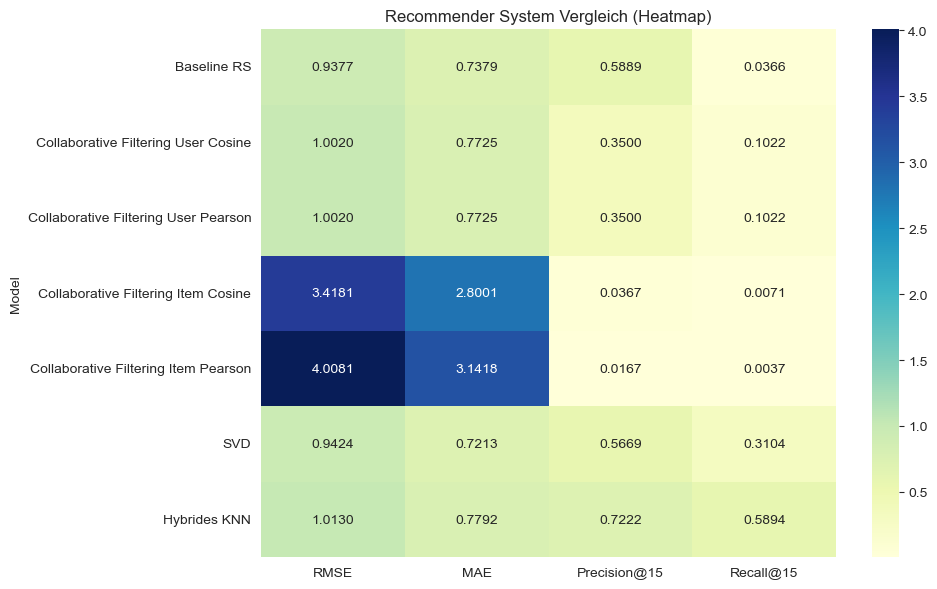

In [88]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_metrics.set_index("Model"), annot=True, fmt=".4f", cmap="YlGnBu")
plt.title("Recommender System Vergleich (Heatmap)")
plt.tight_layout()
plt.show()

Auffällig ist, dass das hybride KNN-Modell aus Aufgabe 9 insgesamt die besten Ergebnisse liefert. Es erreicht mit einer Precision@15 von 0.7222 und einem Recall@15 von 0.5894 die höchsten Werte, was auf eine hohe Qualität der empfohlenen Items hinweist. Auch das SVD-Modell zeigt eine starke Leistung, insbesondere bei den Fehlermassen RMSE (0.9419) und MAE (0.7210), was auf eine präzise Vorhersage der Bewertungen schliessen lässt.

Die benutzerbasierten Collaborative-Filtering-Modelle mit Cosinus- und Pearson-Ähnlichkeit liefern nahezu identische Ergebnisse. Dies zeigt, dass die Wahl der Ähnlichkeitsmetrik bei diesen Modellen kaum einen Unterschied macht. Sie befinden sich hinsichtlich der Fehlermasse im Mittelfeld, bleiben jedoch bei der Empfehlungsgenauigkeit (Precision@15 von 0.3500) deutlich hinter dem hybriden KNN-Modell und dem SVD zurück.

Deutlich schlechter schneiden hingegen die itembasierten Modelle ab. Sowohl der Item-Cosine- als auch der Item-Pearson-Ansatz weisen hohe Fehlerwerte (z.B. RMSE von 3.4181 bzw. 4.3389) und sehr niedrige Werte bei Precision@15 und Recall@15 auf. Dies legt nahe, dass diese Modelle für den verwendeten Datensatz ungeeignet sind oder dass die itembasierten Ähnlichkeiten nicht aussagekräftig genug sind.

Es ist jedoch zu beachten, dass aus Zeitgründen bei der Evaluation der Collaborative-Filtering-Modelle nur die ersten 20 Nutzer des Testdatensatzes berücksichtigt wurden. Dies könnte die Ergebnisse in gewissem Masse verzerren.

# b)
Es ist wichtig, einen Testdatensatz bis zum Schluss aufzubewahren, um am Ende des Benchmark-Prozesses objektiv beurteilen zu können, welches Modell am besten performt. Die Testdaten dürfen nicht für das Hyperparameter-Tuning verwendet werden, da das Modell sonst indirekt auf diese Daten angepasst wird.

Dies kann dazu führen, dass das Modell beim Benchmark-Test zwar gute Ergebnisse liefert, jedoch auf wirklich unbekannten Daten schlechter abschneidet. Der Grund dafür ist ein sogenanntes Data Leakage: Informationen aus den Testdaten fliessen ungewollt in den Trainingsprozess ein. Dadurch wird die Generalisierungsfähigkeit des Modells verzerrt – es ist auf die Testdaten überangepasst und funktioniert in der Praxis womöglich nicht zuverlässig.

**Read the Guidelines for Implementation and Submission one more time.**